## All Imports

In [489]:
import airr
import pandas as pd
import numpy as np
from collections import Counter
from math import sqrt
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib_venn import venn3, venn3_circles, venn2
from upsetplot import from_contents, plot
import os

## Directories

In [490]:
dirpath = '~/Projects/HannanLab/abscopal/vdjserver/853273733430055401-242ac11d-0001-007/'
tcr_file_dir = '/home/s234499/Work/TCRMatch/Input/'

## Utility Functions

In [491]:
def read_cdr3_dict(filename):
    """
    Read CDR3 files.
    """
    # print(filename)
    cdr3 = {}
    data = pd.read_csv(filename, sep = '\t', usecols = ['productive', 'junction_aa', 'duplicate_count'])
    data = data[data.productive == 'T'].drop("productive", axis=1)
    data = data.groupby(data.junction_aa).aggregate({"duplicate_count": 'sum'}).reset_index()
    data.set_index('junction_aa', inplace = True)
    result_dict = data['duplicate_count'].to_dict()
    return result_dict

def venn_cdr3(na, A, nb, B):
    print("\n*****")
    print(na + " total: " + str(len(A)))
    print(nb + " total: " + str(len(B)))
    X = A & B
    print("shared: " + str(len(X)))
    X = A - B
    print(na + " unique: " + str(len(X)))
    X = B - A
    print(nb + " unique: " + str(len(X)))
    print("*****\n")

def jaccard_index(dict1, dict2):
    """
    Get Jaccard index.
    """
    set1 = set(dict1.keys())
    set2 = set(dict2.keys())
    intersection = set1.intersection(set2)
    union = set1.union(set2)
    return len(intersection) / len(union) if len(union) > 0 else 0


def morisita_horn_index(dict1, dict2):
    """
    Get morisita--horn index.
    """
    
    # Normalize counts to frequencies
    total1 = sum(dict1.values())
    total2 = sum(dict2.values())
    freq1 = {k: v / total1 for k, v in dict1.items()}
    freq2 = {k: v / total2 for k, v in dict2.items()}

    common = set(freq1.keys()).intersection(freq2.keys())

    numerator = 2 * sum(freq1[k] * freq2[k] for k in common)
    denom1 = sum(v * v for v in freq1.values())
    denom2 = sum(v * v for v in freq2.values())

    denom = denom1 + denom2
    if denom == 0:
        return 0
    return numerator / denom


def plot_top_bottom_clonotypes(time_cdr3, time_labels, patient_id = None, N=20):
    common_clones = set.intersection(*[set(c.keys()) for c in time_cdr3])
    total_common = len(common_clones)
    print(f"Common number of TCRs across all time points: {total_common}")
    print("Common TCRs: \n")
    print(' '.join(clone for clone in common_clones))
    print()
    # Calculate total counts per sample to normalize frequencies
    totals = [sum(d.values()) for d in time_cdr3]
    # Frequency at selected time point to rank clones
    clone_totals = {clone: time_cdr3[-1].get(clone, 0) / totals[-1] for clone in common_clones}
    fig, axes = plt.subplots(1, 2, figsize=(18, 7), sharey=True)

    for ax, reverse, title in zip(axes, [True, False], ['Top Clones (Ascending)', 'Bottom Clones (Descending)']):
        top_clones = sorted(clone_totals, key=clone_totals.get, reverse=reverse)[:N]
        for clone in top_clones:
            freqs = [cdr3_dict.get(clone, 0) / total for cdr3_dict, total in zip(time_cdr3, totals)]
            ax.plot(time_labels, freqs, marker='o', label=clone)
        ax.set_xlabel('Time Point')
        ax.set_ylabel('Clone Frequency (relative)')
        ax.set_title(title)
        ax.legend(fontsize='small', bbox_to_anchor=(1.05, 1), loc='upper left')
        ax.tick_params(axis='x', rotation=45)
    
    plt.suptitle(f'{patient_id} total common with {time_labels[0]}:({total_common})')
    plt.tight_layout()
    fig_name = f'./Figures/{patient_id}_{time_labels[0]}_top_bottom_clone_line_plot.png'
    plt.savefig(fig_name, dpi=300, bbox_inches='tight')
    plt.show()
    
def plot_venn3(tumor_cdr3, nontumor_cdr3, distal_cdr3, patient_id = None):
    A = set(tumor_cdr3.keys())
    B = set(nontumor_cdr3.keys())
    C = set(distal_cdr3.keys())
    print(f'Total Tumor: {len(A)} \nTotal Non-Tumor: {len(B)} \nTotal Distal: {len(C)}')
    venn3([A, B, C], (f'Tumor({len(A)})', f'Non-Tumor({len(B)})', f'Distal({len(C)})'))
    plt.title(patient_id)
    fig_name = f'./Figures/{patient_id}_venn.png'
    plt.savefig(fig_name, dpi=300, bbox_inches='tight')
    plt.show()

def plot_venn_over_time(set1_dict, time_files, dirpath, set1_title = 'Tumor', patient_id = None,cols=4):
    set1 = set(set1_dict.keys())
    rows = (len(time_files) + cols - 1) // cols
    fig, axes = plt.subplots(rows, cols, figsize=(cols*4, rows*4))
    # If only one row, axes might be 1D
    if rows == 1:
        axes = axes.reshape(1, -1)
    for idx, f in enumerate(time_files):
        row = idx // cols
        col = idx % cols
        ax = axes[row, col]
        time_cdr3 = read_cdr3_dict(dirpath + f)
        set2 = set(time_cdr3.keys())
        v = venn2([set1, set2], (f'{set1_title}({len(set1)})', f'{f.split(".")[0]} ({len(set2)})'), ax=ax)
        if v.subset_labels[0]:
            v.subset_labels[0].set_position((-0.6, 0.4))
        if v.subset_labels[1]:
            v.subset_labels[1].set_position((0.6, 0.4))
    # Hide any unused subplots
    total_plots = rows * cols
    for empty_idx in range(len(time_files), total_plots):
        row = empty_idx // cols
        col = empty_idx % cols
        ax = axes[row, col]
        ax.axis('off')
    plt.tight_layout()
    plt.suptitle(patient_id)
    fig_name = f'./Figures/{patient_id}_venn_over_time_comapred_with_{set1_title}.png'
    plt.savefig(fig_name, dpi=300, bbox_inches='tight')
    plt.show()

def get_common_clones_among_time(all_clones):
    # Find common clones
    common_clones = set.intersection(*[set(c.keys()) for c in all_clones])
    # Track a few top clones
    print(f"Common number of TCRs among all time points: {len(common_clones)}")
    print("Common TCRs: \n")
    print(' '.join(clone for clone in common_clones))
    print()
    return common_clones

## Analysis

## 101 TC


*****
tumor total: 327
non-tumor total: 568
shared: 52
tumor unique: 275
non-tumor unique: 516
*****

Total Tumor: 327 
Total Non-Tumor: 568 
Total Distal: 359


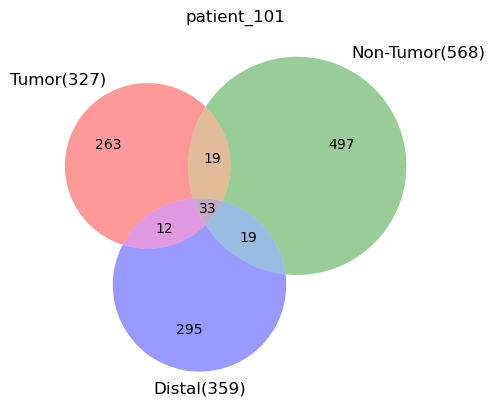

In [189]:
tumor_file = 'Thr_101_25516-1.igblast.airr.tsv'
nontumor_file = 'Thr_101_25516_9.igblast.airr.tsv'
distal_file = 'Thr_101_25519-1.igblast.airr.tsv'

tumor_cdr3 = read_cdr3_dict(dirpath + tumor_file)
nontumor_cdr3 = read_cdr3_dict(dirpath + nontumor_file)
distal_cdr3 = read_cdr3_dict(dirpath + distal_file)

patient_id = 'patient_101'

with open(f'{tcr_file_dir}/{patient_id}_tumor.txt', 'w') as f:
    for key in tumor_cdr3.keys():
        f.write(f"{key}\n")

#
# tumor-associated CDR3s
#
A = set(tumor_cdr3.keys())
B = set(nontumor_cdr3.keys())

venn_cdr3("tumor", A, "non-tumor", B)
TMNT = A - B

#pass tumor, non tumor and distal cdr3
plot_venn3(tumor_cdr3, nontumor_cdr3, distal_cdr3, patient_id = patient_id)


## 103 TC


*****
tumor total: 102
non-tumor total: 624
shared: 14
tumor unique: 88
non-tumor unique: 610
*****

Total Tumor: 102 
Total Non-Tumor: 624 
Total Distal: 160


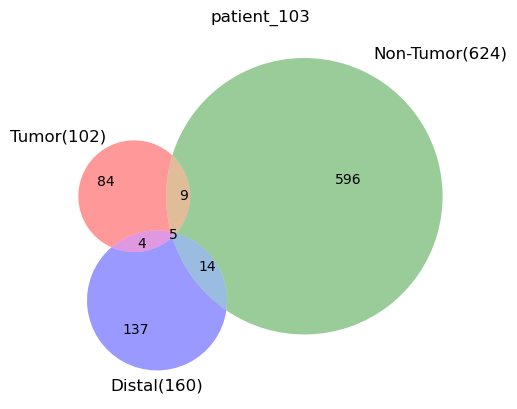

In [190]:
tumor_file = 'Thr_103_26277_1.igblast.airr.tsv'
nontumor_file = 'Thr_103_26277_3.igblast.airr.tsv'
distal_file = 'Thr_103_26276-1.igblast.airr.tsv'

tumor_cdr3 = read_cdr3_dict(dirpath + tumor_file)
nontumor_cdr3 = read_cdr3_dict(dirpath + nontumor_file)
distal_cdr3 = read_cdr3_dict(dirpath + distal_file)

patient_id = 'patient_103'

with open(f'{tcr_file_dir}/{patient_id}_tumor.txt', 'w') as f:
    for key in tumor_cdr3.keys():
        f.write(f"{key}\n")

time_cdr3 = []
A = set(tumor_cdr3.keys())
B = set(nontumor_cdr3.keys())

venn_cdr3("tumor", A, "non-tumor", B)
TMNT = A - B

plot_venn3(tumor_cdr3, nontumor_cdr3, distal_cdr3, patient_id = patient_id)

## 104 TC

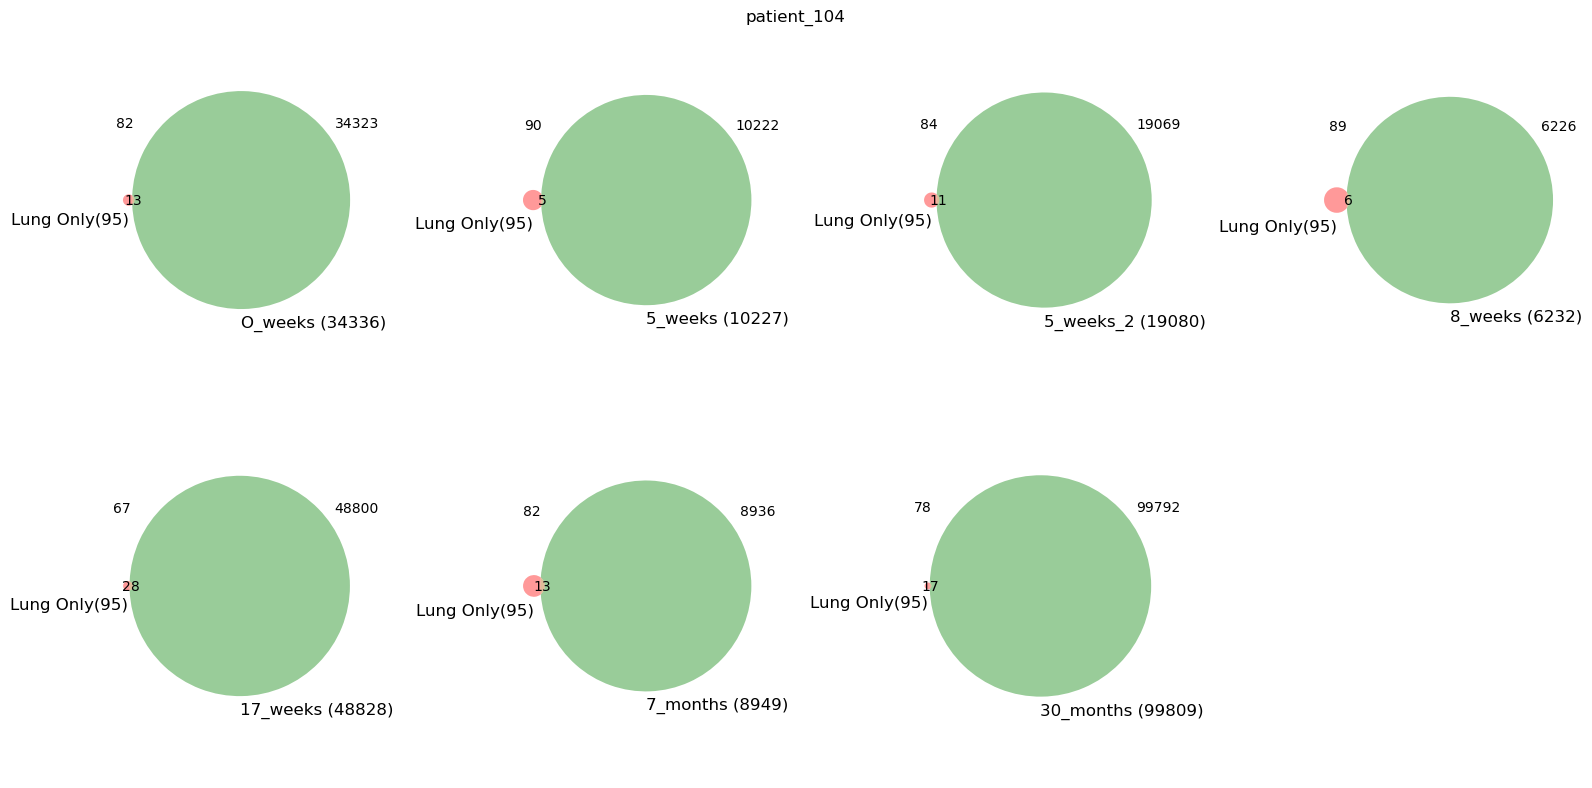

Common number of TCRs across all time points: 2
Common TCRs: 

CAIRQGARSPDETQYF CASSSAGDNEKLFF



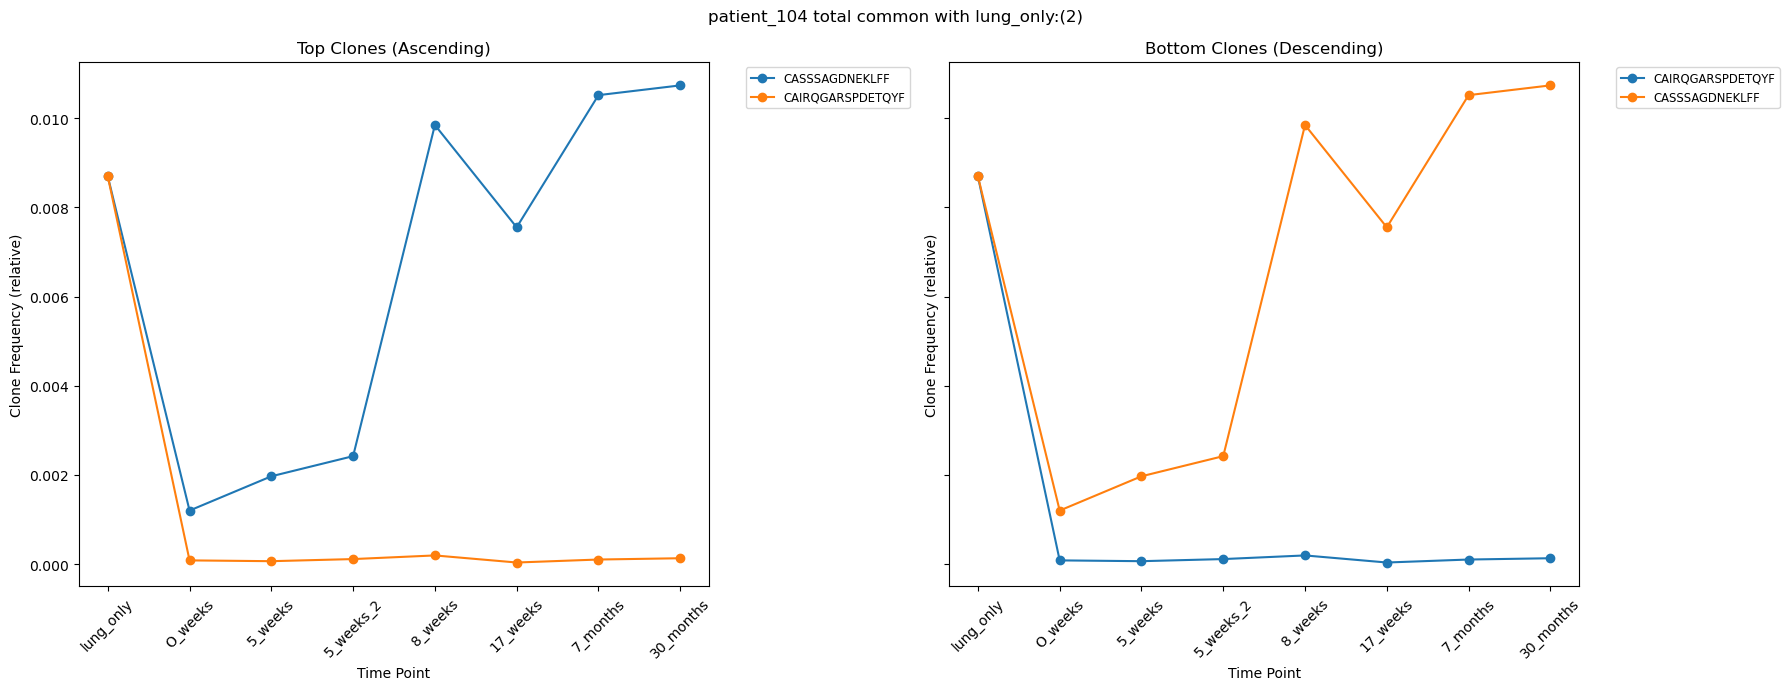

In [402]:
tumor_file = "24673-6.igblast.airr.tsv"
nontumor_file = "24563-5.igblast.airr.tsv"
lung_file = "022015-058-7.igblast.airr.tsv"
distal_file = '26473-1.igblast.airr.tsv'

time_files = [
    "O_weeks.igblast.airr.tsv",
    "5_weeks.igblast.airr.tsv",
    "5_weeks_2.igblast.airr.tsv",
    "8_weeks.igblast.airr.tsv",
    "17_weeks.igblast.airr.tsv",
    "7_months.igblast.airr.tsv",
    "30_months.igblast.airr.tsv"
    ]

tumor_cdr3 = read_cdr3_dict(dirpath + tumor_file)
nontumor_cdr3 = read_cdr3_dict(dirpath + nontumor_file)
distal_cdr3 = read_cdr3_dict(dirpath + distal_file)
lung_cdr3 = read_cdr3_dict(dirpath + lung_file)

patient_id = 'patient_104'

# with open(f'{tcr_file_dir}/{patient_id}_tumor.txt', 'w') as f:
#     for key in tumor_cdr3.keys():
#         f.write(f"{key}\n")
# with open(f'{tcr_file_dir}/{patient_id}_lung_biopsy.txt', 'w') as f:
#     for key in lung_cdr3.keys():
#         f.write(f"{key}\n")
        
tumor_only = {k: v for k, v in tumor_cdr3.items() if k not in nontumor_cdr3}
distal_only = {k: v for k, v in distal_cdr3.items() if k not in nontumor_cdr3}
lung_only = {k: v for k, v in lung_cdr3.items() if k not in nontumor_cdr3}

time_cdr3 = []
for f in time_files:
    time_cdr3.append(read_cdr3_dict(dirpath + f))
#Find common number of clones over time with tumor
# get_common_clones_among_time([tumor_only] + time_cdr3)

# #plot venn diagram for tumor, normal and distal
# plot_venn3(tumor_cdr3, nontumor_cdr3, distal_cdr3, patient_id = patient_id)
# #Venn over time for Distal file
# plot_venn_over_time(tumor_only, time_files, dirpath, set1_title = 'Tumor Only', patient_id = patient_id, cols=4)
# #Venn over time for Tumor File
# plot_venn_over_time(distal_only, time_files, dirpath, set1_title = 'Distal Only', patient_id = patient_id, cols=4)
# #Venn over time for Lung File
plot_venn_over_time(lung_only, time_files, dirpath, set1_title = 'Lung Only', patient_id = patient_id, cols=4)

# time_labels = ['lung_biopsy'] + [t_name.split('.')[0] for t_name in time_files]
# plot_top_bottom_clonotypes([lung_cdr3] + time_cdr3, time_labels, patient_id = patient_id, N=10)

# ## Plot Top and Bottom Common CDR3's
# time_labels = ['tumor_only'] + [t_name.split('.')[0] for t_name in time_files]
# plot_top_bottom_clonotypes([tumor_only] + time_cdr3, time_labels, patient_id = patient_id, N=10)

# ## Plot Top and Bottom Common CDR3's
# time_labels = ['distal_only'] + [t_name.split('.')[0] for t_name in time_files]
# plot_top_bottom_clonotypes([distal_only] + time_cdr3, time_labels, patient_id = patient_id, N=10)

## Plot Top and Bottom Common CDR3's
time_labels = ['lung_only'] + [t_name.split('.')[0] for t_name in time_files]
plot_top_bottom_clonotypes([lung_only] + time_cdr3, time_labels, patient_id = patient_id, N=10)


## Plot a Single CDR3 Over Time

104
Common number of TCRs across all time points: 1
Common TCRs: 

CASSPGTGPYEQYF

[881, 398, 2112, 46564, 78262, 129, 462328]
{'CASSPGTGPYEQYF': 13}
[0, 0, 0, 1, 21, 4, 13]


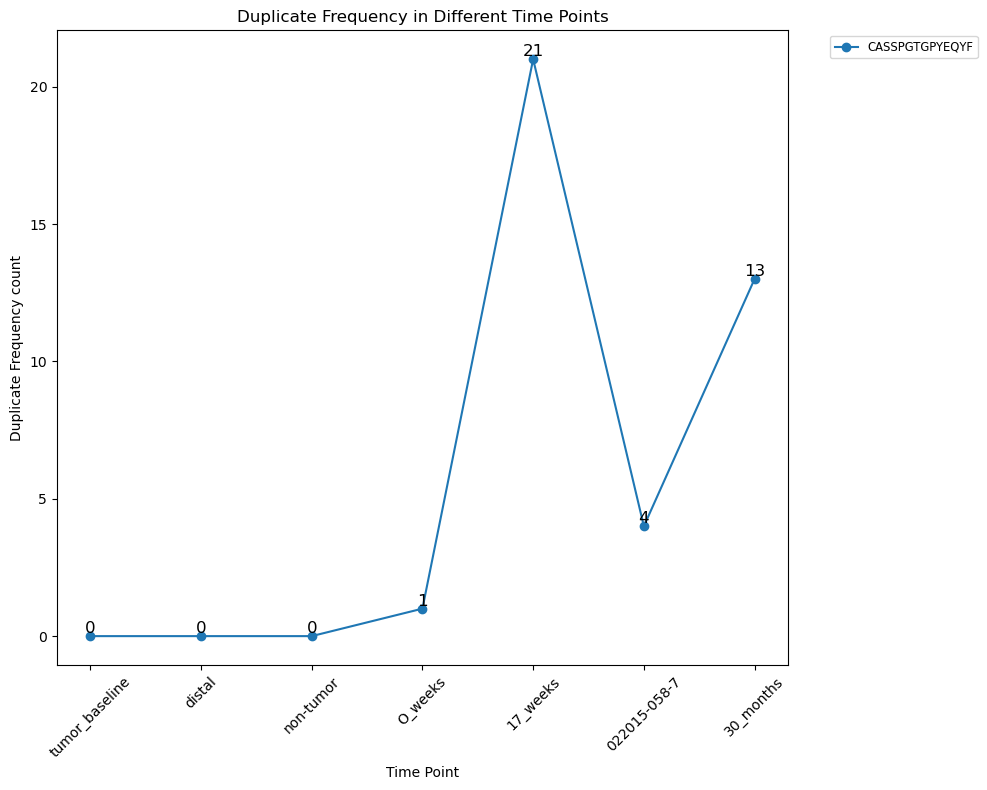

In [359]:
tumor_file = "24673-6.igblast.airr.tsv"
nontumor_file = "24563-5.igblast.airr.tsv"
# lung_file = "022015-058-7.igblast.airr.tsv"
distal_file = '26473-1.igblast.airr.tsv'

time_files = [
    "O_weeks.igblast.airr.tsv",
    "17_weeks.igblast.airr.tsv",
    "022015-058-7.igblast.airr.tsv",
    "30_months.igblast.airr.tsv"
    ]

tumor_cdr3 = read_cdr3_dict(dirpath + tumor_file)
nontumor_cdr3 = read_cdr3_dict(dirpath + nontumor_file)
distal_cdr3 = read_cdr3_dict(dirpath + distal_file)
lung_cdr3 = read_cdr3_dict(dirpath + lung_file)

print(len(lung_cdr3))
patient_id = 'patient_104'
time_cdr3 = []
for f in time_files:
    time_cdr3.append(read_cdr3_dict(dirpath + f))


time_labels = ['tumor_baseline']+ ['distal'] + ['non-tumor'] + [t_name.split('.')[0] for t_name in time_files]

all_cdr3s = [tumor_cdr3] + [distal_cdr3]+ [nontumor_cdr3] + time_cdr3
common_clones = set.intersection(*[set(c.keys()) for c in all_cdr3s])
common_clones = {'CASSPGTGPYEQYF'}
total_common = len(common_clones)
print(f"Common number of TCRs across all time points: {total_common}")
print("Common TCRs: \n")
print(' '.join(clone for clone in common_clones))
print()
# Calculate total counts per sample to normalize frequencies
totals = [sum(d.values()) for d in all_cdr3s]
print(totals)
# Frequency at selected time point to rank clones
clone_totals = {clone: time_cdr3[-1].get(clone, 0) for clone in common_clones}
print(clone_totals)
fig, ax = plt.subplots(1, 1, figsize=(10, 8))

for clone in clone_totals:
    freqs = [cdr3_dict.get(clone, 0) for cdr3_dict in all_cdr3s]
    print(freqs)
    ax.plot(time_labels, freqs, marker='o', label=clone)
for i, freq in enumerate(freqs):
    ax.text(i, freq, str(freq), fontsize=12, ha='center', va='bottom')
ax.set_xlabel('Time Point')
ax.set_ylabel('Duplicate Frequency count')
ax.set_title('Duplicate Frequency in Different Time Points')
ax.legend(fontsize='small', bbox_to_anchor=(1.05, 1), loc='upper left')
ax.tick_params(axis='x', rotation=45)

# plt.suptitle(f'{patient_id} total common with {time_labels[0]}:({total_common})')
plt.tight_layout()
# fig_name = f'./Figures/{patient_id}_{time_labels[0]}_top_bottom_clone_line_plot.png'
# plt.savefig(fig_name, dpi=300, bbox_inches='tight')
plt.show()






## Looking at Clonotype Overlap Uisng Jaccard and Morisita Horn Patient 104

In [17]:
for i in range(1, len(time_cdr3)):
    overlap_jaccard = jaccard_index(time_cdr3[0], time_cdr3[i])
    overlap_mh = morisita_horn_index(time_cdr3[0], time_cdr3[i])
    print(f"\nOverlap in time {i}\n")
    print(f"Jaccard: {overlap_jaccard:.3f}")
    print(f"Morisita-Horn: {overlap_mh:.3f}")
    print()



Overlap in time 1

Jaccard: 0.001
Morisita-Horn: 0.141


Overlap in time 2

Jaccard: 0.004
Morisita-Horn: 0.181


Overlap in time 3

Jaccard: 0.002
Morisita-Horn: 0.144


Overlap in time 4

Jaccard: 0.006
Morisita-Horn: 0.236


Overlap in time 5

Jaccard: 0.001
Morisita-Horn: 0.206


Overlap in time 6

Jaccard: 0.003
Morisita-Horn: 0.303


Overlap in time 7

Jaccard: 0.000
Morisita-Horn: 0.119



## 105 TC

Total Tumor: 2755 
Total Non-Tumor: 1085 
Total Distal: 758


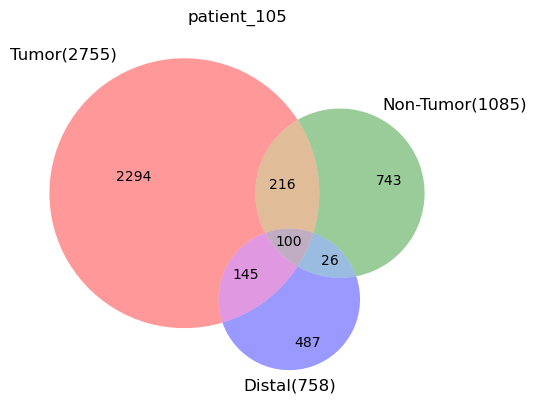

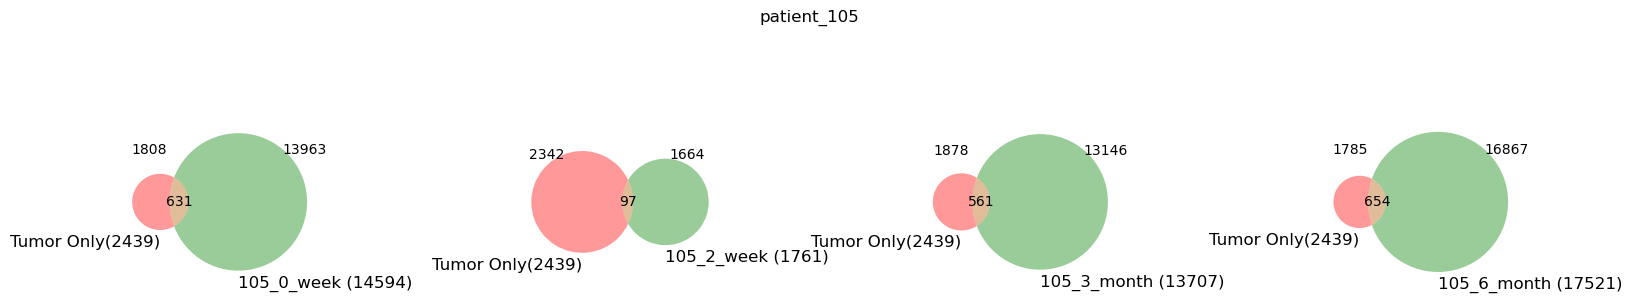

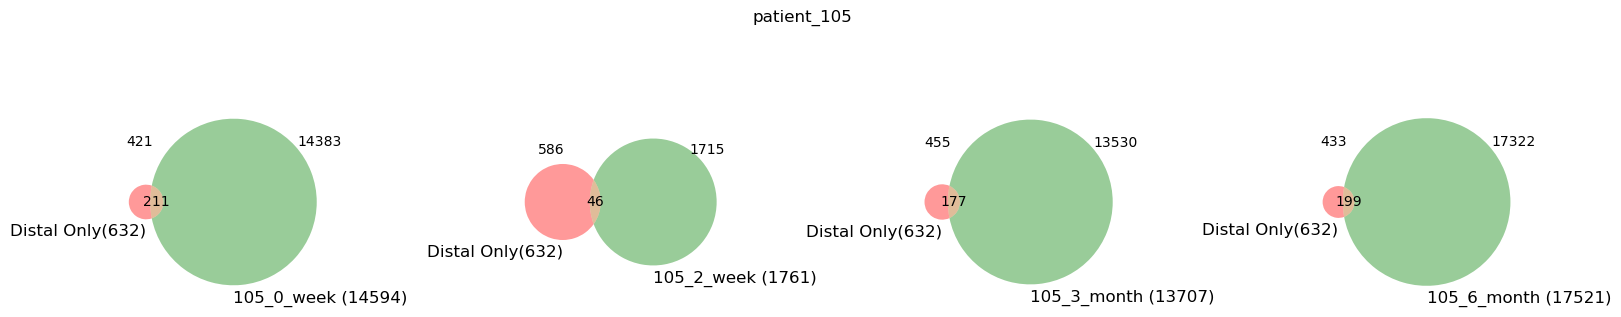

Common number of TCRs across all time points: 73
Common TCRs: 

CSASRPRGALLQPQHF CASNGGSGANVLTF CASSDRTSGNTIYF CASSLKDYGYTF CASSQTGGRWETQYF CSASPGIGDTEAFF CASTVSSGRPGEQYF CASSLEGFQPQHF CSVWTVGSSGNTIYF CASSWDRGRYGYTF CSVGLGTSKETQYF CSVQRTGAYGYTF CASSLTISLAGIRGDTQYF CASGTWTASTDTQYF CASSLKGTGDFAQFF CASRAEKGWWNQPQHF CASSVGGGASDTQYF CASSYSAAGEYNEQFF CASSVEVRGDTEAFF CASSPNEGVSYEQYF CASSIGRVVSYEQYF CASSLSAANTEAFF CASSGRDAANTEAFF CASGTGLGYEQYF CAWSVGAPRRSQPQHF CSALGLSISYEQYF CASSSIGQGASYEQYF CASLASGTPEQFF CASSTTGTGPEQYF CASSLGTLDGYTF CASSERGTPGYTF CAISEGQGRNTIYF CASSPGGRHTEAFF CASSQTGSLNEQFF CASSDLGPNTGELFF CASSPTLSYEQYF CASSYLNEQFF CASSSAGSNEQFF CASSKQGMNYGYTF CASSSSAESSYNEQFF CASSPGLAGLGRETQYF CASSQMVTGSSYEQYF CASSVRQGARGTGELFF CATSRDKGVDYGYTF CASSSRGALDEQYF CASSEFRGEYF CASSLGSQPQHF CASSSNRGAGSGYTF CASSRPQGPAYEQYF CASSLGGAKGYTF CASSRLGGGQPQHF CAWSRDRGPYQPQHF CASSSDLKTQYF CASSVRIEEKLFF CSAREGSSGSNEQFF CASSPDRGRDQPQHF CASSSSGDGGYTF CASIQQGPYEQYF CASSQERGEAFF CASSQGETQYF CASSETLKQFF CATSDSRDTGE

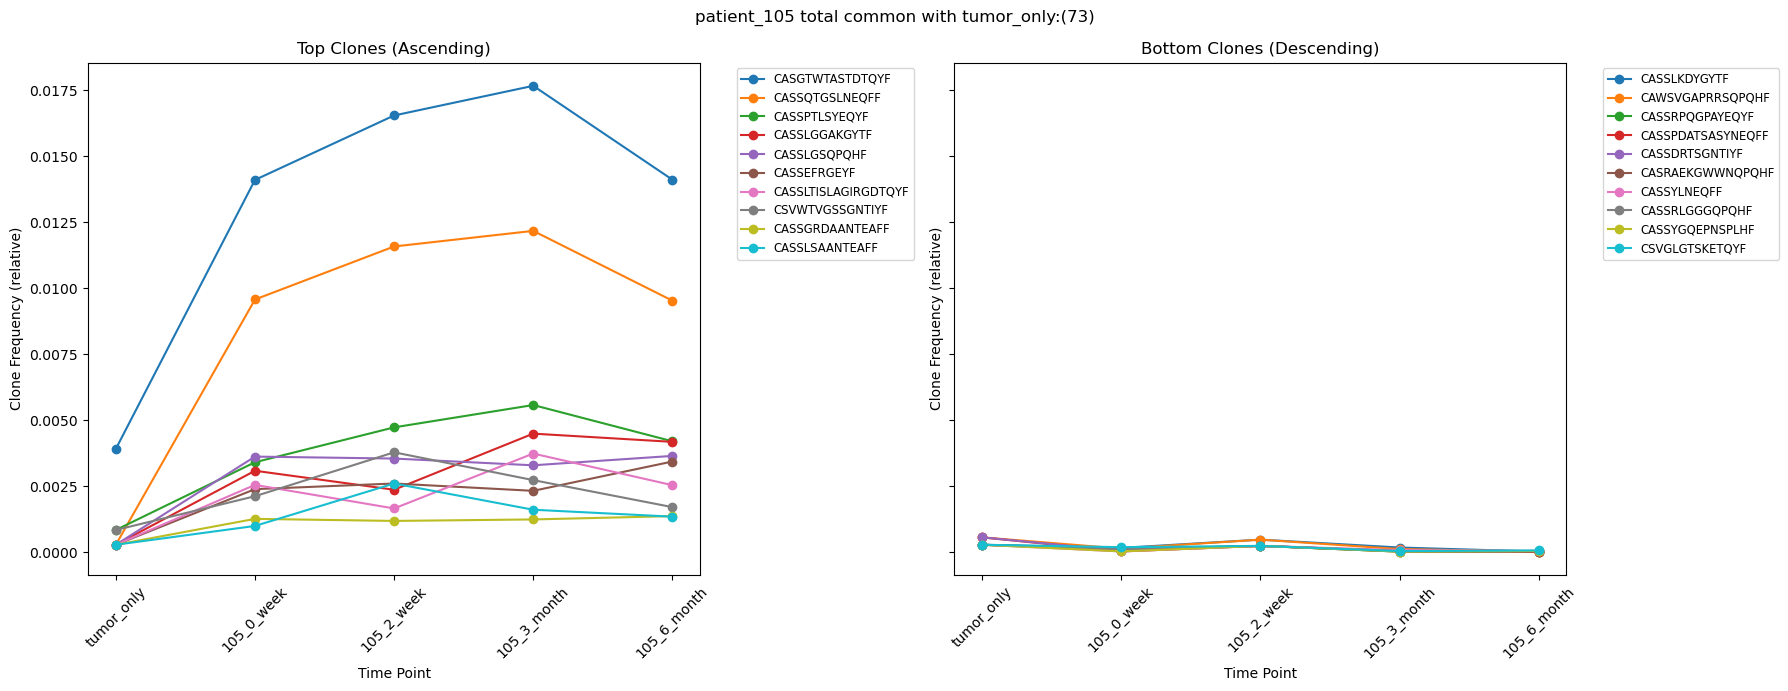

Common number of TCRs across all time points: 39
Common TCRs: 

CSASRPRGALLQPQHF CASNGGSGANVLTF CSGRADGFGEQFF CASSTANEQFF CASSQTGGRWETQYF CSASPGIGDTEAFF CASSPPSSDLLETQYF CASSSPGGGLDTQYF CSAKIGILRLF CASSLTISLAGIRGDTQYF CASSIGVLRPGELFF CASGTWTASTDTQYF CSVGYGYTF CASSLSAANTEAFF CASSVGGGASDTQYF CASSVEVRGDTEAFF CASSIGRVVSYEQYF CASSGRDAANTEAFF CASGTGLGYEQYF CASSSIGQGASYEQYF CASLASGTPEQFF CASSLDRVYNYGYTF CASSLIGSYNEQFF CASSQTGSLNEQFF CASSPTLSYEQYF CASSVRQGARGTGELFF APAAGRTSSTS CASSEFRGEYF CASSLGSQPQHF CASSSSGGMSYEQYF CASSLGGAKGYTF CASSLGSGLQPQHF CASIQQGPYEQYF CATSDPGRRGGSYTF CASSQDGMRDEQFF APAACGGATLKLS CASDTQGSDTQYF CASSRLDRGNSPLHF CASSQGEGAREKLFF



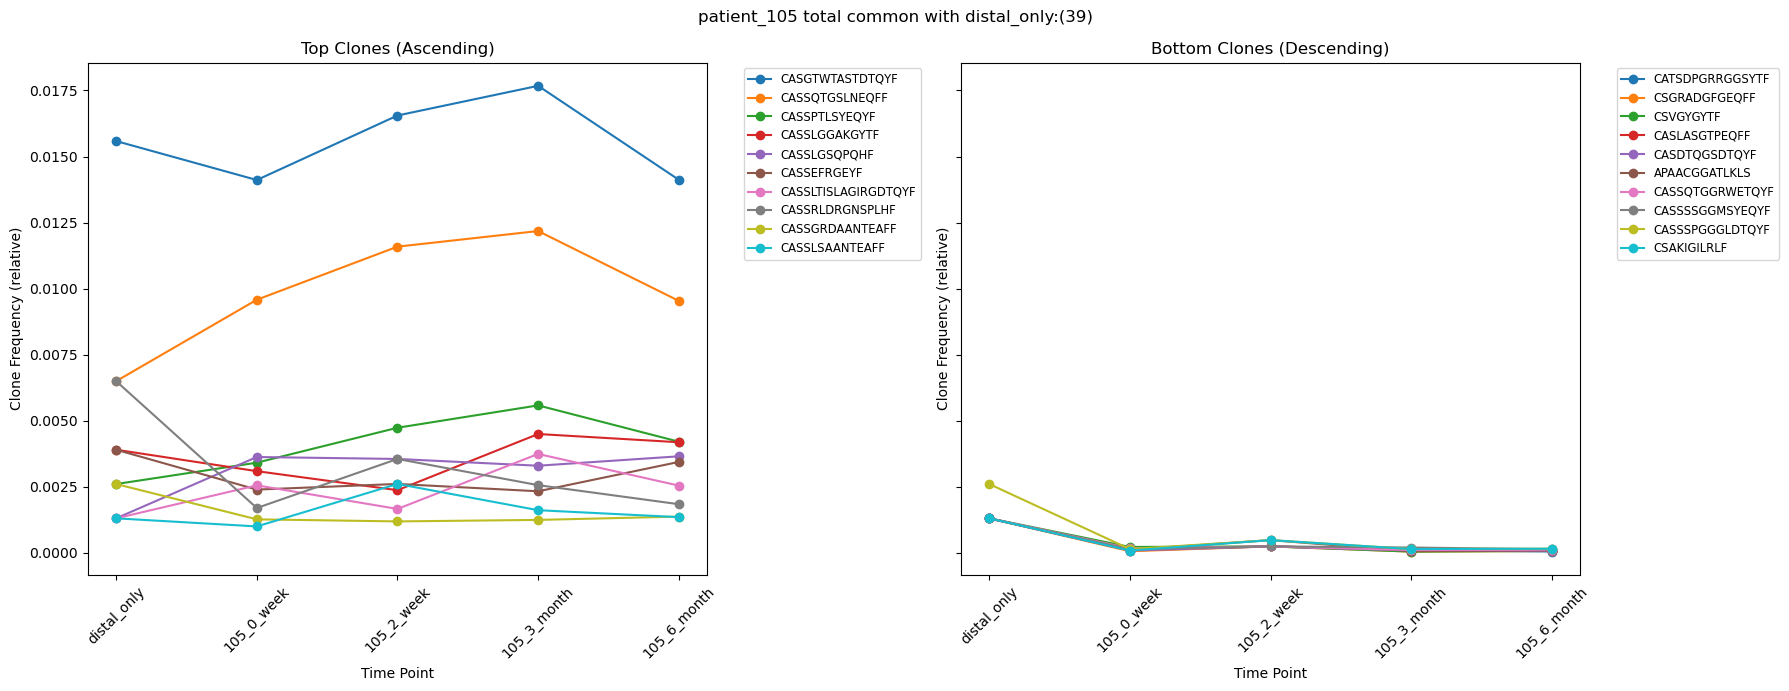

In [182]:
tumor_file = 'Thr_105_28473_2H.igblast.airr.tsv'
nontumor_file = 'Thr_105_28473_3.igblast.airr.tsv'
distal_file = 'Thr_105_28474-4.igblast.airr.tsv'

time_files = [
    '105_0_week.igblast.airr.tsv',
    '105_2_week.igblast.airr.tsv',
    '105_3_month.igblast.airr.tsv',
    '105_6_month.igblast.airr.tsv'
]

tumor_cdr3 = read_cdr3_dict(dirpath + tumor_file)
nontumor_cdr3 = read_cdr3_dict(dirpath + nontumor_file)
distal_cdr3 = read_cdr3_dict(dirpath + distal_file)

patient_id = 'patient_105'

with open(f'{tcr_file_dir}/{patient_id}_tumor.txt', 'w') as f:
    for key in tumor_cdr3.keys():
        f.write(f"{key}\n")
tumor_only = {k: v for k, v in tumor_cdr3.items() if k not in nontumor_cdr3}
distal_only = {k: v for k, v in distal_cdr3.items() if k not in nontumor_cdr3}


time_cdr3 = []
for f in time_files:
    time_cdr3.append(read_cdr3_dict(dirpath + f))
#Find common number of clones over time with tumor
# get_common_clones_among_time([tumor_only] + time_cdr3)

#plot venn diagram for tumor, normal and distal
plot_venn3(tumor_cdr3, nontumor_cdr3, distal_cdr3, patient_id = patient_id)
#Venn over time for Distal file
plot_venn_over_time(tumor_only, time_files, dirpath, set1_title = 'Tumor Only', patient_id = patient_id, cols=4)
#Venn over time for Tumor File
plot_venn_over_time(distal_only, time_files, dirpath, set1_title = 'Distal Only', patient_id = patient_id, cols=4)

## Plot Top and Bottom Common CDR3's
time_labels = ['tumor_only'] + [t_name.split('.')[0] for t_name in time_files]
plot_top_bottom_clonotypes([tumor_only] + time_cdr3, time_labels, patient_id = patient_id, N=10)

## Plot Top and Bottom Common CDR3's
time_labels = ['distal_only'] + [t_name.split('.')[0] for t_name in time_files]
plot_top_bottom_clonotypes([distal_only] + time_cdr3, time_labels, patient_id = patient_id, N=10)

# keep_keys = tumor_cdr3.keys() - nontumor_cdr3.keys()
# # keep_keys = tumor_cdr3.keys() & distal_cdr3.keys()
# # print("Keeping: ", len(keep_keys))
# only_tumors = {key: tumor_cdr3[key] for key in keep_keys}

# # keep_keys = distal_cdr3.keys() - nontumor_cdr3.keys()
# # print(len(keep_keys))
# # only_tumors = {key: distal_cdr3[key] for key in keep_keys}

# time_cdr3 = [only_tumors]

# for f in time_files:
#     time_cdr3.append(read_cdr3_dict(dirpath + f))
# #
# # tumor-associated CDR3s
# #
# patient_id = 'Patient 105' 
# plot_venn_over_time(only_tumors, time_files, dirpath, set1_title = 'Tumor', patient_id = patient_id, cols=4)


# A = set(tumor_cdr3.keys())
# B = set(nontumor_cdr3.keys())
# venn_cdr3("tumor", A, "non-tumor", B)
# TMNT = A - B

# i = 0
# time_set = []
# for i, f in enumerate(time_cdr3):
#     X = set(f.keys())
#     venn_cdr3("TMNT", TMNT, "time " + str(i), X)
#     time_set.append(TMNT & X)

# X = time_set[0] & time_set[1] & time_set[2] & time_set[3] & time_set[4]
# venn_cdr3("TMNT", TMNT, "all time", X)

# # Get total number of common clones in all times shared with Tumor
# get_common_clones_among_time(time_cdr3)

# plot_venn3(tumor_cdr3, nontumor_cdr3, distal_cdr3, patient_id = patient_id)

# ## Plot Top and Bottom Common CDR3's
# time_labels = ['Tumor Baseline'] +[t_name.split('.')[0] for t_name in time_files]
# plot_top_bottom_clonotypes(time_cdr3, time_labels, time_idx=0, N=15)

## Looking at Clonotype Overlap Uisng Jaccard and Morisita Horn Patient 105

In [19]:
for i in range(1, len(time_cdr3)):
    overlap_jaccard = jaccard_index(time_cdr3[0], time_cdr3[i])
    overlap_mh = morisita_horn_index(time_cdr3[0], time_cdr3[i])
    print(f"\nOverlap in time {i}\n")
    print(f"Jaccard: {overlap_jaccard:.3f}")
    print(f"Morisita-Horn: {overlap_mh:.3f}")
    print()



Overlap in time 1

Jaccard: 0.012
Morisita-Horn: 0.211


Overlap in time 2

Jaccard: 0.045
Morisita-Horn: 0.222


Overlap in time 3

Jaccard: 0.011
Morisita-Horn: 0.222


Overlap in time 4

Jaccard: 0.009
Morisita-Horn: 0.239



## 106 TC

Total Tumor: 2845 
Total Non-Tumor: 154 
Total Distal: 1039


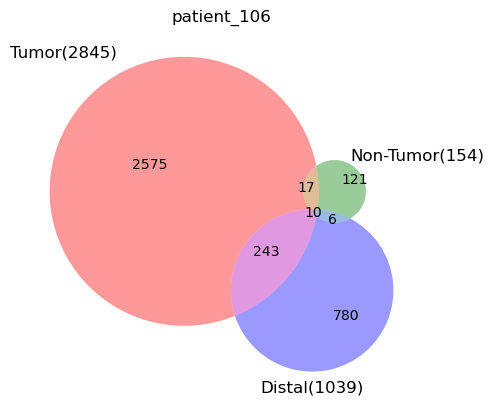

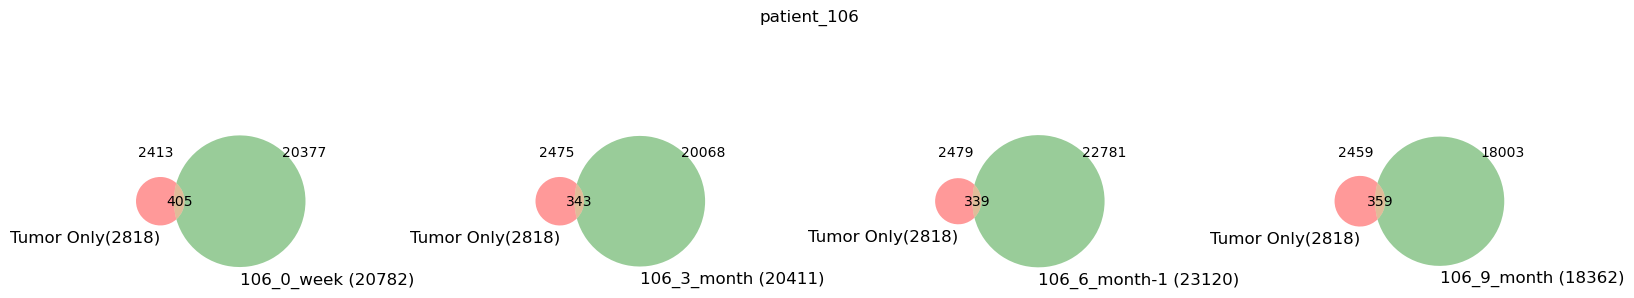

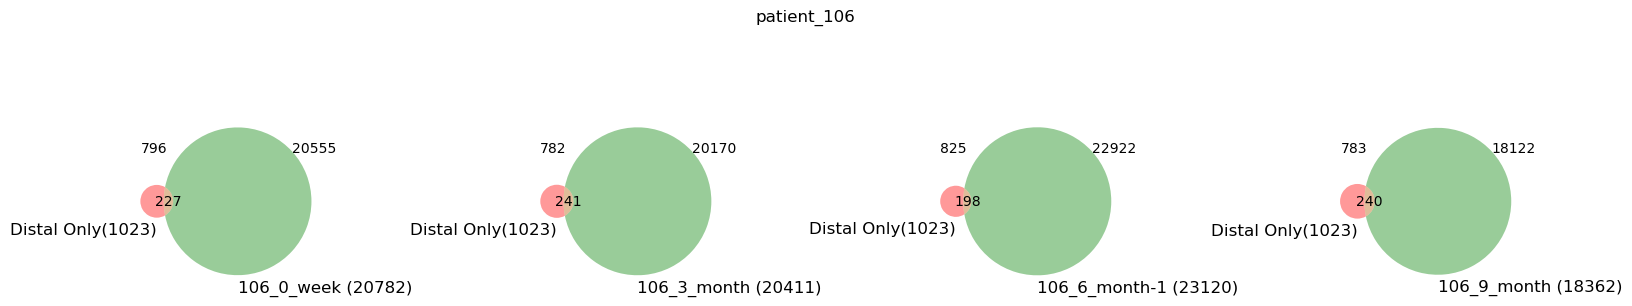

Common number of TCRs across all time points: 146
Common TCRs: 

CAILTGRGLPEAFF CASSIGTGNYEQYF CASSLGTAYNEQFF CASSQDRSLRAGKLFF CASSKGTSGLNEQFF CASSLSTGDNTIYF CSVSSGDTGELFF CATVTGFNEQFF CASSLTVNPGAPGETQYF CASRIQGTNSPLHF CASSARDYHTGELFF CASSPGRWETQYF CASGRYNQPQHF CASSFPWDIAGETQYF CASSPQRLTEAFF CSASEGGTGSQPQHF CASTAGTGRSGANVLTF CASSMWESGSQFF CASTTIRDRGQETQYF CASSFSGSQETQYF CASTGFGTGNNEQFF CASRPRDRVGEQFF CASRGWTGGPSYEQYF CASSSASGNTIYF CASSQDGPYGYTF CASSQADRLGDTQYF CASLGGSPTLAKNIQYF CASSFGDEQYF CSGQHQETQYF CASSLVGEFYEQYF CASSTTSGGSTDTQYF CASSLIVGSTDTQYF CASRGDTQYF CASSKRGDNQPQHF CASSQVWGLGYGYTF CASSYNEWGTEAFF CSARHSSGVTYNEQFF CASRQRIAKNIQYF CASSYSGGSYDEQYF CASSSTGRSNQPQHF CAISEHTGELFF CASSPRGPSTDTQYF CASSPRGRNYNEQFF CASSAEGAGEQFF CASSLARQNKETQYF CASSDSGTEAFF CASSLGGTGSQPQHF CASSQDFLFNEQFF CASSLKGAGTGELFF CASSPPGTEIGEKLFF CASSQEIAGGDNEQFF CASSPRGLSYEQYF CASSELGAYSNQPQHF CAWGDGAVYEQYF CASSLPSKGETQYF CASGLVLSIGQETQYF CASSLGQGTEAFF CASSQDLVVGDIYGYTF CASSGNQVGPRHGYTF CASSLVATHYEQYF CASSVGTTGQPQH

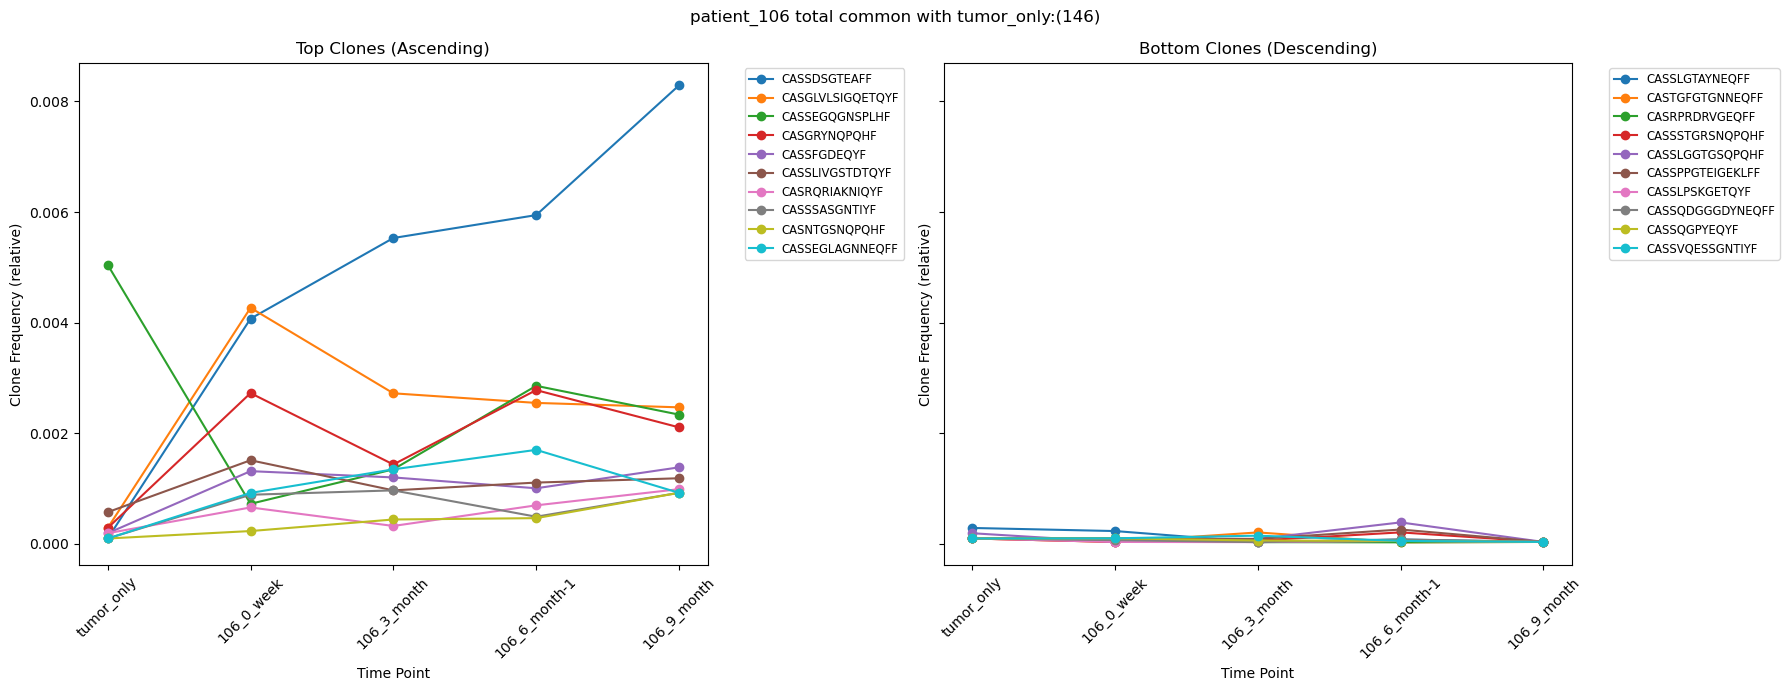

Common number of TCRs across all time points: 103
Common TCRs: 

CASSFPWGETQYF CASSLSNQPQHF CSVSSGDTGELFF CATVTGFNEQFF CASSLTVNPGAPGETQYF CASSARDYHTGELFF CASGRYNQPQHF CASSFPWDIAGETQYF CASSSPVTSGGFFEQFF CSASEGGTGSQPQHF CASTAGTGRSGANVLTF CASSFRIGSETQYF CASTTIRDRGQETQYF CASSFSGSQETQYF CASSSSGGTNTEAFF CASSLLPTDSTQETQYF CASSSASGNTIYF CASSFGDEQYF CSGQHQETQYF CASRQGQGDVETQYF CASSLIVGSTDTQYF CASSRGVLDQPQHF CASSRGTEAFF CASSRTGGPYEQYF CASSYSGGSYDEQYF CASSQEDRPNQPQHF CAISEHTGELFF CASSPRGPSTDTQYF CASSLGMNTEAFF CASSLIATNEKLFF CASSLARQNKETQYF CASSQDFLFNEQFF CASSDSGTEAFF CASSLGGTGSQPQHF CASSPPGTEIGEKLFF CASSQEIAGGDNEQFF CASSLGVLTDNEQFF CASSELGAYSNQPQHF CAWGDGAVYEQYF CASSLGTGELFF CAWSVEGHSNQPQHF CASGLVLSIGQETQYF CASSLVTGLDGDNTQYF CASSGNQVGPRHGYTF CASRPGVNNEQFF CASSGGTGTGELFF CASSFQGVGNQPQHF CASSSGTGSISSGNTIYF CASSEPGQASSLHKNEQFF CATFTGTSGQETQYF CASSLGYEQYF CASSDSSYNSPLHF CSAPRTGEYEQYF CATSRDSGGSYEQYF CASSPVQGESTDTQYF CASSLGPDQPQHF CASSTETGLADQETQYF CASSASDNSPLHF CSASGEGGLNTDTQYF CASSESYEQYF CAWSPPTGGY

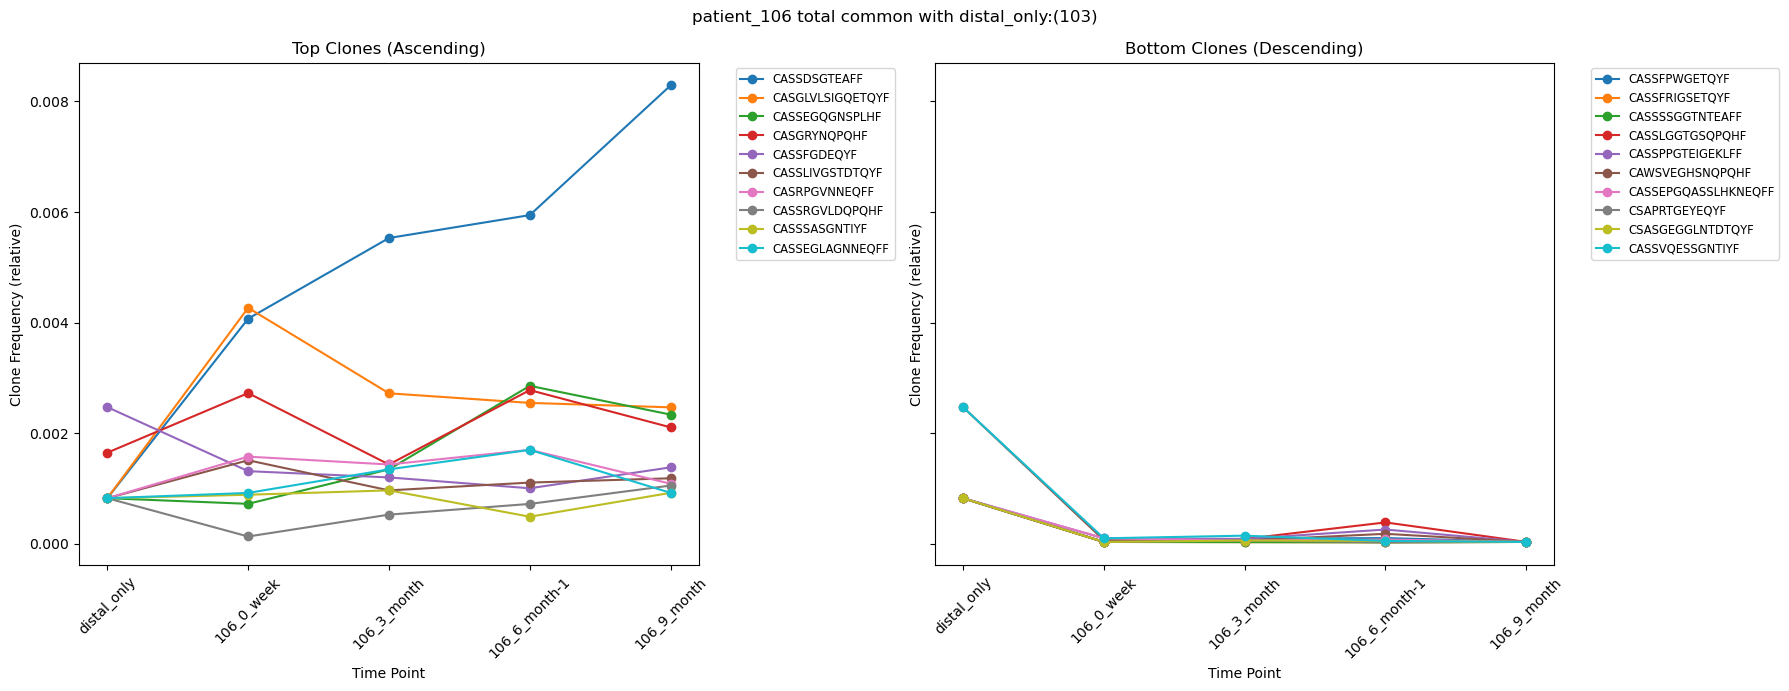

In [183]:
tumor_file = 'Thr_106_30817-2.igblast.airr.tsv'
nontumor_file = 'Thr_106_30817_1.igblast.airr.tsv'
distal_file = 'Thr_106_30818_1.igblast.airr.tsv'

time_files = [
    '106_0_week.igblast.airr.tsv',
    '106_3_month.igblast.airr.tsv',
    '106_6_month-1.igblast.airr.tsv',
    '106_9_month.igblast.airr.tsv'
]

tumor_cdr3 = read_cdr3_dict(dirpath + tumor_file)
nontumor_cdr3 = read_cdr3_dict(dirpath + nontumor_file)
distal_cdr3 = read_cdr3_dict(dirpath + distal_file)

patient_id = 'patient_106'

with open(f'{tcr_file_dir}/{patient_id}_tumor.txt', 'w') as f:
    for key in tumor_cdr3.keys():
        f.write(f"{key}\n") 
        
tumor_only = {k: v for k, v in tumor_cdr3.items() if k not in nontumor_cdr3}
distal_only = {k: v for k, v in distal_cdr3.items() if k not in nontumor_cdr3}


time_cdr3 = []
for f in time_files:
    time_cdr3.append(read_cdr3_dict(dirpath + f))
#Find common number of clones over time with tumor
# get_common_clones_among_time([tumor_only] + time_cdr3)

#plot venn diagram for tumor, normal and distal
plot_venn3(tumor_cdr3, nontumor_cdr3, distal_cdr3, patient_id = patient_id)
#Venn over time for Distal file
plot_venn_over_time(tumor_only, time_files, dirpath, set1_title = 'Tumor Only', patient_id = patient_id, cols=4)
#Venn over time for Tumor File
plot_venn_over_time(distal_only, time_files, dirpath, set1_title = 'Distal Only', patient_id = patient_id, cols=4)

## Plot Top and Bottom Common CDR3's
time_labels = ['tumor_only'] + [t_name.split('.')[0] for t_name in time_files]
plot_top_bottom_clonotypes([tumor_only] + time_cdr3, time_labels, patient_id = patient_id, N=10)

## Plot Top and Bottom Common CDR3's
time_labels = ['distal_only'] + [t_name.split('.')[0] for t_name in time_files]
plot_top_bottom_clonotypes([distal_only] + time_cdr3, time_labels, patient_id = patient_id, N=10)

# keep_keys = tumor_cdr3.keys() - nontumor_cdr3.keys()
# keep_keys = tumor_cdr3.keys() & distal_cdr3.keys()
# keep_keys = distal_cdr3.keys() - nontumor_cdr3.keys()

# print("Keeping: ", len(keep_keys))
# only_distal = {key: distal_cdr3[key] for key in keep_keys}
# time_cdr3 = [only_distal]


# for f in time_files:
#     time_cdr3.append(read_cdr3_dict(dirpath + f))
# #
# # tumor-associated CDR3s
# #

# A = set(tumor_cdr3.keys())
# B = set(nontumor_cdr3.keys())
# venn_cdr3("tumor", A, "non-tumor", B)
# TMNT = A - B

# i = 0
# time_set = []
# for i, f in enumerate(time_cdr3):
#     X = set(f.keys())
#     venn_cdr3("TMNT", TMNT, "time " + str(i), X)
#     time_set.append(TMNT & X)

# X = time_set[0] & time_set[1] & time_set[2] & time_set[3] & time_set[4]
# venn_cdr3("TMNT", TMNT, "all time", X)

# # Get total number of common clones in all times shared with Tumor
# get_common_clones_among_time(time_cdr3)

# plot_venn3(tumor_cdr3, nontumor_cdr3, distal_cdr3, patient_id = 'Patient 106')

# ## Plot Top and Bottom Common CDR3's
# time_labels = ['Tumor Baseline'] +[t_name.split('.')[0] for t_name in time_files]
# plot_top_bottom_clonotypes(time_cdr3, time_labels, time_idx=0, N=15)

## Looking at Clonotype Overlap Uisng Jaccard and Morisita Horn Patient 106

In [21]:
for i in range(1, len(time_cdr3)):
    overlap_jaccard = jaccard_index(time_cdr3[0], time_cdr3[i])
    overlap_mh = morisita_horn_index(time_cdr3[0], time_cdr3[i])
    print(f"\nOverlap in time {i}\n")
    print(f"Jaccard: {overlap_jaccard:.3f}")
    print(f"Morisita-Horn: {overlap_mh:.3f}")
    print()


Overlap in time 1

Jaccard: 0.011
Morisita-Horn: 0.070


Overlap in time 2

Jaccard: 0.011
Morisita-Horn: 0.066


Overlap in time 3

Jaccard: 0.008
Morisita-Horn: 0.068


Overlap in time 4

Jaccard: 0.013
Morisita-Horn: 0.068



## 107 TC

Total Tumor: 1068 
Total Non-Tumor: 2576 
Total Distal: 2645


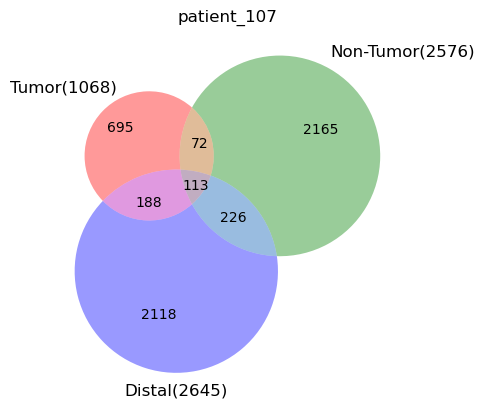

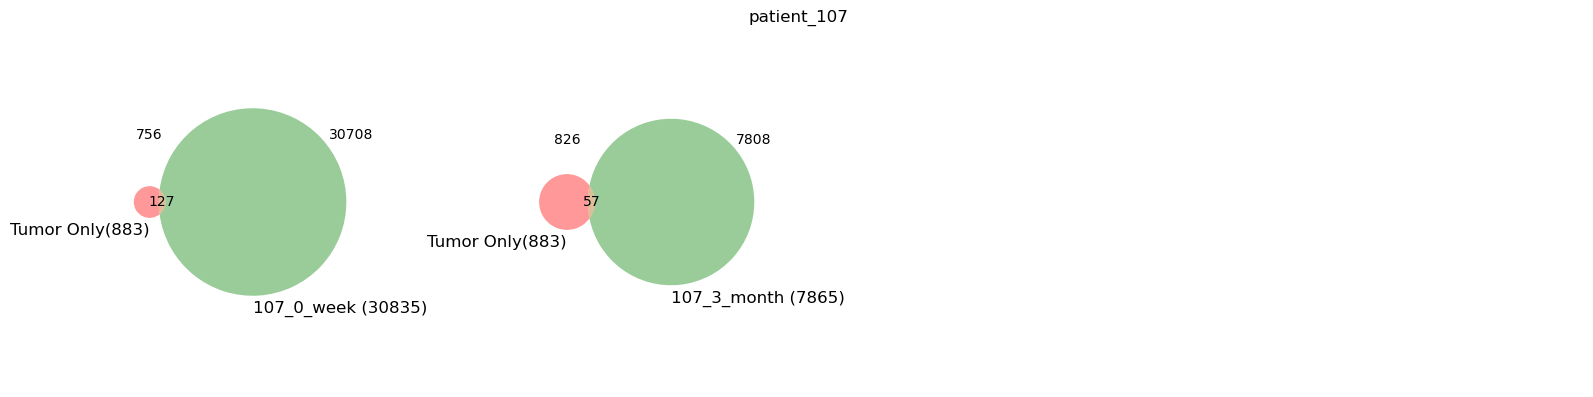

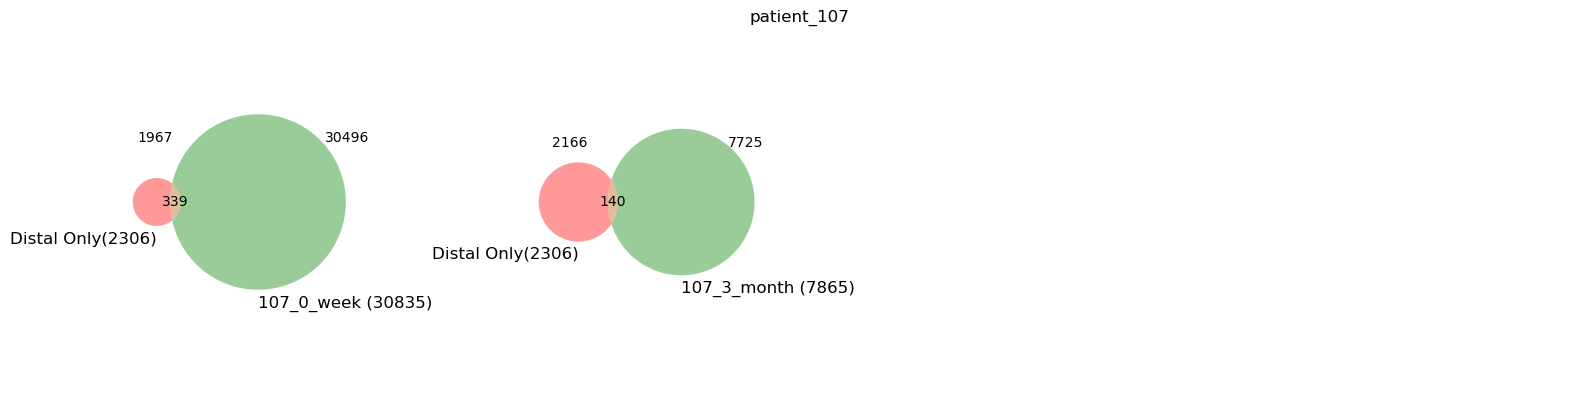

Common number of TCRs across all time points: 35
Common TCRs: 

CASSQIEGGEAFF CAWTGYNEKLFF CASSGSSGVGTQYF CSARINTEAFF CASSSPLGGGGRNEQFF CASSLGRGFYGYTF CASSRDSGSGELFF CASSQDVGASEDNEQFF CASMGKGDDYGYTF CASSFGRTEAFF CASRRTGNYGYTF CASSATDRGTEAFF CASSTDRNTGELFF CASSSGLADYNEQFF CASSFSLPLPNEQFF CASSEGDSPQFF CAWARLTGARSPLHF CASIKRRDRSHSNQPQHF CASSLAGDQPQHF CATSGDRGQNTGELFF CASRNRDEQFF VPAAKIGAQIRSI CASIAGGLYNEQFF CASSLASGAWSTGELFF CASTFGQGLFYGYTF CASSLYSGAGDTQYF CASKLGGTNTGELFF CASSLEAGPQTQYF CASSLVTAGSSEAFF CASSPSGNTEAFF CASSFQETQYF CASGKRAYEQYF CASSVEGGESQPQHF CASSLLTVNTEAFF CASSYSTGSYEQYF



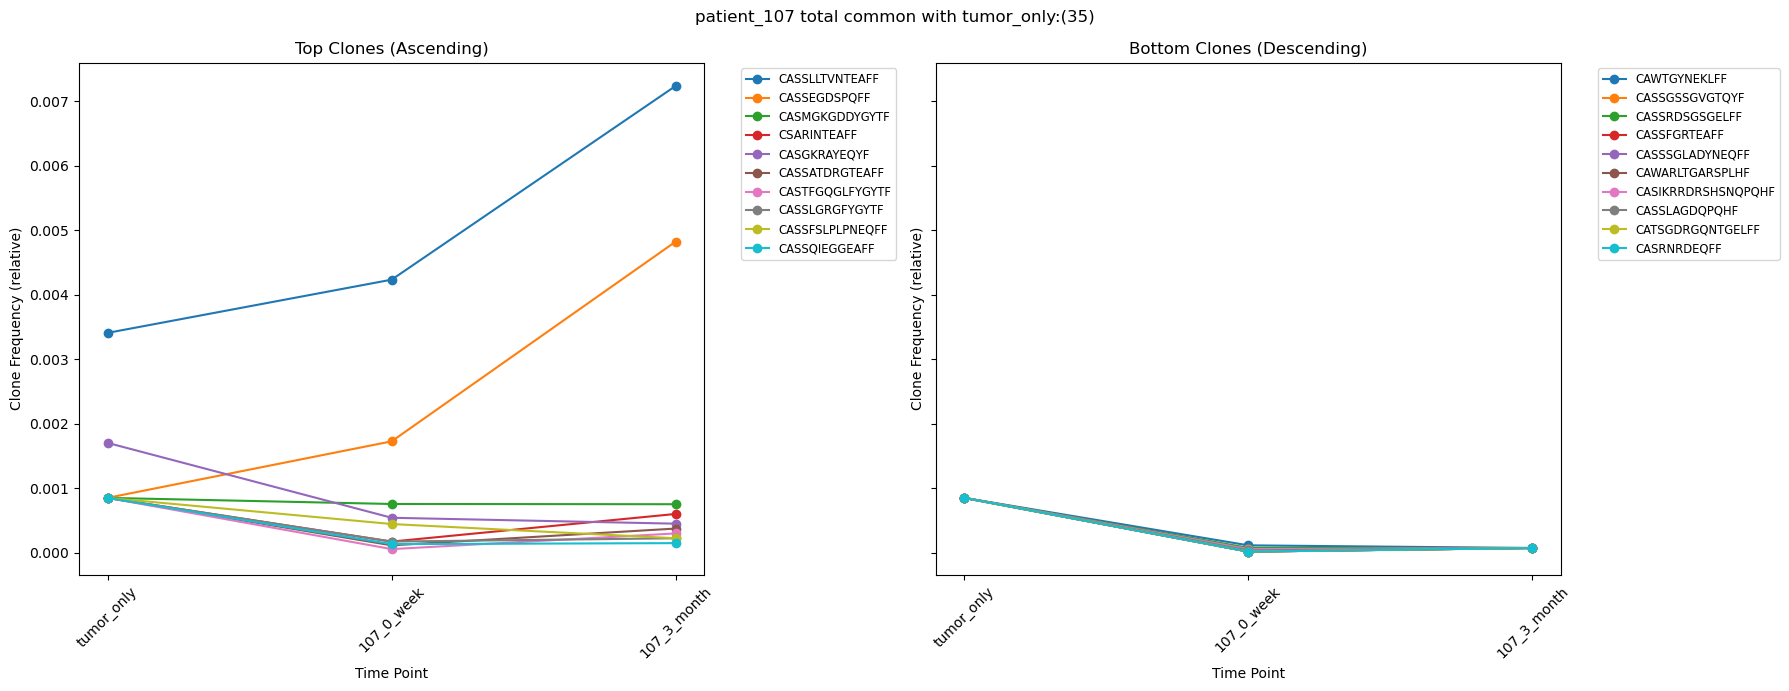

Common number of TCRs across all time points: 75
Common TCRs: 

CASSLQGTRTDTQYF CASSPRTGGKNEQFF CASSQRTGGKNEQFF CASSIGGQGYSNQPQHF CASTPLGQQRTGELFF CASSQTSGGASDTQYF CSARINTEAFF CASSPGWAKGGYTF CASSLPGFYGYTF CASSLGYEQYF CASSLRTGGGGYTF CSVRVNTEAFF CASREDSPTYGYTF CASSLVLGQAQETQYF CASSPRENTEAFF CASSFRDTNYNEQFF CASSYSGGEAFF CASSLWGTDNEQFF CASSLVWTGDNYGYTF CASSRDSGSGELFF CASSQDVGASEDNEQFF CASMGKGDDYGYTF CASSIGGNQPQHF CSADGAAVGQPQHF CASLPYTF CASSLGETQYF CASSLLTVNTEAFF CASSPGPYEQYF CASSPLGAGETQYF CASSPTSGGADEQFF CASSLYGDRAYEQYF CASSQADLVTYEQYF CASNDIDNSPLHF CASRAFVGTEAFF CASSEGDSPQFF CASSKESRFEAFF CASSRVNTEAFF CASSPQGGGYGYTF CASSRVSGEFTDTQYF CASIKRRDRSHSNQPQHF CASSLGTGGPSGNTIYF CSAGQLATSYNEQFF CASRNRDEQFF CASSYGVSGSTYEQYF CASSSPSGQGIEAFF CASSPGGNQPQHF CASSSGPGGYEQYF CASSRQGYEQYF CASSLGDTQYF CSARAPGQGNWGYGYEQYF CASTQGGTDTQYF CATLPNGGRVTEAFF CASSQGQGTEAFF CASTFGQGLFYGYTF CASSQEVQRGPRVNEQFF CASSNSIGTGSSYNEQFF CASSLEAGTVGVTGELFF CASSVQGNIQYF CASSLVTAGSSEAFF CASSLAPGQTRTPYEQYF CSARDVSPAGLYNEQFF CSGVP

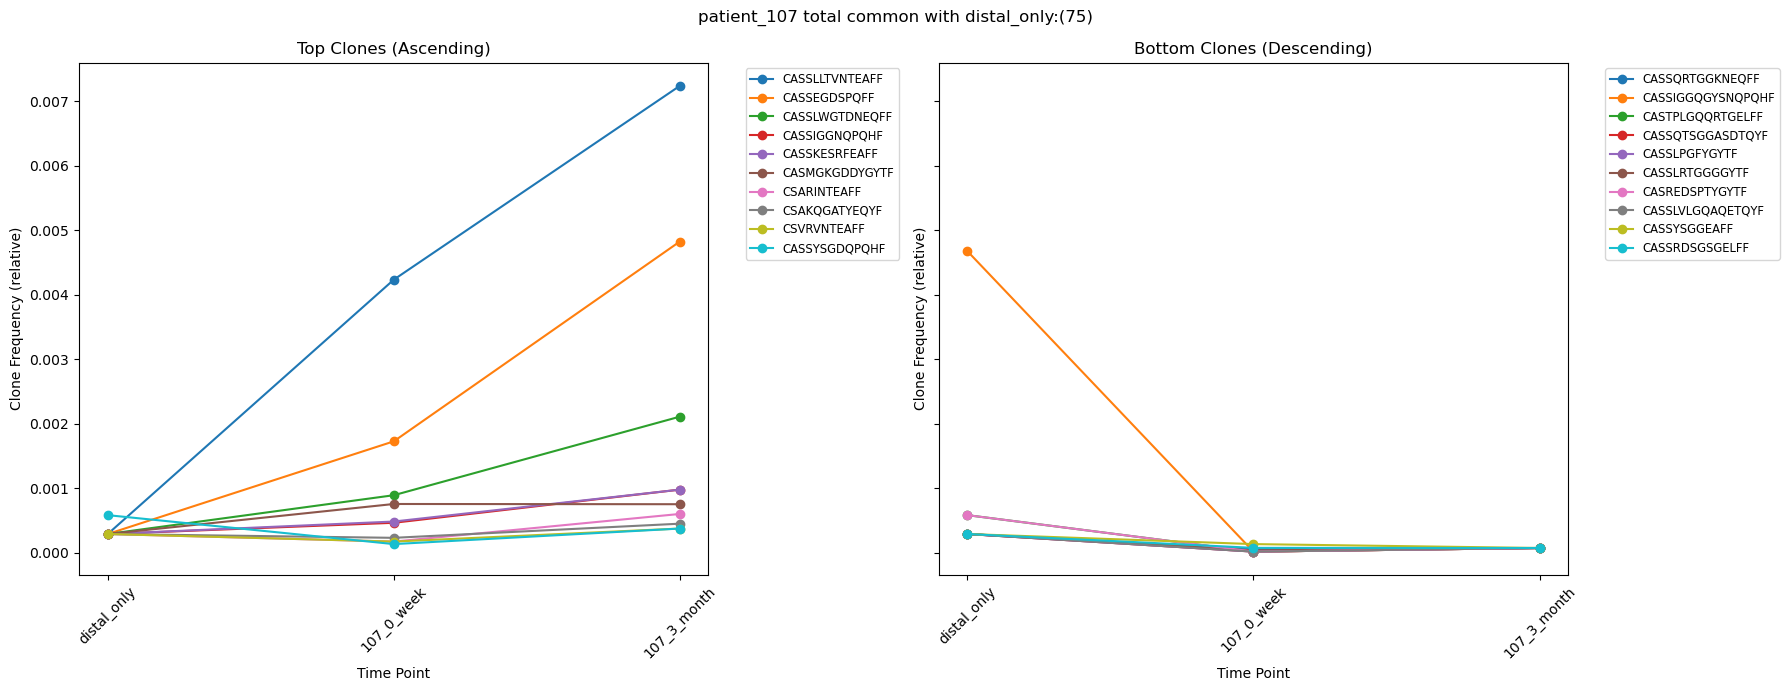

In [184]:
tumor_file = 'Thr_107_31626-3.igblast.airr.tsv'
nontumor_file = 'Thr_107_31626_1.igblast.airr.tsv'
distal_file = 'Thr_107_31627-1.igblast.airr.tsv'

time_files = [
    '107_0_week.igblast.airr.tsv',
    '107_3_month.igblast.airr.tsv'
]

tumor_cdr3 = read_cdr3_dict(dirpath + tumor_file)
nontumor_cdr3 = read_cdr3_dict(dirpath + nontumor_file)
distal_cdr3 = read_cdr3_dict(dirpath + distal_file)

patient_id = 'patient_107'

with open(f'{tcr_file_dir}/{patient_id}_tumor.txt', 'w') as f:
    for key in tumor_cdr3.keys():
        f.write(f"{key}\n")
        
tumor_only = {k: v for k, v in tumor_cdr3.items() if k not in nontumor_cdr3}
distal_only = {k: v for k, v in distal_cdr3.items() if k not in nontumor_cdr3}


time_cdr3 = []
for f in time_files:
    time_cdr3.append(read_cdr3_dict(dirpath + f))
#Find common number of clones over time with tumor
# get_common_clones_among_time([tumor_only] + time_cdr3)

#plot venn diagram for tumor, normal and distal
plot_venn3(tumor_cdr3, nontumor_cdr3, distal_cdr3, patient_id = patient_id)
#Venn over time for Distal file
plot_venn_over_time(tumor_only, time_files, dirpath, set1_title = 'Tumor Only', patient_id = patient_id, cols=4)
#Venn over time for Tumor File
plot_venn_over_time(distal_only, time_files, dirpath, set1_title = 'Distal Only', patient_id = patient_id, cols=4)

## Plot Top and Bottom Common CDR3's
time_labels = ['tumor_only'] + [t_name.split('.')[0] for t_name in time_files]
plot_top_bottom_clonotypes([tumor_only] + time_cdr3, time_labels, patient_id = patient_id, N=10)

## Plot Top and Bottom Common CDR3's
time_labels = ['distal_only'] + [t_name.split('.')[0] for t_name in time_files]
plot_top_bottom_clonotypes([distal_only] + time_cdr3, time_labels, patient_id = patient_id, N=10)

# keep_keys = tumor_cdr3.keys() - nontumor_cdr3.keys()
# keep_keys = tumor_cdr3.keys() & distal_cdr3.keys()

# print("Keeping: ", len(keep_keys))
# only_tumors = {key: tumor_cdr3[key] for key in keep_keys}
# keep_keys = distal_cdr3.keys() - nontumor_cdr3.keys()

# print("Keeping: ", len(keep_keys))
# only_distal = {key: distal_cdr3[key] for key in keep_keys}
# time_cdr3 = [only_distal]


# for f in time_files:
#     time_cdr3.append(read_cdr3_dict(dirpath + f))
# #
# # tumor-associated CDR3s
# #



# A = set(tumor_cdr3.keys())
# B = set(nontumor_cdr3.keys())
# venn_cdr3("tumor", A, "non-tumor", B)
# TMNT = A - B

# i = 0
# time_set = []
# for i, f in enumerate(time_cdr3):
#     X = set(f.keys())
#     venn_cdr3("TMNT", TMNT, "time " + str(i), X)
#     time_set.append(TMNT & X)

# X = time_set[0] & time_set[1] & time_set[2] 
# venn_cdr3("TMNT", TMNT, "all time", X)
# # Get total number of common clones in all times shared with Tumor
# get_common_clones_among_time(time_cdr3)


# plot_venn3(tumor_cdr3, nontumor_cdr3, distal_cdr3, patient_id = 'Patient 107')

# ## Plot Top and Bottom Common CDR3's
# time_labels = ['Tumor Baseline'] +[t_name.split('.')[0] for t_name in time_files]
# plot_top_bottom_clonotypes(time_cdr3, time_labels, time_idx=0, N=15)

## Looking at Clonotype Overlap Uisng Jaccard and Morisita Horn Patient 107

In [23]:
for i in range(1, len(time_cdr3)):
    overlap_jaccard = jaccard_index(time_cdr3[0], time_cdr3[i])
    overlap_mh = morisita_horn_index(time_cdr3[0], time_cdr3[i])
    print(f"\nOverlap in time {i}\n")
    print(f"Jaccard: {overlap_jaccard:.3f}")
    print(f"Morisita-Horn: {overlap_mh:.3f}")
    print()



Overlap in time 1

Jaccard: 0.010
Morisita-Horn: 0.003


Overlap in time 2

Jaccard: 0.014
Morisita-Horn: 0.004



## IEDB TCRMatch Output for All Tumor Including the ones Shared with Non-Tumor CDR3's

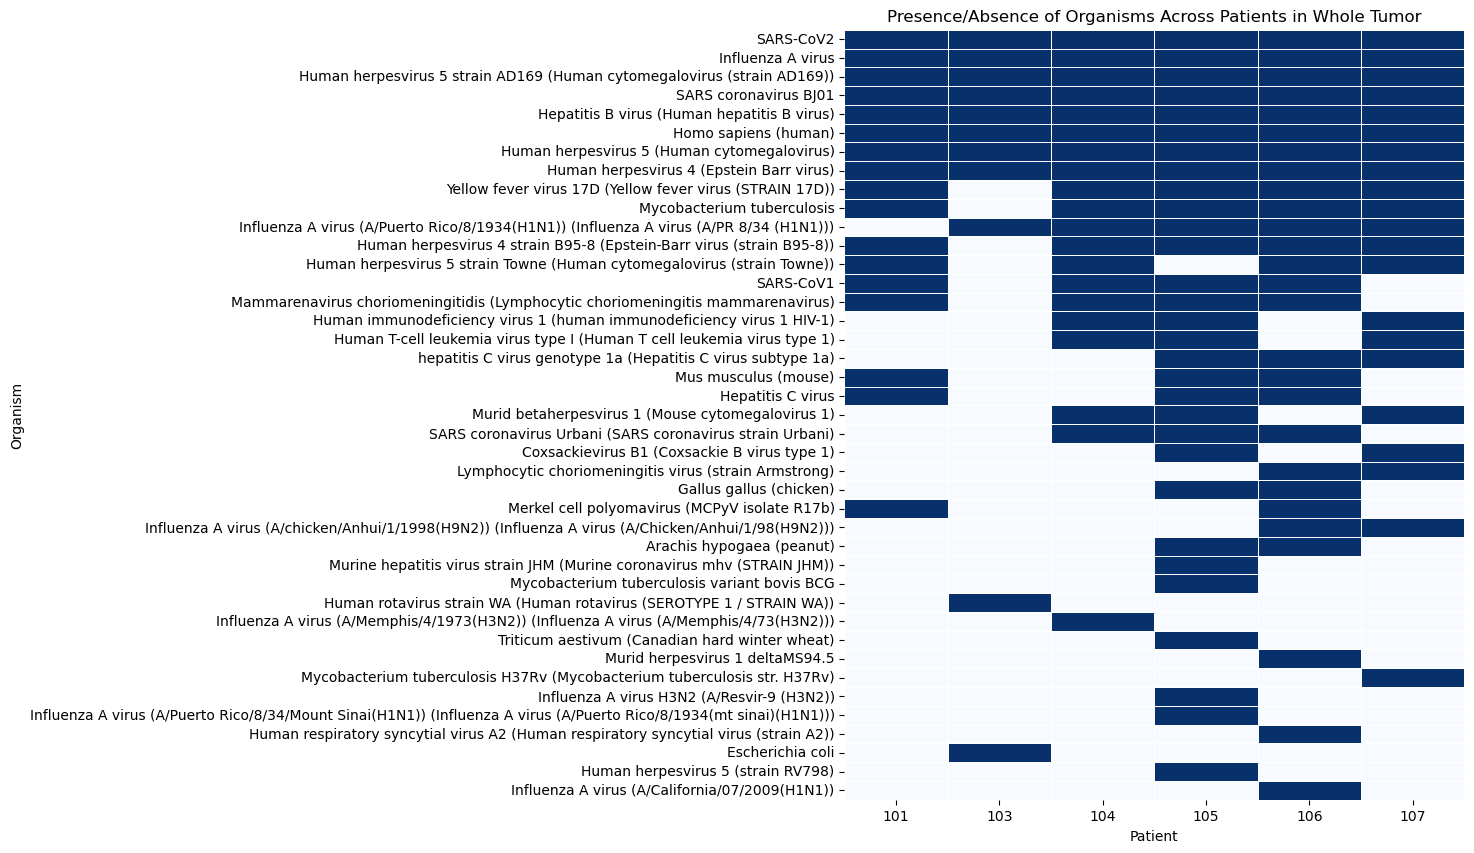

In [55]:
cedar_output_tumor = {}
for pid in [101, 103, 104, 105, 106, 107]:
    df = pd.read_csv(f'./TCROutput/patient_{pid}_tumor_tcrmatch.tsv', sep = '\t')
    df.dropna(axis = 0, inplace = True)
    organism_list = []
    for item in df.organism.str.split(',').values:
        item = set(item)
        organism_list += item
    cedar_output_tumor[pid] = set(organism_list)
cedar_output_tumor

## Heatmap of Common CDR3's in 3 Months
all_organisms = set().union(*cedar_output_tumor.values())
all_organisms
df = pd.DataFrame(index = list(all_organisms))
for patient, organisms in cedar_output_tumor.items():
    df[patient] = df.index.isin(organisms).astype(int)

# Count the number of values in each row
row_counts = df.sum(axis=1)
# Sort the DataFrame by these counts
df = df.loc[row_counts.sort_values(ascending=False).index]

plt.figure(figsize=(8,10))
sns.heatmap(df, cmap="Blues", cbar=False, linewidths=0.5)
plt.xlabel('Patient')
plt.ylabel('Organism')
plt.title('Presence/Absence of Organisms Across Patients in Whole Tumor')
plt.savefig('Figures/tcrmatch_whole_tumor.png', bbox_inches = 'tight', dpi = 300)
plt.show()

## TCR Match Output In comparison with 3 Months

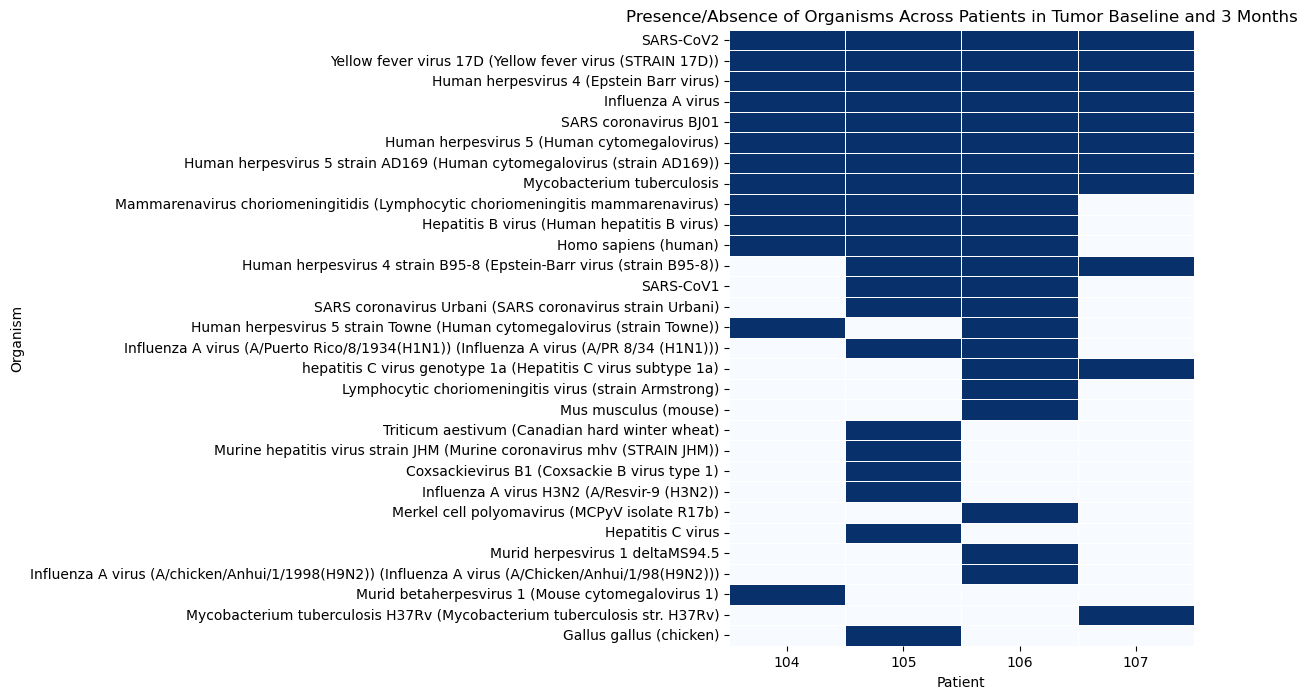

In [54]:
cedar_output_tumor_3_month = {}
for pid in [104, 105, 106, 107]:
    df = pd.read_csv(f'/home/s234499/Work/hannan-lab-projects/abscopal/TCROutput/patient_{pid}_common_tumor_3_months_tcrmatch.tsv', sep = '\t')
    df.dropna(axis = 0, inplace = True)
    organism_list = []
    for item in df.organism.str.split(',').values:
        item = set(item)
        organism_list += item
    cedar_output_tumor_3_month[pid] = set(organism_list)
cedar_output_tumor_3_month

## Heatmap of Common CDR3's in 3 Months
all_organisms = set().union(*cedar_output_tumor_3_month.values())
all_organisms
df = pd.DataFrame(index = list(all_organisms))
for patient, organisms in cedar_output_tumor_3_month.items():
    df[patient] = df.index.isin(organisms).astype(int)
    
# Count the number of values in each row
row_counts = df.sum(axis=1)
# Sort the DataFrame by these counts
df = df.loc[row_counts.sort_values(ascending=False).index]

plt.figure(figsize=(6,8))
sns.heatmap(df, cmap="Blues", cbar=False, linewidths=0.5)
plt.xlabel('Patient')
plt.ylabel('Organism')
plt.title('Presence/Absence of Organisms Across Patients in Tumor Baseline and 3 Months')
plt.savefig('Figures/tcrmatch_tumor_baseline_and_3_months.png', bbox_inches = 'tight', dpi = 300)
plt.show()

## Common TCR in All Time Files

                                                    104  105  106  107
SARS-CoV2                                             1    1    1    1
Yellow fever virus 17D (Yellow fever virus (STR...    1    1    1    1
Influenza A virus (A/Memphis/4/1973(H3N2)) (Inf...    1    0    0    0
SARS coronavirus BJ01                                 1    1    1    1
Homo sapiens (human)                                  1    0    0    0


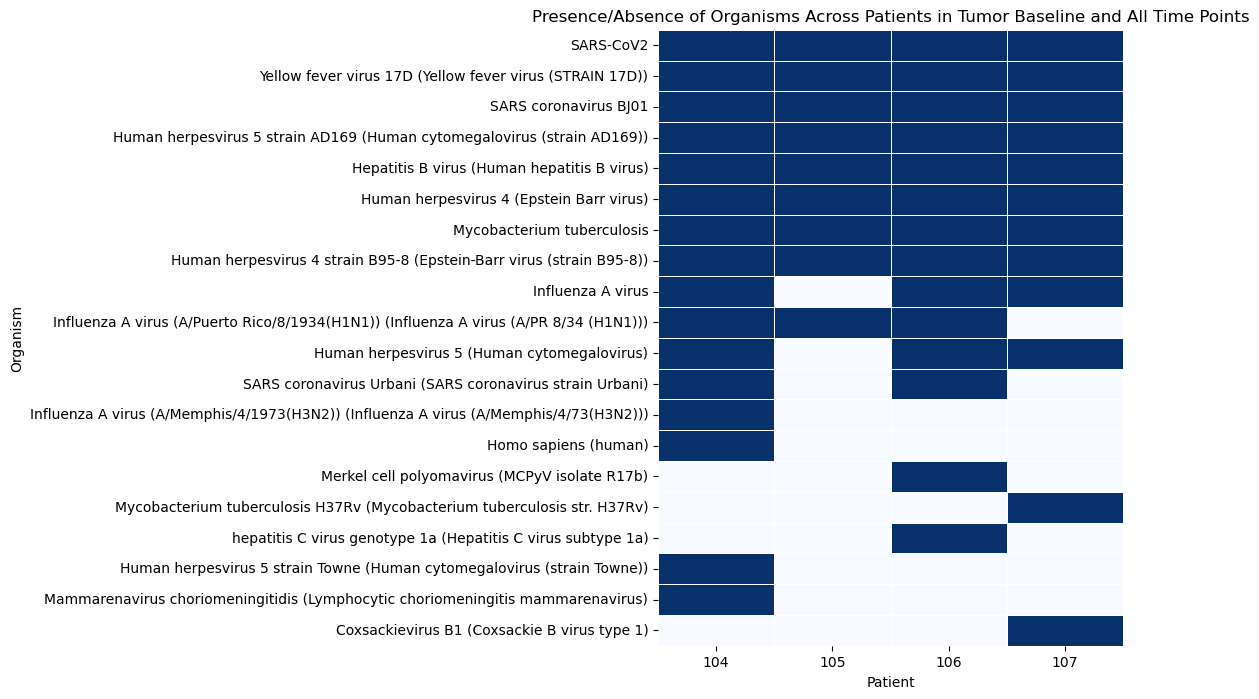

In [53]:
cedar_output = {}
for pid in [104, 105, 106, 107]:
    df = pd.read_csv(f'./TCROutput/patient_{pid}_common_tcr.tsv', sep = '\t')
    df.dropna(axis = 0, inplace = True)
    organism_list = []
    for item in df.organism.str.split(',').values:
        item = set(item)
        organism_list += item
    cedar_output[pid] = set(organism_list)
cedar_output

# Combine all unique organisms
all_organisms = set().union(*cedar_output.values())

# Create DataFrame
df = pd.DataFrame(index=list(all_organisms))

for patient, organisms in cedar_output.items():
    df[patient] = df.index.isin(organisms).astype(int)
print(df.head())

# Count the number of values in each row
row_counts = df.sum(axis=1)
# Sort the DataFrame by these counts
df = df.loc[row_counts.sort_values(ascending=False).index]

plt.figure(figsize=(6,8))
sns.heatmap(df, cmap="Blues", cbar=False, linewidths=0.5)
plt.xlabel('Patient')
plt.ylabel('Organism')
plt.title('Presence/Absence of Organisms Across Patients in Tumor Baseline and All Time Points')
plt.savefig('Figures/tcrmatch_tumor_baseline_and_all_time_points.png', bbox_inches = 'tight', dpi = 300)
plt.show()

## Each Patinet Common TCR Over Time

104 baseline 
     trimmed_input_sequence match_sequence     score  receptor_group  \
70             ASSLGSQETQY    ASSVGSQETQY  0.980134           28009   
114           ASSPGQGAETQY   ASSPGQGAETLY  0.970709          187157   

       epitope antigen organism  
70   ILTGLNYEV     NaN      NaN  
114  KYNKANVFL     NaN      NaN  
104 
 ASSLGSQETQY ASSPGQGAETQY
104 lung_biopsy 
    trimmed_input_sequence match_sequence  score  receptor_group     epitope  \
19           ASSPGTGPYEQY   ASSPGTGPYEQY    1.0           27027  GIAARVKNWL   

   antigen organism  
19     NaN      NaN  
104 
 ASSPGTGPYEQY
104 O_weeks 
 Empty DataFrame
Columns: [trimmed_input_sequence, match_sequence, score, receptor_group, epitope, antigen, organism]
Index: []
104 
 
104 5_weeks 
 Empty DataFrame
Columns: [trimmed_input_sequence, match_sequence, score, receptor_group, epitope, antigen, organism]
Index: []
104 
 
104 5_weeks_2 
 Empty DataFrame
Columns: [trimmed_input_sequence, match_sequence, score, receptor_grou

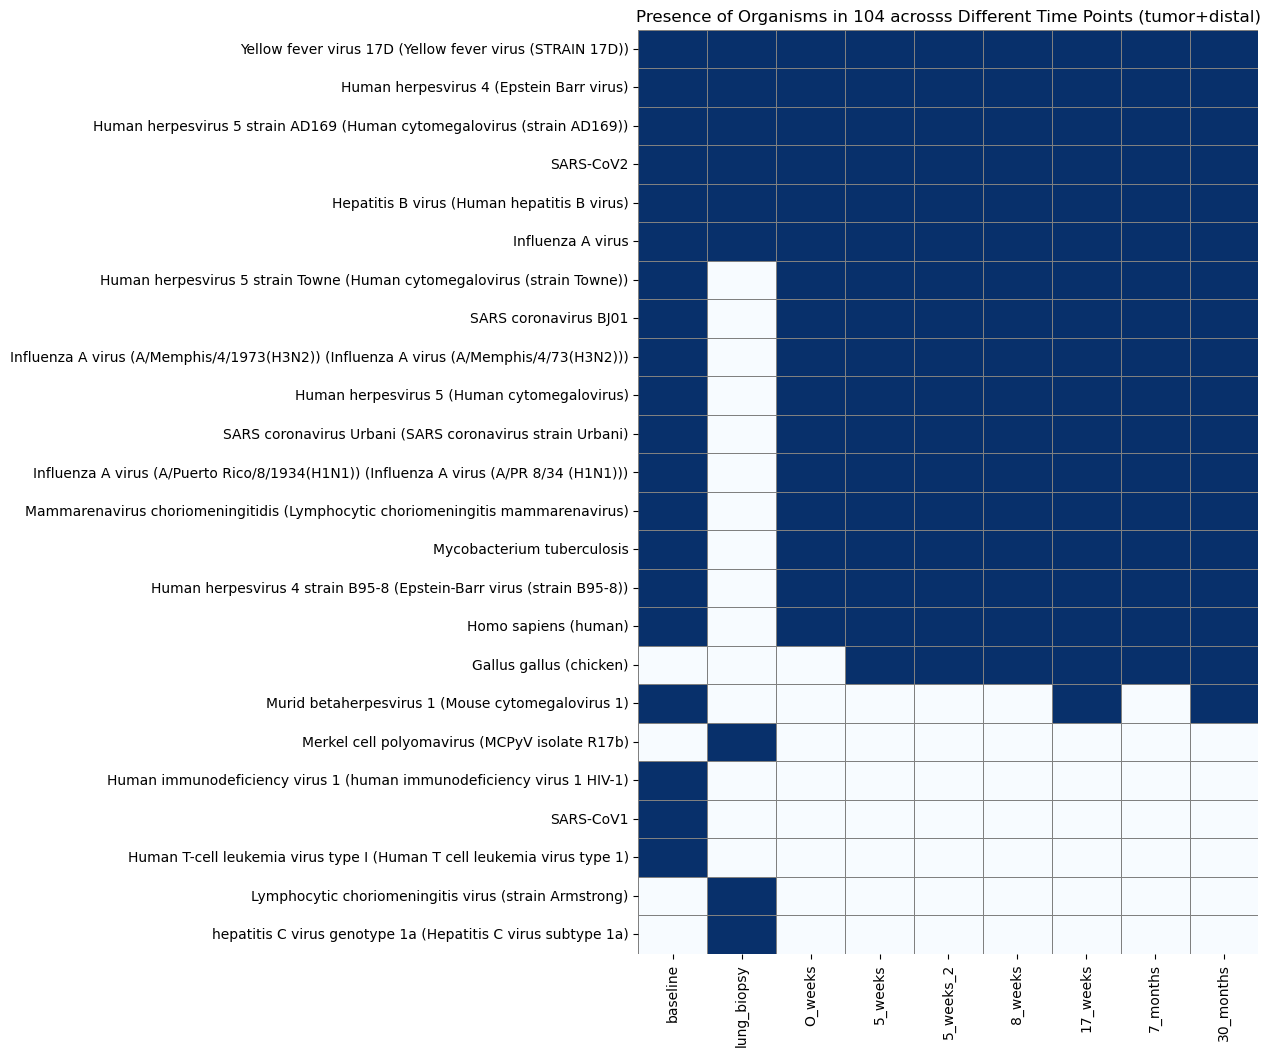

105 baseline 
     trimmed_input_sequence match_sequence     score  receptor_group  \
7              ASGGQLNTEAF    ASSGQLNTEAF  0.970745           29634   
76             ASSDYSNQPQH    ASSDYSNQPQH  1.000000           17935   
92              ASSEGPSGYT     ASSEGPSGYT  1.000000           16111   
114          ASSFGTSSTDTQY  ASSLGTSSTDTQY  0.973020           28507   
176              ASSIGYEQY      ASSMGYEQY  0.971455          187332   
205          ASSLAGLAGKTQY  ASSLAGLAGETQY  0.974493          189037   
228             ASSLDRETQY     ASSLERETQY  0.970671          197177   
245          ASSLGAGGAYEQY  ASSLGAGGSYEQY  0.978434           29806   
253            ASSLGGAQPQH    ASSLGGAQPQH  1.000000          189213   
272            ASSLGGGTEAF    ASSLGGGTEVF  0.982260          187264   
339          ASSLGSGSTDTQY  ASSFGSGSTDTQY  0.971626          199084   
340          ASSLGSGSTDTQY  ASSLGTGSTDTQY  0.978853          199192   
490           ASSPGPLNTEAF   ASSPGPLNTEAF  1.000000           

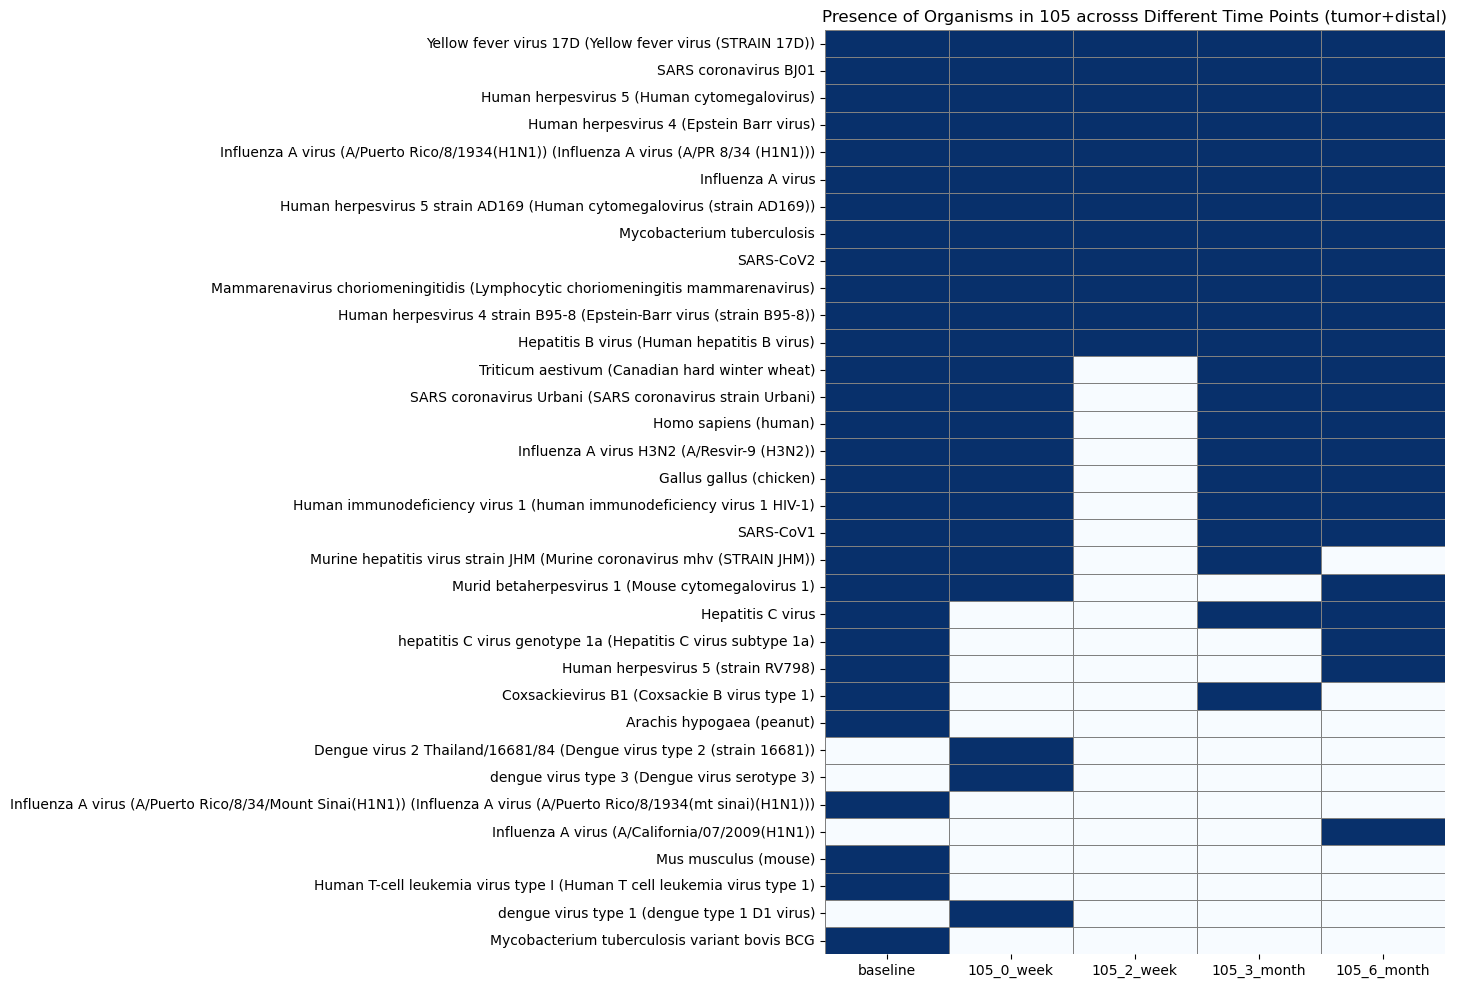

106 baseline 
      trimmed_input_sequence match_sequence     score  receptor_group  \
46                ASSADYEQY      ASSSDYEQY  0.979065          187370   
51              ASSAGEGTEAF    ASSVGEGTEAF  0.973162           28120   
80               ASSEGNTEAF     ASSEGNTEVF  0.981225          187006   
133              ASSFSGDEQF     ASSYSGDEQF  0.974500           30025   
195             ASSISGGETQY    ASSISGGDTQY  0.972862          187207   
271            ASSLASQTETQY   ASSLASQVETQY  0.971415           28394   
315             ASSLGGGYEQY    ASSVGGGYEQY  0.977956           28480   
457             ASSLQGTYEQY    ASSLQGSYEQY  0.976751           28875   
611               ASSMGYEQY      ASSMGYEQY  1.000000          187332   
627            ASSPGPLNTEAF   ASSPGPLNTEAF  1.000000           29684   
634               ASSPGREQF      ASSPGREQY  0.988448          187162   
672             ASSPTGNTEAF    ASTPTGNTEAF  0.982071           25117   
675            ASSQAGGTGELF   ASSQAGGTGELF  1.000

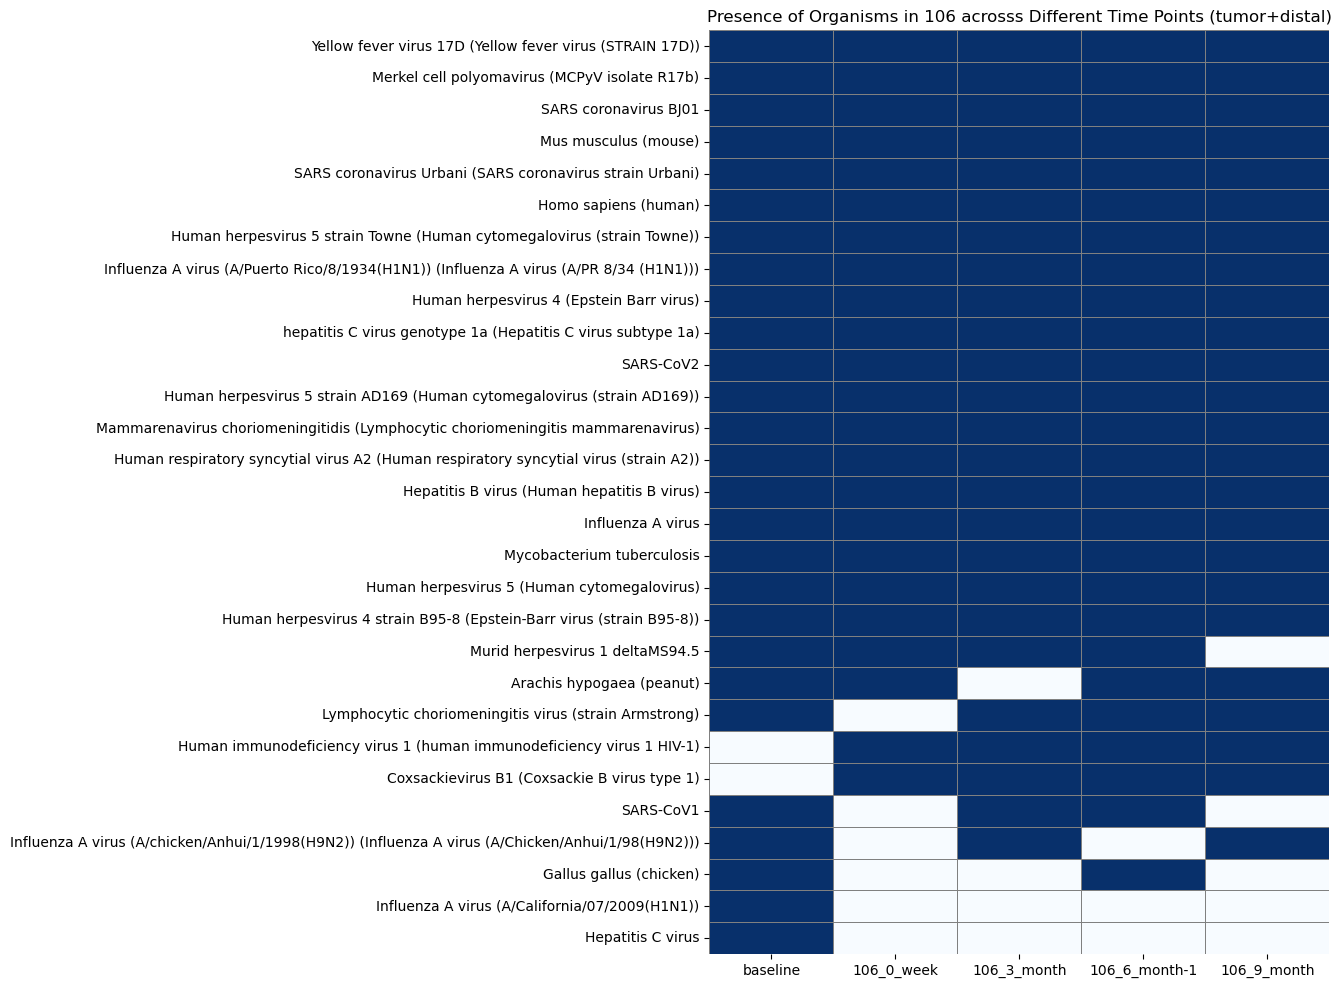

107 baseline 
     trimmed_input_sequence match_sequence     score  receptor_group  \
141           ASSLDWGTYEQY   ASSLDWGSYEQY  0.971976          187236   
169            ASSLGMNTEAF    ASSLGINTEAF  0.971574          189375   
373            ASSSRSTDTQY    ASSTRSTDTQY  0.982198           29797   
394           ASSSSGGADTQY    ASSSGGADTQY  0.976466          187374   
400             ASSSSTDTQY      ASSSTDTQY  0.978757          190954   
456               SAGDGEQF       ASGDGEQY  0.970346          186783   

        epitope antigen organism  
141   KYNKANVFL     NaN      NaN  
169  ELAGIGILTV     NaN      NaN  
373  ELAGIGILTV     NaN      NaN  
394   KYNKANVFL     NaN      NaN  
400  ELAGIGILTV     NaN      NaN  
456   KYNKANVFL     NaN      NaN  
107 
 ASSLDWGTYEQY ASSLGMNTEAF ASSSRSTDTQY ASSSSGGADTQY ASSSSTDTQY SAGDGEQF
107 107_0_week 
     trimmed_input_sequence match_sequence     score  receptor_group  \
50              ASSPSGNEQF     ASSPTGNEQF  0.976418           28272   
117    

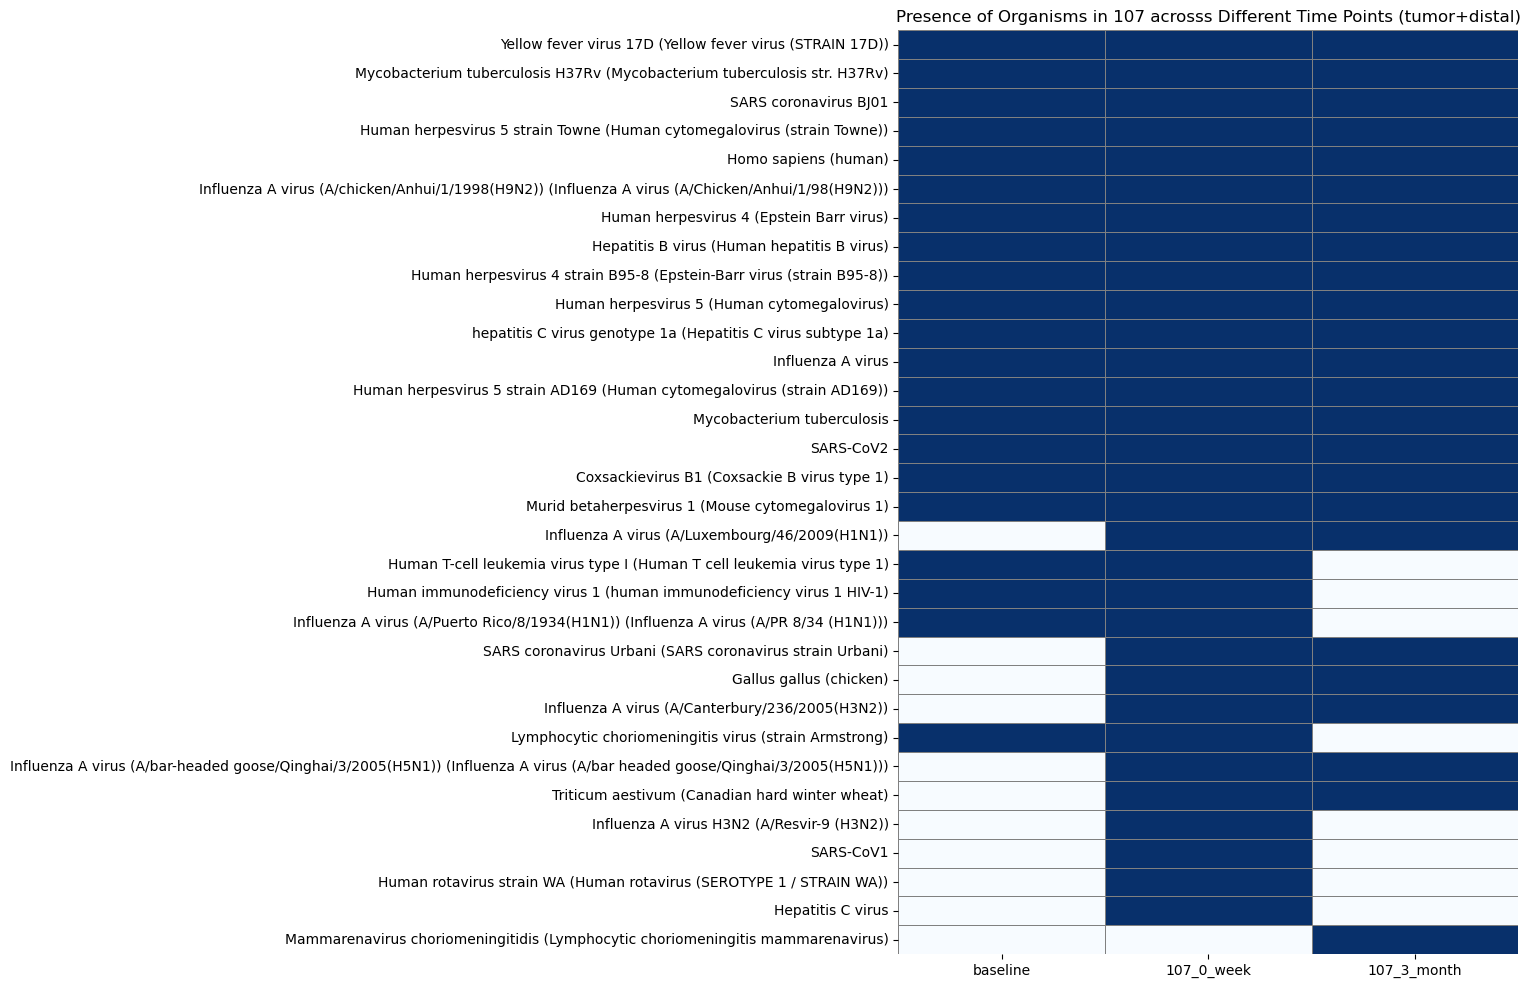

In [24]:
all_na_sequences = {}
for patient_id in [104, 105, 106, 107]:
    patient_info = all_patient_files[patient_id]
    cedar_output = {}
    for file in ['baseline'] + patient_info[3:]:
        sample = file.split('.')[0]
        df = pd.read_csv(f'./TCROutput/{patient_id}_{sample}_common_tumor_tcrmatch.tsv', sep = '\t')
        print(patient_id, sample, '\n', df[df.isna().any(axis=1)])
        print(patient_id, '\n', ' '.join([seq for seq in df[df.isna().any(axis=1)]['trimmed_input_sequence'].values]))
        all_na_sequences.update([seq for seq in df[df.isna().any(axis=1)]['trimmed_input_sequence'].values])
        df.dropna(axis = 0, inplace = True)
        organism_list = []
        for item in df.organism.str.split(',').values:
            item = set(item)
            organism_list += item
        cedar_output[sample] = set(organism_list)
    cedar_output
    
    # Combine all unique organisms
    all_organisms = set().union(*cedar_output.values())
    
    # Create DataFrame
    df = pd.DataFrame(index=list(all_organisms))
    
    for patient, organisms in cedar_output.items():
        df[patient] = df.index.isin(organisms).astype(int)
    # print(df.head())
    
    # Count the number of values in each row
    row_counts = df.sum(axis=1)
    # Sort the DataFrame by these counts
    df = df.loc[row_counts.sort_values(ascending=False).index]
    
    plt.figure(figsize=(8,12))
    plt.title(f'Patient_{patient_id}')
    plt.title(f'Presence of Organisms in {patient_id} acrosss Different Time Points (tumor+distal)')
    sns.heatmap(df, cmap="Blues", cbar=False, linewidths=0.7, linecolor = 'gray')
    plt.savefig(f'Figures/{patient_id}_tcrmatch_over_time_for_each_patient.png', bbox_inches = 'tight', dpi = 300)
    plt.show()

In [27]:
len(all_na_sequences)
print(' '.join([seq for seq in all_na_sequences]))

ASSYGQGSYEQY SARVTSGSYEQY ASSEGPSGYT ASSFGTSSTDTQY ASSQAGGTGELF ASSLGSQETQY ASSSSSGANVLT ASSLSTEAF ASSSRSTDTQY ASSLGSGSTDTQY ASSSGGADTQY ASSLGGAQPQH ASSSQETQY ASSFSGDEQF ASSYLGDEQF ATSAGDTEAF ASSLSNQPQH ASSLQGTYEQY ASSPLGDTQY ASSLGGGTEAF ASSLDRETQY ASSMGYEQY ASSQGYEQY ASSAGEGTEAF ASSSQGGYGYT ASSWMNTEAF SAGDGEQF ASSSSGGADTQY ASSLGAGGAYEQY ASSPGREQF ASSLGYEQY ASSLGMNTEAF ASSLDWGTYEQY ASSADYEQY ASSQGVYEQY ASSIGYEQY ASSPGTGPYEQY ASSQGSLNTGELF ASSQGSDEQY ASSLSGGTEAF ASGGQLNTEAF ASSPGRTQY ASSQGGGGQF ASSSSTDTQY ASSDYSNQPQH ASSLAGLAGKTQY ASSEGNTEAF ASSLASQTETQY ASSPTLGSSYEQY ASSLGGGYEQY ASSPTGNTEAF ASSQVSNYGYT ASSPGQGAETQY ASSQGTGAYEQY ASSYSNTEAF ASSPGPLNTEAF ASSISGGETQY ASSSGGYNEQF ASSYGQGYEQY ASSPSGNEQF ASSSSGGLNEKLF ASSQGQMNTEAF ASSLGLNTEAF


Total Lung CDR3:  104
   trimmed_input_sequence match_sequence  score  receptor_group     epitope  \
19           ASSPGTGPYEQY   ASSPGTGPYEQY    1.0           27027  GIAARVKNWL   

   antigen organism  
19     NaN      NaN  
   trimmed_input_sequence match_sequence  score  receptor_group     epitope  \
19           ASSPGTGPYEQY   ASSPGTGPYEQY    1.0           27027  GIAARVKNWL   

   antigen organism  
19     NaN      NaN  
   trimmed_input_sequence match_sequence  score  receptor_group     epitope  \
11           ASSPGTGPYEQY   ASSPGTGPYEQY    1.0           27027  GIAARVKNWL   

   antigen organism  
11     NaN      NaN  
Empty DataFrame
Columns: [trimmed_input_sequence, match_sequence, score, receptor_group, epitope, antigen, organism]
Index: []
Empty DataFrame
Columns: [trimmed_input_sequence, match_sequence, score, receptor_group, epitope, antigen, organism]
Index: []
Empty DataFrame
Columns: [trimmed_input_sequence, match_sequence, score, receptor_group, epitope, antigen, organism

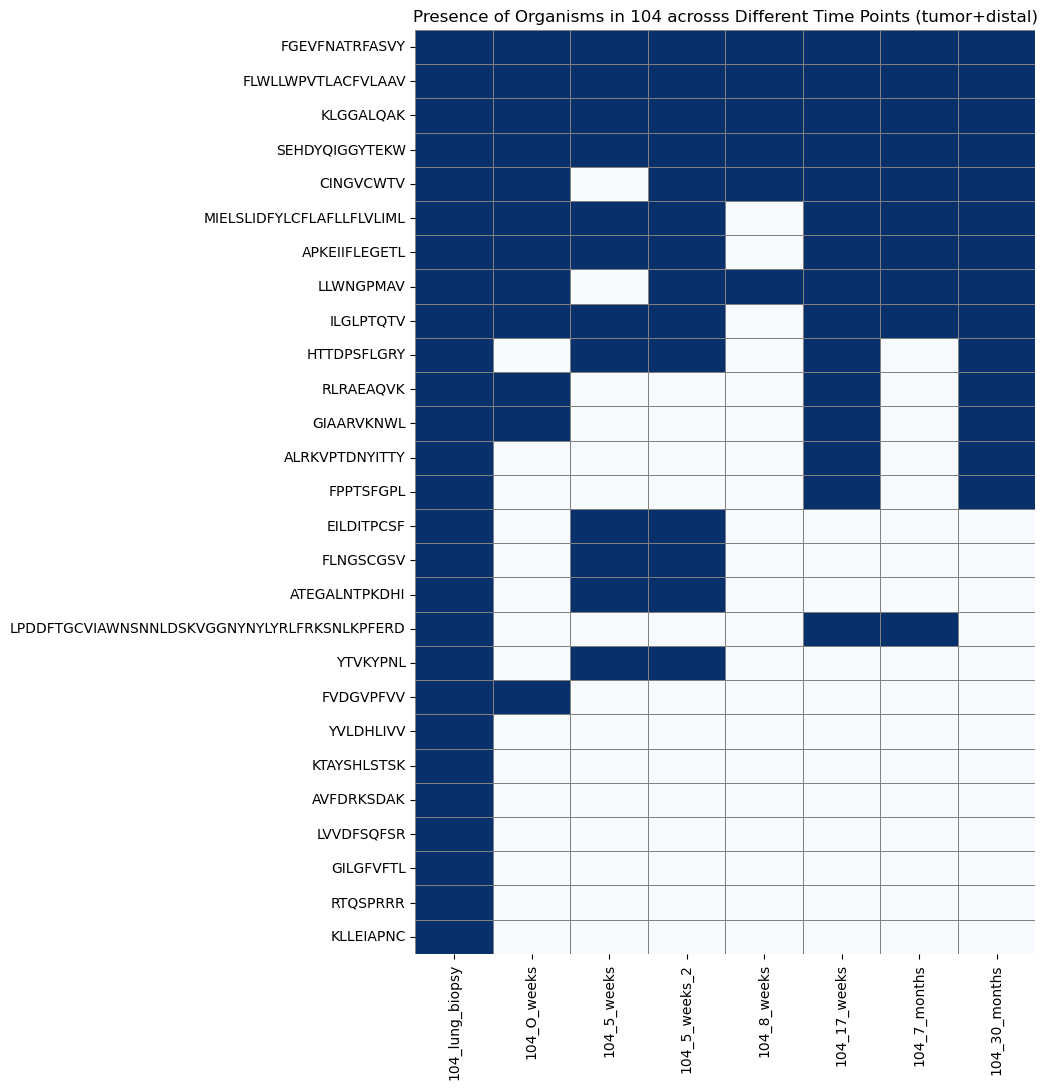

In [7]:


all_patient_files = {101: ['Thr_101_25516-1', 'Thr_101_25519-1', 'Thr_101_25516_9'],
 103: ['Thr_103_26277_1', 'Thr_103_26276-1', 'Thr_103_26277_3'],
 104: ['24673-6', '26473-1', '24563-5', 'lung_biopsy', 'O_weeks', '5_weeks', '5_weeks_2', '8_weeks', '17_weeks', '7_months', '30_months'],
 105: ['Thr_105_28473_3', 'Thr_105_28473_2H', 'Thr_105_28474-4', '105_0_week', '105_2_week', '105_3_month', '105_6_month'],
 106: ['Thr_106_30817-2', 'Thr_106_30818_1', 'Thr_106_30817_1', '106_0_week', '106_3_month', '106_6_month-1', '106_9_month'],
 107: ['Thr_107_31626-3', 'Thr_107_31627-1', 'Thr_107_31626_1', '107_0_week', '107_3_month']}

lung_file = "022015-058-7.igblast.airr.tsv"
patient_id = 104
patient_info = all_patient_files[patient_id]
lung_cdr3 =  read_cdr3_dict(f'{dirpath}{lung_file}')
print("Total Lung CDR3: ", len(lung_cdr3))
cedar_output = {}

patient_info = all_patient_files[patient_id]
for file in ['lung_biopsy'] + patient_info[3:]:
    sample = file.split('.')[0]
    df = pd.read_csv(f'./TCROutput/{patient_id}_{sample}_common_lung_tcrmatch.tsv', sep = '\t')
    # print(df)
    # df.dropna(axis = 0, inplace = True)
    print(df[df.isna().any(axis=1)])
    # print(df.shape)
    organism_list = []
    for item in df.epitope.str.split(',').values:
        item = set(item)
        # print(item)
        organism_list += item
    cedar_output[f'{patient_id}_{sample}'] = set(organism_list)
cedar_output
    
# Combine all unique organisms
all_organisms = set().union(*cedar_output.values())

# Create DataFrame
df = pd.DataFrame(index=list(all_organisms))

for patient, organisms in cedar_output.items():
    df[patient] = df.index.isin(organisms).astype(int)
# print(df.head())

# Count the number of values in each row
row_counts = df.sum(axis=1)
# Sort the DataFrame by these counts
df = df.loc[row_counts.sort_values(ascending=False).index]

plt.figure(figsize=(8,12))
plt.title(f'Patient_{patient_id}')
plt.title(f'Presence of Organisms in {patient_id} acrosss Different Time Points (tumor+distal)')
sns.heatmap(df, cmap="Blues", cbar=False, linewidths=0.7, linecolor = 'gray')
# plt.savefig(f'Figures/lung_biopsy_tcrmatch_over_time.png', bbox_inches = 'tight', dpi = 300)
plt.show()

## Combine all TIme all Patient Output Together

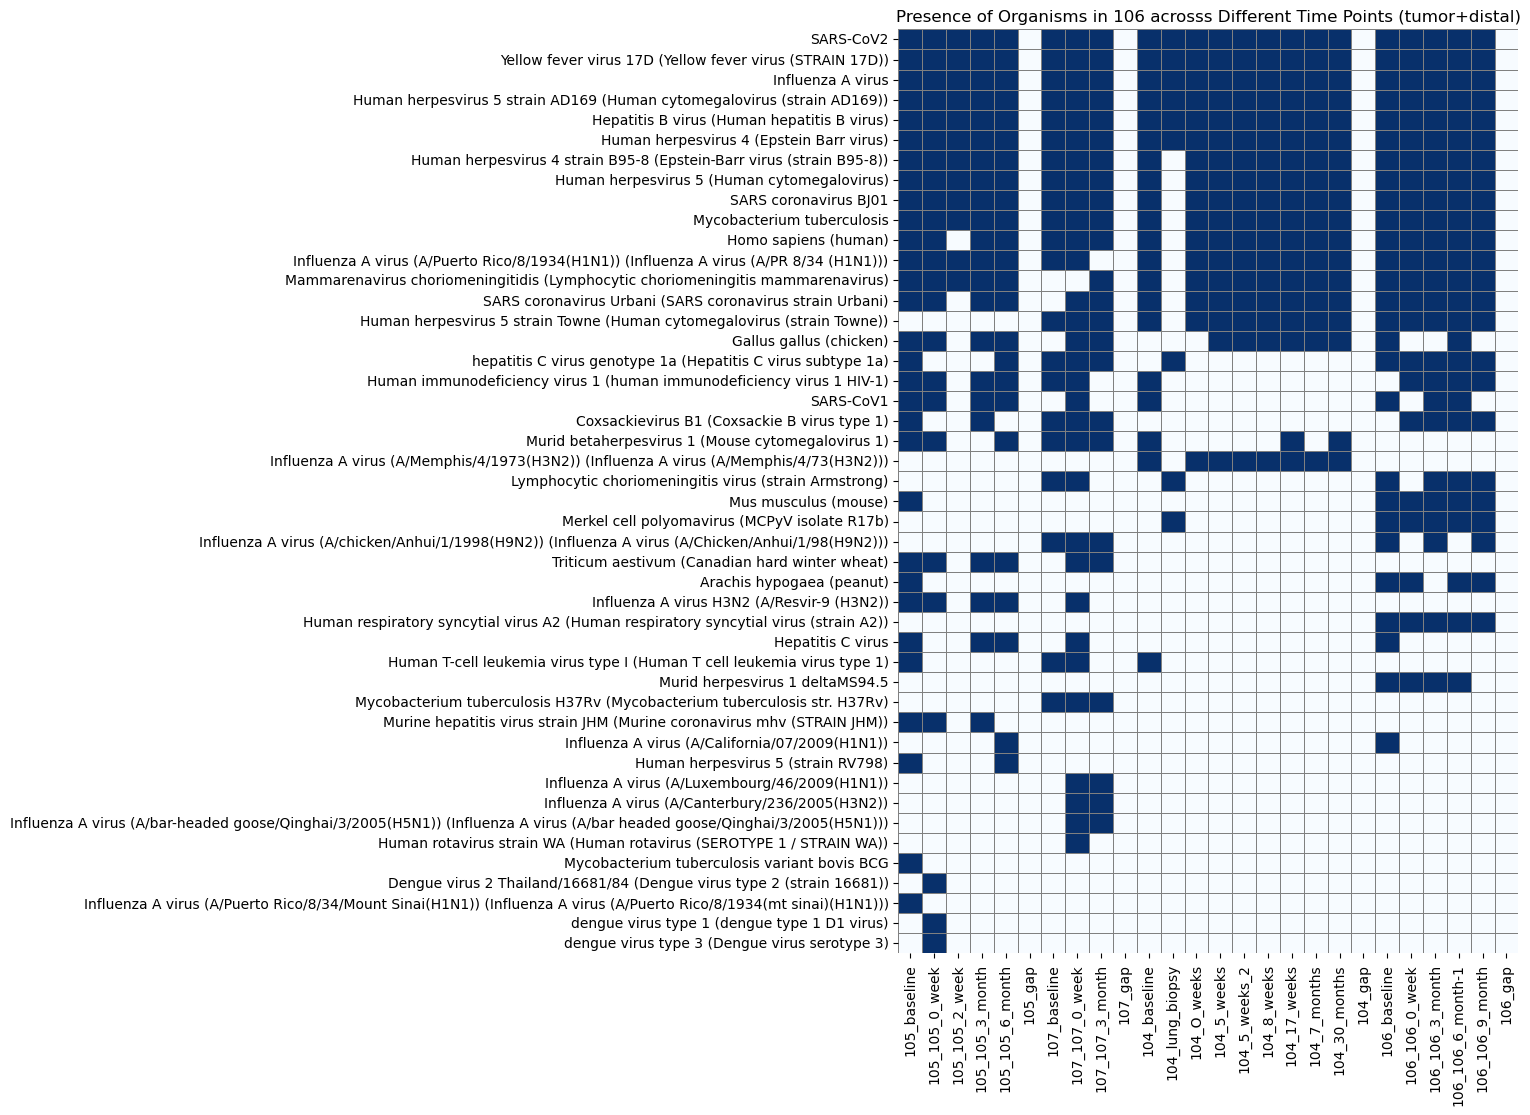

In [285]:
all_patient_files = {101: ['Thr_101_25516-1', 'Thr_101_25519-1', 'Thr_101_25516_9'],
 103: ['Thr_103_26277_1', 'Thr_103_26276-1', 'Thr_103_26277_3'],
 104: ['24673-6', '26473-1', '24563-5', 'lung_biopsy', 'O_weeks', '5_weeks', '5_weeks_2', '8_weeks', '17_weeks', '7_months', '30_months'],
 105: ['Thr_105_28473_3', 'Thr_105_28473_2H', 'Thr_105_28474-4', '105_0_week', '105_2_week', '105_3_month', '105_6_month'],
 106: ['Thr_106_30817-2', 'Thr_106_30818_1', 'Thr_106_30817_1', '106_0_week', '106_3_month', '106_6_month-1', '106_9_month'],
 107: ['Thr_107_31626-3', 'Thr_107_31627-1', 'Thr_107_31626_1', '107_0_week', '107_3_month']}

cedar_output = {}
for patient_id in [105, 107, 104, 106]:
    patient_info = all_patient_files[patient_id]
    for file in ['baseline'] + patient_info[3:]:
        sample = file.split('.')[0]
        df = pd.read_csv(f'./TCROutput/{patient_id}_{sample}_common_tumor_tcrmatch.tsv', sep = '\t')
        df.dropna(axis = 0, inplace = True)
        organism_list = []
        for item in df.organism.str.split(',').values:
            item = set(item)
            organism_list += item
        cedar_output[f'{patient_id}_{sample}'] = set(organism_list)
    cedar_output[f'{patient_id}_gap'] = set()
    cedar_output
    
# Combine all unique organisms
all_organisms = set().union(*cedar_output.values())

# Create DataFrame
df = pd.DataFrame(index=list(all_organisms))

for patient, organisms in cedar_output.items():
    df[patient] = df.index.isin(organisms).astype(int)
# print(df.head())

# Count the number of values in each row
row_counts = df.sum(axis=1)
# Sort the DataFrame by these counts
df = df.loc[row_counts.sort_values(ascending=False).index]

plt.figure(figsize=(8,12))
plt.title(f'Patient_{patient_id}')
plt.title(f'Presence of Organisms in {patient_id} acrosss Different Time Points (tumor+distal)')
sns.heatmap(df, cmap="Blues", cbar=False, linewidths=0.7, linecolor = 'gray')
plt.savefig(f'Figures/combined_tcrmatch_over_time_for_each_patient.png', bbox_inches = 'tight', dpi = 300)
plt.show()

## After 3 months points for All Patients CDR3's

In [62]:
tumor_file_104 = "24673-6.igblast.airr.tsv"
nontumor_file_104 = "24563-5.igblast.airr.tsv"
month_3_104 = "17_weeks.igblast.airr.tsv"

time_files_104 = [
    "O_weeks.igblast.airr.tsv",
    "5_weeks.igblast.airr.tsv",
    "5_weeks_2.igblast.airr.tsv",
    "8_weeks.igblast.airr.tsv",
    "17_weeks.igblast.airr.tsv",
    "7_months.igblast.airr.tsv",
    "30_months.igblast.airr.tsv"
    ]
# patient 105
tumor_file_105 = 'Thr_105_28473_2H.igblast.airr.tsv'
nontumor_file_105 = 'Thr_105_28473_3.igblast.airr.tsv'
distal_file_105 = 'Thr_105_28474-4.igblast.airr.tsv'
month_3_105 = '105_3_month.igblast.airr.tsv'


time_files_105 = [
    '105_0_week.igblast.airr.tsv',
    '105_2_week.igblast.airr.tsv',
    '105_3_month.igblast.airr.tsv',
    '105_6_month.igblast.airr.tsv'
]

tumor_file_106 = 'Thr_106_30817-2.igblast.airr.tsv'
nontumor_file_106 = 'Thr_106_30817_1.igblast.airr.tsv'
distal_file_106 = 'Thr_106_30818_1.igblast.airr.tsv'
month_3_106 = '106_3_month.igblast.airr.tsv'

time_files_106 = [
    '106_0_week.igblast.airr.tsv',
    '106_3_month.igblast.airr.tsv',
    '106_6_month-1.igblast.airr.tsv',
    '106_9_month.igblast.airr.tsv'
]


# patient 107
tumor_file_107 = 'Thr_107_31626-3.igblast.airr.tsv'
nontumor_file_107 = 'Thr_107_31626_1.igblast.airr.tsv'
distal_file_107 = 'Thr_107_31627-1.igblast.airr.tsv'
month_3_107 = '107_3_month.igblast.airr.tsv'

time_files_107 = [
    '107_0_week.igblast.airr.tsv',
    '107_3_month.igblast.airr.tsv'
]

In [210]:
patients = {
    104: {
        'tumor': tumor_file_104,
        'nontumor': nontumor_file_104,
        'month_3': month_3_104,
        'time_files': time_files_104,
    },
    105: {
        'tumor': tumor_file_105,
        'nontumor': nontumor_file_105,
        'month_3': month_3_105,
        'time_files': time_files_105,
    },
    106: {
        'tumor': tumor_file_106,
        'nontumor': nontumor_file_106,
        'month_3': month_3_106,
        'time_files': time_files_106,
    },
    107: {
        'tumor': tumor_file_107,
        'nontumor': nontumor_file_107,
        'month_3': month_3_107,
        'time_files': time_files_107,
    }
}

for patient_id, files in patients.items():
    
    month_3_file = files['month_3']
    tumor_cdr3 = read_cdr3_dict(f'{dirpath}{files['tumor']}')
    nontumor_cdr3 = read_cdr3_dict(f'{dirpath}{files['nontumor']}')
    month_3_cdr3 = read_cdr3_dict(f'{dirpath}{files['month_3']}')
    tumor_only = {k: v for k, v in tumor_cdr3.items() if k not in nontumor_cdr3}
    common_clones = set.intersection(*[set(c.keys()) for c in [tumor_only, month_3_cdr3]])
    print(f"patient_{patient_id}: {len(common_clones)}")
    with open(f'{tcr_file_dir}/{patient_id}_common_tumor_3_months.txt', 'w') as f:
        for clone in common_clones:
            f.write(f"{clone}\n") 

patient_104: 120
patient_105: 561
patient_106: 343
patient_107: 57


## All Samples Compilation

In [289]:
all_patient_files = {101: ['Thr_101_25516-1', 'Thr_101_25519-1', 'Thr_101_25516_9'],
 103: ['Thr_103_26277_1', 'Thr_103_26276-1', 'Thr_103_26277_3'],
 104: ['24673-6', '26473-1', '24563-5', 'O_weeks', '5_weeks', '5_weeks_2', '8_weeks', '17_weeks', '7_months', '30_months'],
 105: ['Thr_105_28473_3', 'Thr_105_28473_2H', 'Thr_105_28474-4', '105_0_week', '105_2_week', '105_3_month', '105_6_month'],
 106: ['Thr_106_30817-2', 'Thr_106_30818_1', 'Thr_106_30817_1', '106_0_week', '106_3_month', '106_6_month-1', '106_9_month'],
 107: ['Thr_107_31626-3', 'Thr_107_31627-1', 'Thr_107_31626_1', '107_0_week', '107_3_month']}
for patient, timepoints in all_patient_files.items():
    print(f'Patinet: {patient} : {timepoints}')

Patinet: 101 : ['Thr_101_25516-1', 'Thr_101_25519-1', 'Thr_101_25516_9']
Patinet: 103 : ['Thr_103_26277_1', 'Thr_103_26276-1', 'Thr_103_26277_3']
Patinet: 104 : ['24673-6', '26473-1', '24563-5', 'O_weeks', '5_weeks', '5_weeks_2', '8_weeks', '17_weeks', '7_months', '30_months']
Patinet: 105 : ['Thr_105_28473_3', 'Thr_105_28473_2H', 'Thr_105_28474-4', '105_0_week', '105_2_week', '105_3_month', '105_6_month']
Patinet: 106 : ['Thr_106_30817-2', 'Thr_106_30818_1', 'Thr_106_30817_1', '106_0_week', '106_3_month', '106_6_month-1', '106_9_month']
Patinet: 107 : ['Thr_107_31626-3', 'Thr_107_31627-1', 'Thr_107_31626_1', '107_0_week', '107_3_month']


## CDR3 Preparation for all Timepoints for TCRMatch

In [229]:
patient_id = 104
for patient_id in [104, 105, 106, 107]:
    patient_info = all_patient_files[patient_id]
    tumor_cdr3 = read_cdr3_dict(f'{dirpath}{patient_info[0]}.igblast.airr.tsv')
    distal_cdr3 = read_cdr3_dict(f'{dirpath}{patient_info[1]}.igblast.airr.tsv')
    tumor_and_distal = tumor_cdr3 | distal_cdr3
    print("Total Tumor and Distal CDR3: ", len(tumor_and_distal))
    for file in all_patient_files[patient_id][3:]:
        sample = file.split('.')[0]
        time_cdr3 = read_cdr3_dict(f'{dirpath}{file}.igblast.airr.tsv')
        common_clones = set.intersection(*[set(c.keys()) for c in [tumor_and_distal, time_cdr3]])
        print(f"{patient_id}_{sample}: {len(common_clones)}")
        with open(f'{tcr_file_dir}/{patient_id}_{sample}_common_tumor.txt', 'w') as f:
            for clone in common_clones:
                f.write(f"{clone}\n")

Total Tumor and Distal CDR3:  3524
105_105_0_week: 1085
105_105_2_week: 235
105_105_3_month: 981
105_105_6_month: 1153
Total Tumor and Distal CDR3:  3631
106_106_0_week: 546
106_106_3_month: 501
106_106_6_month-1: 468
106_106_9_month: 514
Total Tumor and Distal CDR3:  3412
107_107_0_week: 649
107_107_3_month: 313


## Patient 104 Lung and Different Time Point CDR3 Preparation For TCRMatch

In [290]:
lung_file = "022015-058-7.igblast.airr.tsv"
patient_id = 104
patient_info = all_patient_files[patient_id]
lung_cdr3 =  read_cdr3_dict(f'{dirpath}{lung_file}')
print("Total Lung CDR3: ", len(lung_cdr3))
for file in patient_info[3:]:
    sample = file.split('.')[0]
    time_cdr3 = read_cdr3_dict(f'{dirpath}{file}.igblast.airr.tsv')
    common_clones = set.intersection(*[set(c.keys()) for c in [lung_cdr3, time_cdr3]])
    print(f"{patient_id}_{sample}: {len(common_clones)}")
    with open(f'{tcr_file_dir}/{patient_id}_{sample}_common_lung.txt', 'w') as f:
        for clone in common_clones:
            f.write(f"{clone}\n")

Total Lung CDR3:  104
104_O_weeks: 21
104_5_weeks: 11
104_5_weeks_2: 16
104_8_weeks: 13
104_17_weeks: 36
104_7_months: 19
104_30_months: 25


## Read Sample Overview Files for Stats

In [258]:
all_patient_files = {101: ['Thr_101_25516-1', 'Thr_101_25519-1', 'Thr_101_25516_9'],
 103: ['Thr_103_26277_1', 'Thr_103_26276-1', 'Thr_103_26277_3'],
 104: ['24673-6', '26473-1', '24563-5', 'O_weeks', '5_weeks', '5_weeks_2', '8_weeks', '17_weeks', '7_months', '104-D-G'],
 105: ['Thr_105_28473_3', 'Thr_105_28473_2H', 'Thr_105_28474-4', '105_0_week', '105_2_week', '105_3_month', '105_6_month'],
 106: ['Thr_106_30817-2', 'Thr_106_30818_1', 'Thr_106_30817_1', '106_0_week', '106_3_month', '106_6_month-1', '106_9_month'],
 107: ['Thr_107_31626-3', 'Thr_107_31627-1', 'Thr_107_31626_1', '107_0_week', '107_3_month']}
for patient, timepoints in all_patient_files.items():
    print(f'Patinet: {patient} : {timepoints}')
all_files = set().union(*all_patient_files.values())
print(len(all_files))
folder_path = '/home/s234499/Projects/HannanLab/abscopal/Adaptive/'
dfs = []
for filename in os.listdir(folder_path):
    if filename.endswith('.tsv'):
        file_path = os.path.join(folder_path, filename)
        df = pd.read_csv(file_path, sep='\t')  # Add header=None if no headers
        dfs.append(df)
    
# Optionally, combine all DataFrames into one
combined_df = pd.concat(dfs, ignore_index=True)
combined_df.sample_name.values
combined_df = combined_df[combined_df.sample_name.isin(all_files)]
combined_df.set_index('sample_name', inplace = True)
combined_df.iloc[0]

Patinet: 101 : ['Thr_101_25516-1', 'Thr_101_25519-1', 'Thr_101_25516_9']
Patinet: 103 : ['Thr_103_26277_1', 'Thr_103_26276-1', 'Thr_103_26277_3']
Patinet: 104 : ['24673-6', '26473-1', '24563-5', 'O_weeks', '5_weeks', '5_weeks_2', '8_weeks', '17_weeks', '7_months', '104-D-G']
Patinet: 105 : ['Thr_105_28473_3', 'Thr_105_28473_2H', 'Thr_105_28474-4', '105_0_week', '105_2_week', '105_3_month', '105_6_month']
Patinet: 106 : ['Thr_106_30817-2', 'Thr_106_30818_1', 'Thr_106_30817_1', '106_0_week', '106_3_month', '106_6_month-1', '106_9_month']
Patinet: 107 : ['Thr_107_31626-3', 'Thr_107_31627-1', 'Thr_107_31626_1', '107_0_week', '107_3_month']
35


total_templates                                                           13623
productive_templates                                                      10146
fraction_productive                                                      0.7448
total_rearrangements                                                       8221
productive_rearrangements                                                  6516
productive_clonality                                                     0.0919
max_productive_frequency                                                0.06643
locus                                                                      TCRB
sample_tags                                                                 NaN
sample_clonality                                                         0.1239
sample_entropy                                                          11.3938
productive_entropy                                                      11.5056
sku                                     

In [279]:
file_path = 'SampleOverview_09-03-2025_8-22-42_PM.tsv'
combined_df = pd.read_csv(file_path, sep='\t')
combined_df = combined_df[combined_df.sample_name.isin(all_files)]
combined_df.set_index('sample_name', inplace = True)
combined_df.iloc[0]

total_templates                                                             521
total_reads                                                                  na
productive_templates                                                        402
total_productive_reads                                                       na
fraction_productive                                                      0.7716
total_rearrangements                                                        432
productive_rearrangements                                                   338
productive_simpson_clonality                                             0.0849
productive_clonality                                                     0.0327
max_productive_frequency                                               0.064677
locus                                                                      TCRB
sample_tags                                                                 NaN
sample_rich_tags                        

In [241]:
patient_info = []
for i, patient_id in enumerate([101, 103, 104, 105, 106, 107]):
    for sample_name in all_patient_files[patient_id]:
        cdr3s = pd.read_csv(f'{dirpath}{sample_name}.igblast.airr.tsv', sep = '\t', usecols = ['productive', 'junction_aa', 'duplicate_count'])
        total_rearrangements = cdr3s.shape[0]
        cdr3s = cdr3s[cdr3s.productive == 'T'].drop("productive", axis=1)
        total_prod_rearrangements = cdr3s.shape[0]
        # Combine duplicate sequences and sum their counts
        cdr3s = cdr3s.groupby(cdr3s.junction_aa).aggregate({"duplicate_count": 'sum'}).reset_index()
        unique_prod_rearrangements = cdr3s.shape[0]
        unique_prod_percentage = unique_prod_rearrangements/total_prod_rearrangements * 100
        patient_info.append({
                        'patient_id': patient_id,
                        'sample_name': sample_name,
                        'total_rearrangements': total_rearrangements,
                        'total_prod_rearrangements': total_prod_rearrangements,
                        'unique_prod_rearrangements': unique_prod_rearrangements,
                        'unique_prod_percentage': unique_prod_percentage
                        
                     })
patient_df = pd.DataFrame(patient_info)
patient_df.head() 

patient_id      sample_name  total_rearrangements  \
0         101  Thr_101_25516-1                   462   
1         101  Thr_101_25519-1                   499   
2         101  Thr_101_25516_9                   803   
3         103  Thr_103_26277_1                   149   
4         103  Thr_103_26276-1                   243   

   total_prod_rearrangements  unique_prod_rearrangements  \
0                        344                         327   
1                        375                         359   
2                        607                         568   
3                        105                         102   
4                        173                         160   

   unique_prod_percentage  
0               95.058140  
1               95.733333  
2               93.574959  
3               97.142857  
4               92.485549

## Rearrangements Count Plot

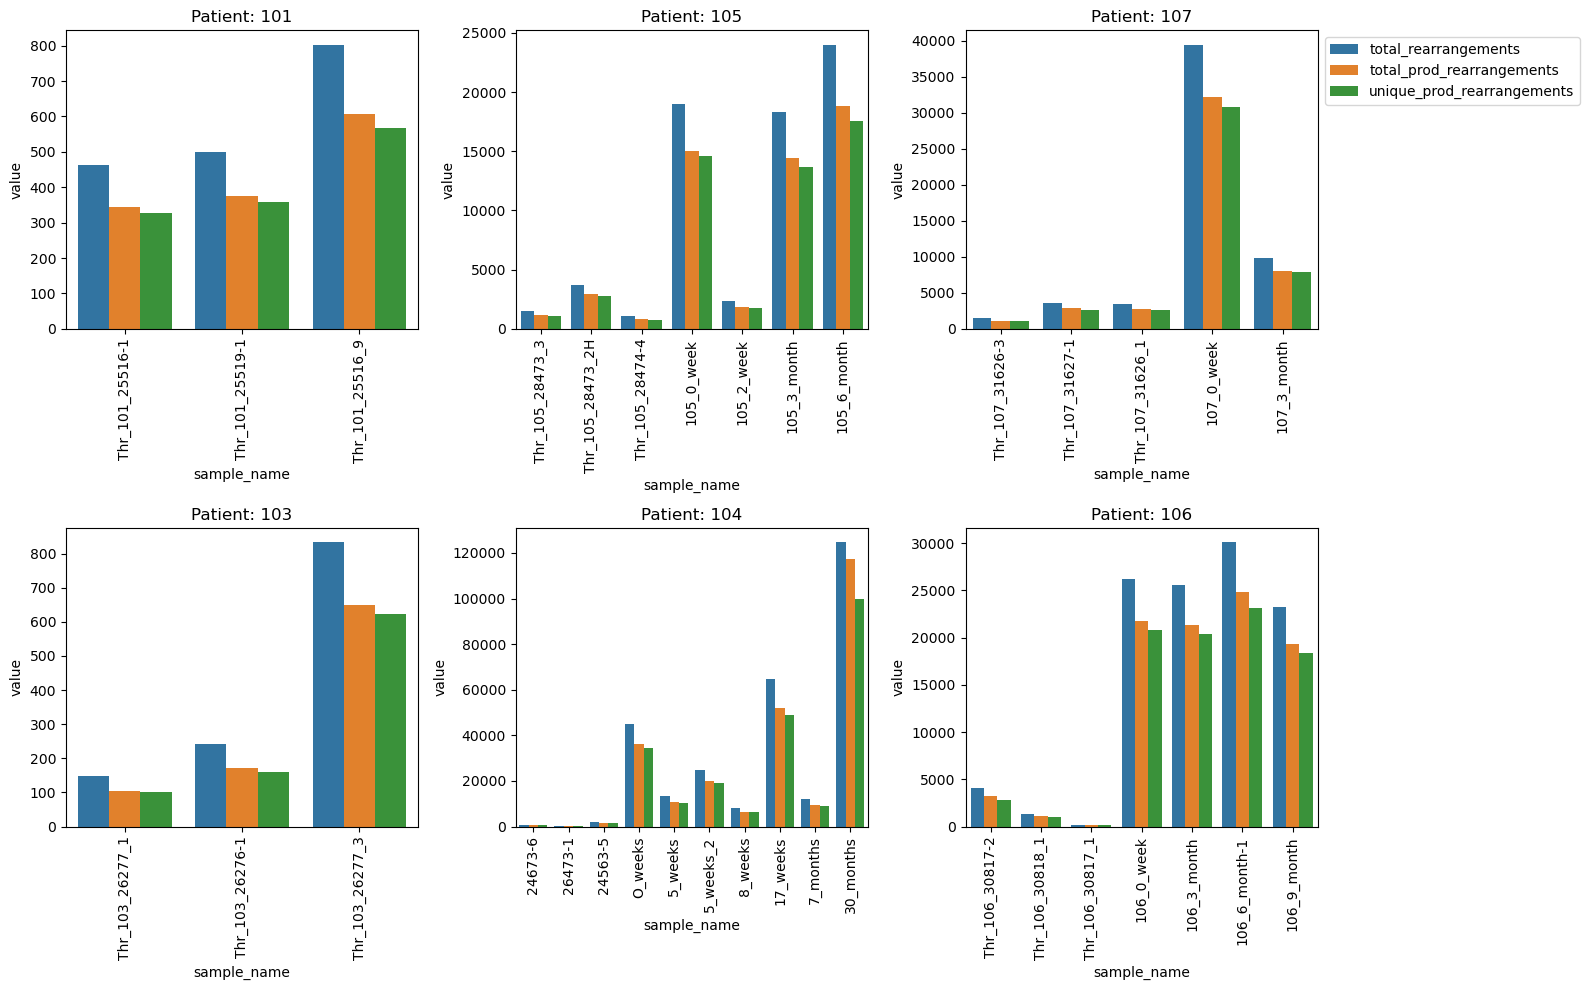

In [283]:
fig, axs = plt.subplots(2, 3, figsize = (16, 10), sharex = False, sharey = False)
axs = axs.flat
for i, patient_id in enumerate([101,  105, 107, 103, 104, 106]):
    temp = patient_df[patient_df.patient_id ==patient_id]
    df_melted = temp.melt(id_vars="sample_name", value_vars = [ 'total_rearrangements', 'total_prod_rearrangements', 'unique_prod_rearrangements'], 
                                 var_name="rearrangement_count", value_name="value")
    if i == 2:
        sns.barplot(data = df_melted, x = 'sample_name', y = 'value', hue = 'rearrangement_count', ax = axs[i], legend = True)
        axs[i].legend( loc='upper left', bbox_to_anchor = (1, 1))
    else:
        sns.barplot(data = df_melted, x = 'sample_name', y = 'value', hue = 'rearrangement_count', ax = axs[i], legend = False)
        
    axs[i].tick_params(axis = 'x', rotation = 90)
    axs[i].set_title(f"Patient: {patient_id}")

plt.tight_layout()
plt.savefig(f'Figures/rearrangement_counts_all_patients.png', bbox_inches = 'tight', dpi = 300)
plt.show()

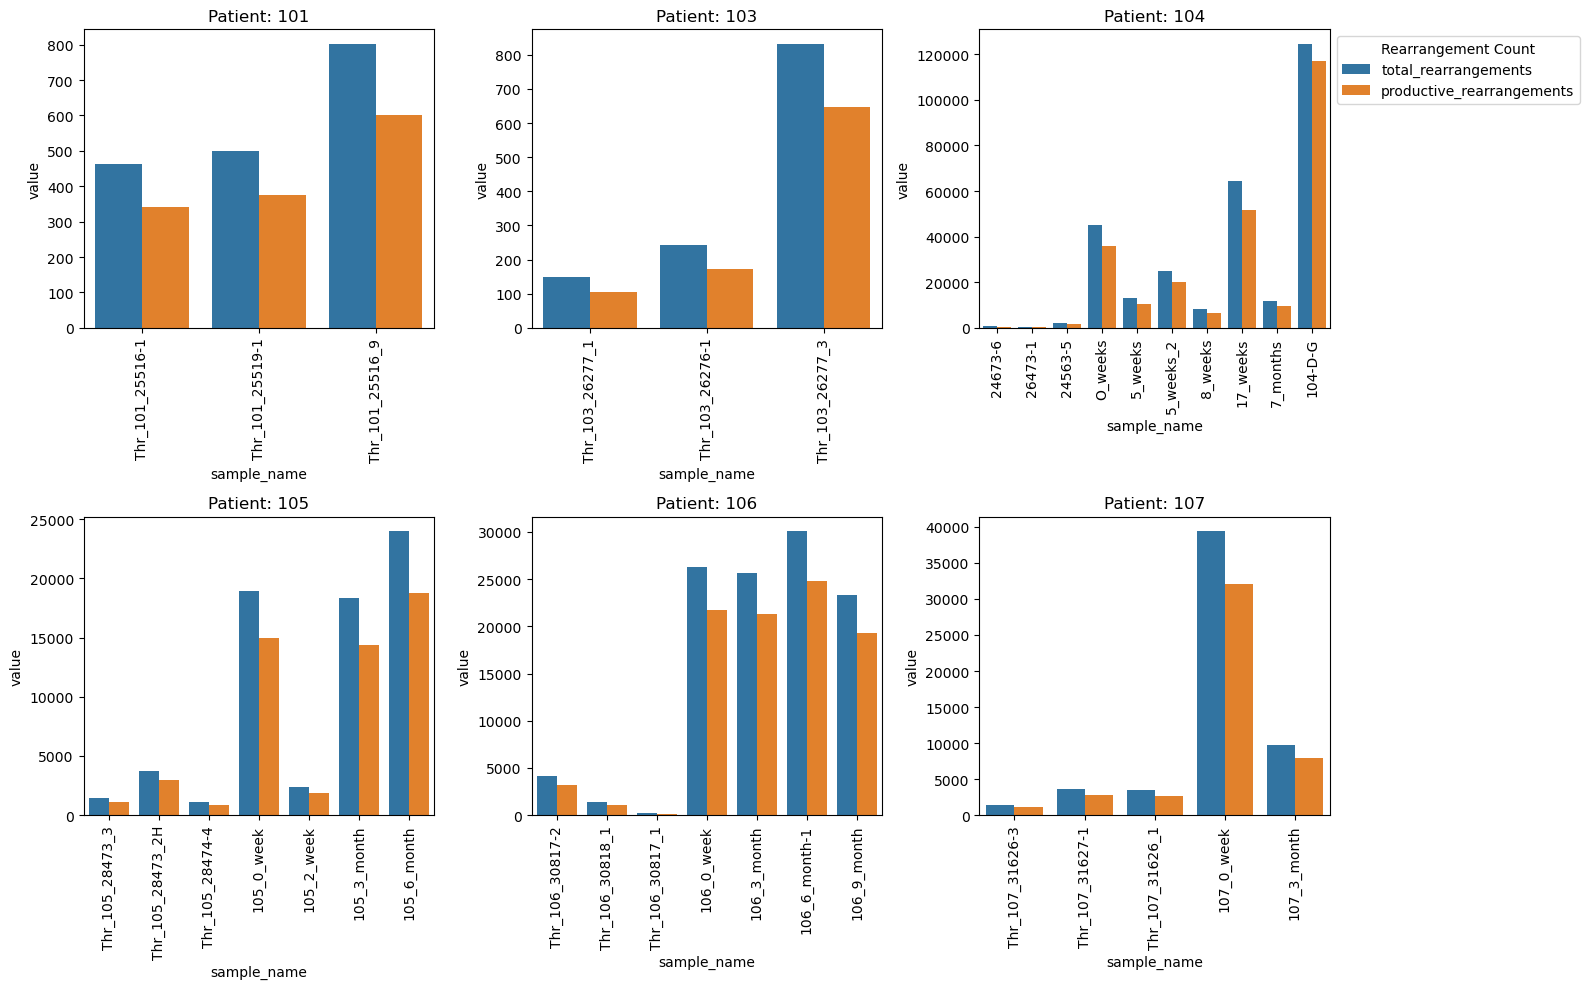

In [260]:
fig, axs = plt.subplots(2, 3, figsize = (16, 10), sharex = False, sharey = False)
axs = axs.flat
for i, patient_id in enumerate([101, 103, 104, 105, 106, 107]):
    temp = combined_df.loc[all_patient_files[patient_id]]
    temp = temp.reset_index()
    df_melted = temp.melt(id_vars="sample_name", value_vars = ['total_rearrangements', 'productive_rearrangements'], 
                                 var_name="rearrangement_count", value_name="value")
    if i == 2:
        sns.barplot(data = df_melted, x = 'sample_name', y = 'value', hue = 'rearrangement_count', ax = axs[i], legend = True)
        axs[i].legend(title = 'Rearrangement Count', loc='upper left', bbox_to_anchor = (1, 1))
    else:
        sns.barplot(data = df_melted, x = 'sample_name', y = 'value', hue = 'rearrangement_count', ax = axs[i], legend = False)
        
    axs[i].tick_params(axis = 'x', rotation = 90)
    axs[i].set_title(f"Patient: {patient_id}")

plt.tight_layout()
plt.show()

In [170]:
# combined_df.iloc[0]

## Rearrangement Count Plot

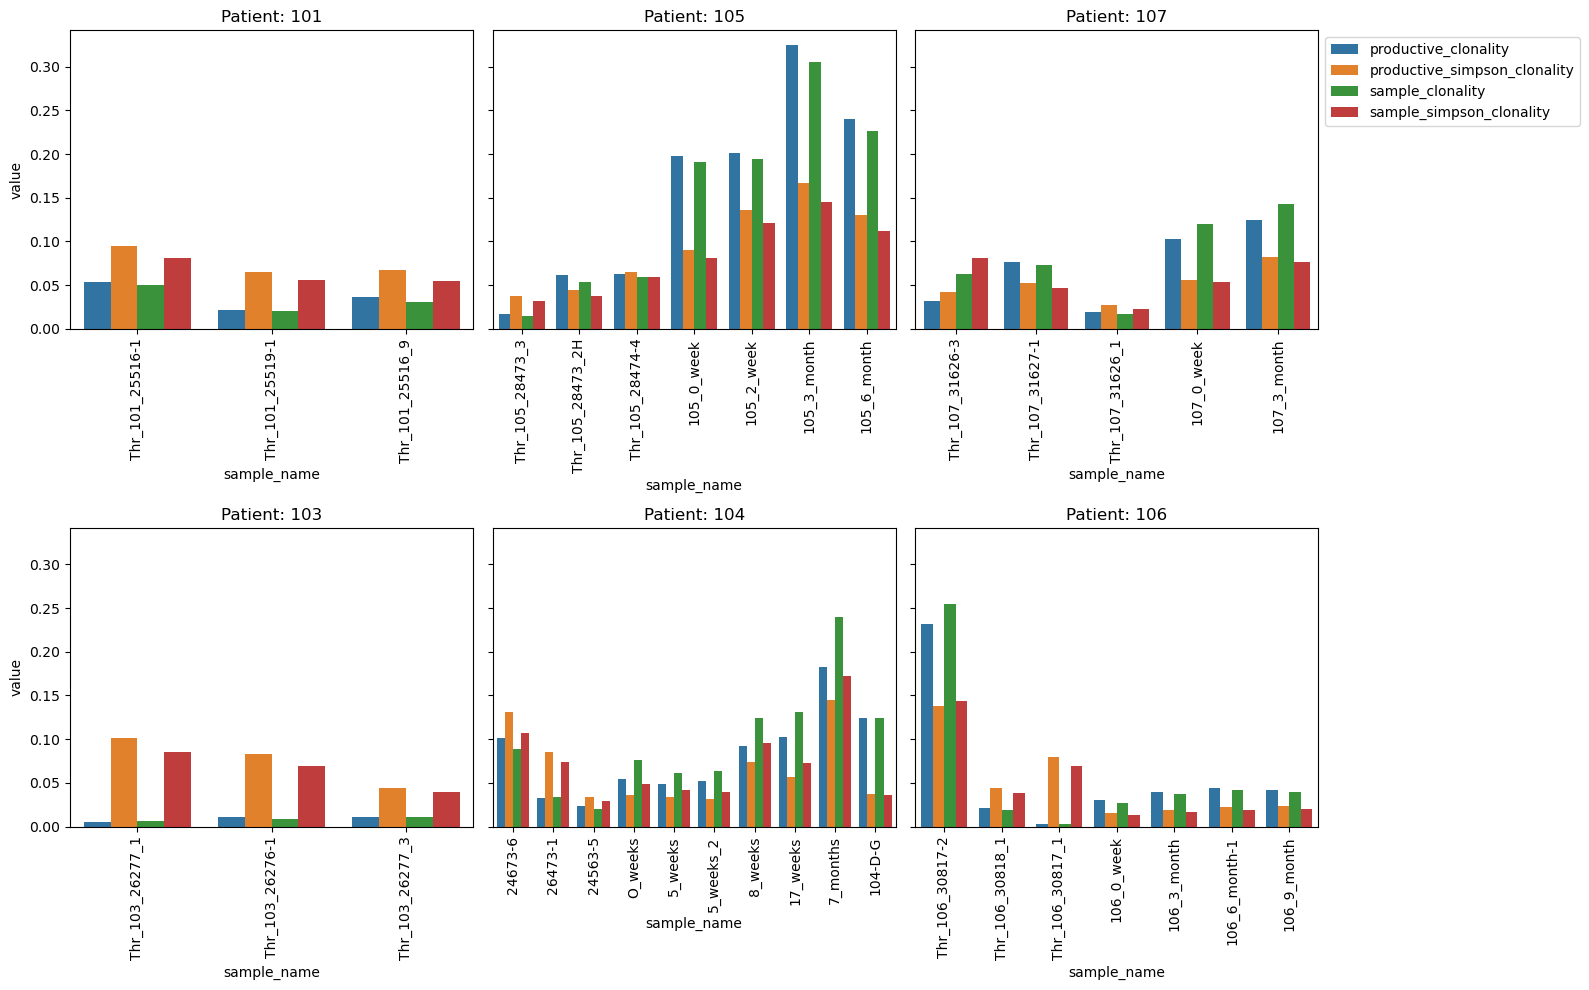

In [286]:
all_patient_files = {101: ['Thr_101_25516-1', 'Thr_101_25519-1', 'Thr_101_25516_9'],
 103: ['Thr_103_26277_1', 'Thr_103_26276-1', 'Thr_103_26277_3'],
 104: ['24673-6', '26473-1', '24563-5', 'O_weeks', '5_weeks', '5_weeks_2', '8_weeks', '17_weeks', '7_months', '104-D-G'],
 105: ['Thr_105_28473_3', 'Thr_105_28473_2H', 'Thr_105_28474-4', '105_0_week', '105_2_week', '105_3_month', '105_6_month'],
 106: ['Thr_106_30817-2', 'Thr_106_30818_1', 'Thr_106_30817_1', '106_0_week', '106_3_month', '106_6_month-1', '106_9_month'],
 107: ['Thr_107_31626-3', 'Thr_107_31627-1', 'Thr_107_31626_1', '107_0_week', '107_3_month']}

fig, axs = plt.subplots(2, 3, figsize = (16, 10), sharex = False, sharey = True)
axs = axs.flat
for i, patient_id in enumerate([101,  105, 107, 103, 104, 106]):
    temp = combined_df.loc[all_patient_files[patient_id]]
    temp = temp.reset_index()
    # df_melted = temp.melt(id_vars="sample_name", value_vars = [ 'productive_clonality', 'productive_simpson_clonality', 'sample_clonality', 'sample_simpson_clonality', 'max_frequency', 'max_productive_frequency',], 
    #                              var_name="clonality", value_name="value")
    df_melted = temp.melt(id_vars="sample_name", value_vars = [ 'productive_clonality', 'productive_simpson_clonality', 'sample_clonality', 'sample_simpson_clonality', ], 
                                 var_name="clonality", value_name="value")
    if i == 2:
        sns.barplot(data = df_melted, x = 'sample_name', y = 'value', hue = 'clonality', ax = axs[i], legend = True)
        axs[i].legend( loc='upper left', bbox_to_anchor = (1, 1))
    else:
        sns.barplot(data = df_melted, x = 'sample_name', y = 'value', hue = 'clonality', ax = axs[i], legend = False)
        
    axs[i].tick_params(axis = 'x', rotation = 90)
    axs[i].set_title(f"Patient: {patient_id}")

plt.tight_layout()
plt.savefig(f'Figures/clonality_plot_all_samples_v2.png', bbox_inches = 'tight', dpi = 300)
plt.show()

## Read VDJDB, McPAS and CEDAR DB
- McPAS has more cancer related TCR with cell type
- Using McPAS for further analysis

In [492]:
vdjdb_tcr = pd.read_csv('VDJDB_09-15-2025.tsv', usecols = ['Gene', 'CDR3', 'MHC A', 'V', 'J', 'Species', 'Epitope', 'Epitope species'], sep = '\t')
vdjdb_tcr = vdjdb_tcr[vdjdb_tcr.Gene == 'TRB']
mcpas_tcr = pd.read_csv('McPAS-TCR.csv',
                        usecols = ['CDR3.beta.aa', 'Pathology', 'Species', 'Category', 'TRBV', 'TRBJ', 'T.Cell.Type',
                                   'Antigen.protein', 'Protein.ID', 'Epitope.peptide', 'Epitope.ID'], low_memory = False)

cedardb_tcr = pd.read_csv('CEDAR_data.tsv', sep = '\t')
mcpas_tcr.head()

CDR3.beta.aa Species    Category          Pathology  \
0     ATSIRFTDTQYF   Human  Autoimmune     Celiac disease   
1   CAAAAASGAYEQYF   Human   Pathogens     M.Tuberculosis   
2  CAAADEEIGNQPQHF   Human   Pathogens  Hepatitis C virus   
3   CAAAGGPDTGELFF   Human   Pathogens    M. tuberculosis   
4   CAAEDDTGGFKTIF   Human   Pathogens          Influenza   

       Antigen.protein Protein.ID Epitope.peptide Epitope.ID T.Cell.Type  \
0             DQ2-a-II        NaN     PQPELPYPQPQ        NaN         CD4   
1                  NaN        NaN             NaN        NaN         CD4   
2   Genome polyprotein     P27958       ATDALMTGY       4917         CD8   
3                  NaN        NaN             NaN        NaN         CD8   
4  Matrix protein (M1)     P03485       GILGFVFTL      20354         CD8   

        TRBV      TRBJ  
0    TRBV7-2   TRBJ2-3  
1   TRBV10-3       NaN  
2  TRBV10-03       NaN  
3    TRBV6-1   TRBJ2-2  
4  TRBV25:01  TRBJ9:01

In [493]:
# vdjdb_tcr['Epitope species'].value_counts()

# vdjdb_tcr['Gene'].value_counts()
# vdjdb_tcr.head()
# cedardb_tcr['source_antigens'].value_counts().index.tolist()
cedardb_tcr.head()

trimmed_seq    original_seq  receptor_group                   epitopes  \
0  AAALGQSRTPGSCF  AAALGQSRTPGSCF          166244                  GLCTLVAML   
1     AAANLPAVRSI     AAANLPAVRSI          166245                  GLCTLVAML   
2  AAATDKLQLMKNCF  AAATDKLQLMKNCF          166246                  GLCTLVAML   
3      AAFKGAQKLV    CAAFKGAQKLVF           35615  EGTKGATMDLEIVNLPNVEISKDLS   
4     AAGAGLSYEQY     AAGAGLSYEQY           11525                  NLVPMVATV   

                              source_organisms source_antigens  
0     Human herpesvirus 4 (Epstein Barr virus)   BMLF1 protein  
1     Human herpesvirus 4 (Epstein Barr virus)   BMLF1 protein  
2     Human herpesvirus 4 (Epstein Barr virus)   BMLF1 protein  
3                                          NaN             NaN  
4  Human herpesvirus 5 (Human cytomegalovirus)            pp65

In [494]:
all_patient_files = {101: ['Thr_101_25516-1', 'Thr_101_25519-1', 'Thr_101_25516_9'],
 103: ['Thr_103_26277_1', 'Thr_103_26276-1', 'Thr_103_26277_3'],
 104: ['24673-6', '26473-1', '24563-5',  'O_weeks', '5_weeks', '5_weeks_2', '8_weeks', '17_weeks', '022015-058-7', '7_months', '30_months'],
 105: ['Thr_105_28473_3', 'Thr_105_28473_2H', 'Thr_105_28474-4', '105_0_week', '105_2_week', '105_3_month', '105_6_month'],
 106: ['Thr_106_30817-2', 'Thr_106_30818_1', 'Thr_106_30817_1', '106_0_week', '106_3_month', '106_6_month-1', '106_9_month'],
 107: ['Thr_107_31626-3', 'Thr_107_31627-1', 'Thr_107_31626_1', '107_0_week', '107_3_month']}
for patient, timepoints in all_patient_files.items():
    print(f'Patinet: {patient} : {timepoints}')

Patinet: 101 : ['Thr_101_25516-1', 'Thr_101_25519-1', 'Thr_101_25516_9']
Patinet: 103 : ['Thr_103_26277_1', 'Thr_103_26276-1', 'Thr_103_26277_3']
Patinet: 104 : ['24673-6', '26473-1', '24563-5', 'O_weeks', '5_weeks', '5_weeks_2', '8_weeks', '17_weeks', '022015-058-7', '7_months', '30_months']
Patinet: 105 : ['Thr_105_28473_3', 'Thr_105_28473_2H', 'Thr_105_28474-4', '105_0_week', '105_2_week', '105_3_month', '105_6_month']
Patinet: 106 : ['Thr_106_30817-2', 'Thr_106_30818_1', 'Thr_106_30817_1', '106_0_week', '106_3_month', '106_6_month-1', '106_9_month']
Patinet: 107 : ['Thr_107_31626-3', 'Thr_107_31627-1', 'Thr_107_31626_1', '107_0_week', '107_3_month']


In [350]:
patient_info = []
for i, patient_id in enumerate([104, 105, 106, 107]):
    for sample_name in all_patient_files[patient_id]:
        cdr3s = pd.read_csv(f'{dirpath}{sample_name}.igblast.airr.tsv', sep = '\t', usecols = ['productive', 'junction_aa', 'duplicate_count'])
        total_rearrangements = cdr3s.shape[0]
        cdr3s = cdr3s[cdr3s.productive == 'T'].drop("productive", axis=1)
        total_prod_rearrangements = cdr3s.shape[0]
        # Combine duplicate sequences and sum their counts
        cdr3s = cdr3s.groupby(cdr3s.junction_aa).aggregate({"duplicate_count": 'sum'}).reset_index()
        unique_prod_rearrangements = cdr3s.shape[0]
        unique_prod_percentage = unique_prod_rearrangements/total_prod_rearrangements * 100
        patient_info.append({
                        'patient_id': patient_id,
                        'sample_name': sample_name,
                        'total_rearrangements': total_rearrangements,
                        'total_prod_rearrangements': total_prod_rearrangements,
                        'unique_prod_rearrangements': unique_prod_rearrangements,
                        'unique_prod_percentage': unique_prod_percentage
                        
                     })
patient_df = pd.DataFrame(patient_info)
patient_df 

patient_id       sample_name  total_rearrangements  \
0          104           24673-6                   744   
1          104           26473-1                   432   
2          104           24563-5                  2083   
3          104           O_weeks                 44954   
4          104           5_weeks                 13264   
5          104         5_weeks_2                 25027   
6          104           8_weeks                  8221   
7          104          17_weeks                 64530   
8          104      022015-058-7                   225   
9          104          7_months                 11964   
10         104         30_months                124691   
11         105   Thr_105_28473_3                  1483   
12         105  Thr_105_28473_2H                  3739   
13         105   Thr_105_28474-4                  1073   
14         105        105_0_week                 18959   
15         105        105_2_week                  2370   
16         105       105_3_month                 18303   
17         105       105_6_month                 24009   
18         106   Thr_106_30817-2                  4122   
19         106   Thr_106_30818_1                  1374   
20         106   Thr_106_30817_1                   215   
21         106        106_0_week                 26243   
22         106       106_3_month                 25610   
23         106     106_6_month-1                 30099   
24         106       106_9_month                 23285   
25         107   Thr_107_31626-3                  1473   
26         107   Thr_107_31627-1                  3575   
27         107   Thr_107_31626_1                  3506   
28         107        107_0_week                 39441   
29         107       107_3_month                  9772   

    total_prod_rearrangements  unique_prod_rearrangements  \
0                         569                         551   
1                         335                         319   
2                        1661                        1600   
3                       36140                       34336   
4                       10666                       10227   
5                       20156                       19080   
6                        6531                        6232   
7                       51833                       48828   
8                         110                         104   
9                        9495                        8949   
10                     117342                       99809   
11                       1132                        1085   
12                       2963                        2755   
13                        825                         758   
14                      14996                       14594   
15                       1858                        1761   
16                      14400                       13707   
17                      18790                       17521   
18                       3258                        2845   
19                       1097                        1039   
20                        163                         154   
21                      21718                       20782   
22                      21289                       20411   
23                      24782                       23120   
24                      19285                       18362   
25                       1136                        1068   
26                       2849                        2645   
27                       2738                        2576   
28                      32102                       30835   
29                       7980                        7865   

    unique_prod_percentage  
0                96.836555  
1                95.223881  
2                96.327514  
3                95.008301  
4                95.884118  
5                94.661639  
6                95.421834  
7                94.202535  
8                94.545455  
9                94.249

In [508]:
# mcpas_tcr['Antigen.protein'].unique()
# # mcpas_tcr

## Get common CDR3 with McPAS database

In [553]:
all_patient_files = {101: ['Thr_101_25516-1', 'Thr_101_25519-1', 'Thr_101_25516_9'],
 103: ['Thr_103_26277_1', 'Thr_103_26276-1', 'Thr_103_26277_3'],
 104: ['24673-6', '26473-1', '24563-5',  'O_weeks', '5_weeks', '5_weeks_2', '8_weeks', '17_weeks', '022015-058-7', '7_months', '30_months'],
 # 104: [ '022015-058-7'],
 105: ['Thr_105_28473_3', 'Thr_105_28473_2H', 'Thr_105_28474-4', '105_0_week', '105_2_week', '105_3_month', '105_6_month'],
 106: ['Thr_106_30817-2', 'Thr_106_30818_1', 'Thr_106_30817_1', '106_0_week', '106_3_month', '106_6_month-1', '106_9_month'],
 107: ['Thr_107_31626-3', 'Thr_107_31627-1', 'Thr_107_31626_1', '107_0_week', '107_3_month']}

patient_unique_clones_dict = {}
patient_unique_pathology_dict = {}
# pathology = ['Lung cancer']
# pathology = ['Clear cell renal carcinoma']
# pathology = ['Colorectal cancer']
pathology = ['Neoantigen']
# pathology = ['Hepatitis C virus (HCV)']

patient_ids = [101, 103, 104, 105, 106, 107]
# patient_ids = [104]
for patient_id in patient_ids:
    unique_clones = set()
    unique_pathology = set()
    for file in all_patient_files[patient_id]:
        cdr3s = read_cdr3_dict(f'{dirpath}{file}.igblast.airr.tsv')
        clones = cdr3s.keys()
        mcpas_matched_clones = mcpas_tcr[mcpas_tcr['CDR3.beta.aa'].isin(clones)]
        # mcpas_matched_clones = mcpas_matched_clones[~mcpas_matched_clones.Category.isin(['Pathogens', 'Autoimmune', 'Allergy', 'Other'])]
        mcpas_matched_clones = mcpas_matched_clones[mcpas_matched_clones.Category.isin(['Cancer'])]
        # mcpas_matched_clones = mcpas_matched_clones[mcpas_matched_clones.Pathology.isin(['Lung cancer', 'Clear cell renal carcinoma', 'Neoantigen'])]
        # mcpas_matched_clones = mcpas_matched_clones[mcpas_matched_clones.Pathology.isin(['Lung cancer',  'Colorectal cancer'])]
        # mcpas_matched_clones = mcpas_matched_clones[mcpas_matched_clones.Pathology.isin(pathology)]
        matched_clones = mcpas_matched_clones['CDR3.beta.aa'].unique()
        matched_pathology = mcpas_matched_clones['Pathology'].unique()
        unique_clones.update(matched_clones)
        unique_pathology.update(matched_pathology)
    patient_unique_clones_dict[patient_id] = unique_clones
    patient_unique_pathology_dict[patient_id] = unique_pathology
patient_unique_pathology_dict   
# patient_unique_clones_dict

{101: {'Melanoma', 'Neoantigen'},
 103: {'Neoantigen'},
 104: {'Acute myeloid leukemia',
  'Breast Cancer',
  'Carcinoma',
  'Clear cell renal carcinoma',
  'Colorectal cancer',
  'Epithelial ovarian cancer',
  'HTLV-1',
  'Lung cancer',
  'Lymphoma',
  'Melanoma',
  'Merkel cell carcinoma',
  'Neoantigen',
  'Tumor',
  'Tumor associated antigen (TAA)'},
 105: {'Breast Cancer',
  'Clear cell renal carcinoma',
  'Colorectal cancer',
  'Epithelial ovarian cancer',
  'HTLV-1',
  'Melanoma',
  'Merkel cell carcinoma',
  'Neoantigen',
  'Tumor'},
 106: {'Acute myeloid leukemia',
  'Breast Cancer',
  'Carcinoma',
  'Clear cell renal carcinoma',
  'Colorectal cancer',
  'HTLV-1',
  'Lung cancer',
  'Lymphoma',
  'Melanoma',
  'Merkel cell carcinoma',
  'Neoantigen',
  'Tumor',
  'Tumor associated antigen (TAA)'},
 107: {'Breast Cancer',
  'Carcinoma',
  'Clear cell renal carcinoma',
  'Colorectal cancer',
  'Lung cancer',
  'Melanoma',
  'Merkel cell carcinoma',
  'Neoantigen',
  'Tumor',
  '

## Plot Number of Neo-Antigens Each for Each Patient From McPAS

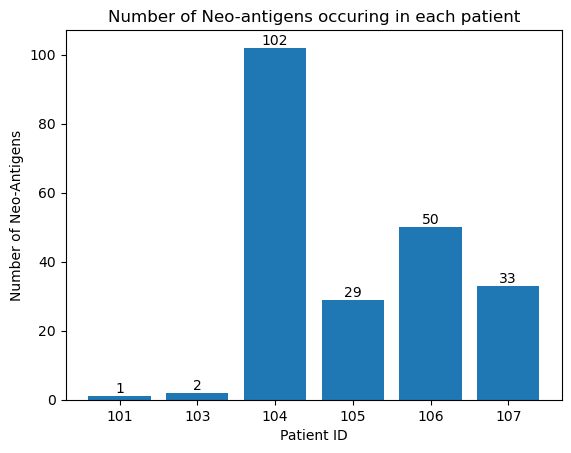

In [523]:
keys_str = [str(k) for k in patient_unique_clones_dict.keys()]
heights = [len(v) for v in patient_unique_clones_dict.values()]

plt.bar(keys_str, heights)
# Add value labels on top of bars
for i, height in enumerate(heights):
    plt.text(i, height + 0.1, str(height), ha='center', va='bottom')
plt.xlabel('Patient ID')
plt.ylabel('Number of Neo-Antigens')
plt.title('Number of Neo-antigens occuring in each patient')
plt.savefig('Figures/number_of_neoantigen_barplot.png')
plt.show()

## Look at the output for McPas Website

104 (285, 6)
{'Neoantigen': 122, 'Colorectal cancer': 103, 'Melanoma': 20, 'Tumor associated antigen (TAA)': 10, 'HTLV-1': 9, 'Clear cell renal carcinoma': 8, 'Carcinoma': 4, 'Breast Cancer': 3, 'Merkel cell carcinoma': 3, 'Epithelial ovarian cancer': 1, 'Acute myeloid leukemia': 1, 'Lung cancer': 1}
105 (133, 6)
{'Colorectal cancer': 75, 'Neoantigen': 43, 'Melanoma': 7, 'Merkel cell carcinoma': 4, 'Clear cell renal carcinoma': 1, 'Breast Cancer': 1, 'Epithelial ovarian cancer': 1, 'HTLV-1': 1}
106 (196, 6)
{'Colorectal cancer': 101, 'Neoantigen': 61, 'Melanoma': 12, 'Clear cell renal carcinoma': 6, 'Merkel cell carcinoma': 5, 'Tumor associated antigen (TAA)': 4, 'HTLV-1': 2, 'Breast Cancer': 2, 'Carcinoma': 1, 'Acute myeloid leukemia': 1, 'Lung cancer': 1}
107 (130, 6)
{'Colorectal cancer': 64, 'Neoantigen': 43, 'Melanoma': 7, 'Tumor associated antigen (TAA)': 5, 'Merkel cell carcinoma': 4, 'Clear cell renal carcinoma': 3, 'Lung cancer': 2, 'Breast Cancer': 1, 'Carcinoma': 1}


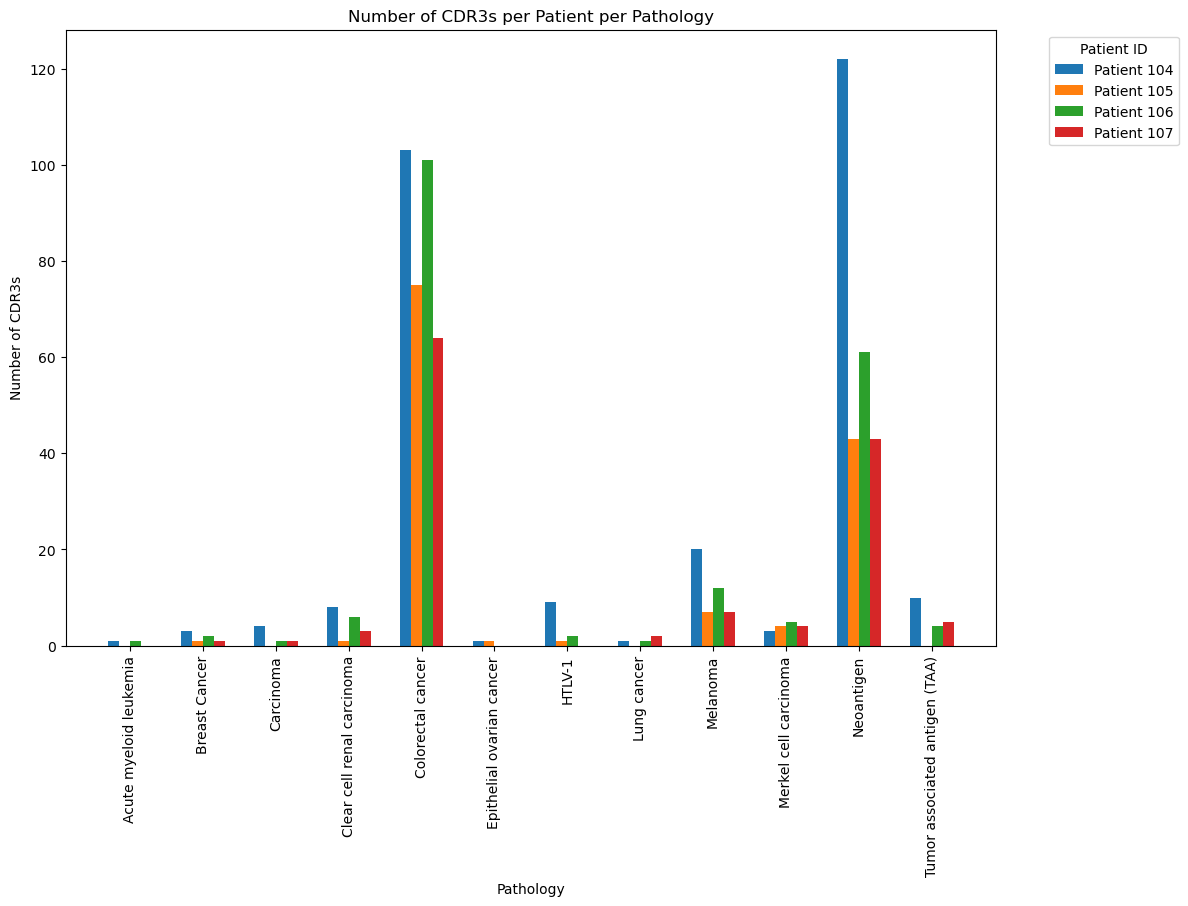

In [600]:
patient_ids = [104, 105, 106, 107]
patient_pathology_bar = {}
for patient_id in patient_ids:
    mcpas_output = pd.read_csv(f'./McPasOutput/patient_{patient_id}_McPAS-TCR_search.csv', usecols = ['Query', 'T.Cell.Type', 'CDR3.beta.aa', 'Pathology','TRBV', 'TRBJ'])
    # print(mcpas_output[['Query', 'CDR3.beta.aa', 'Category', 'Pathology','TRBV', 'TRBJ']])
    print(patient_id, mcpas_output.shape)
    print(mcpas_output['Pathology'].value_counts().to_dict())
    
    patient_pathology_bar[patient_id] = mcpas_output['Pathology'].value_counts().to_dict()
patient_pathology_bar
patients = list(patient_pathology_bar.keys())
all_pathologies = sorted({path for p in patient_pathology_bar.values() for path in p})

n_patients = len(patients)
n_pathologies = len(all_pathologies)

bar_width = 0.15
x = np.arange(n_pathologies)  # x-axis for pathologies

fig, ax = plt.subplots(figsize=(12,8))

# Plot bars for each patient at the position shifted by patient index * bar width
for i, patient in enumerate(patients):
    counts = [patient_pathology_bar[patient].get(path, 0) for path in all_pathologies]
    ax.bar(x + i*bar_width, counts, width=bar_width, label=f'Patient {patient}')

ax.set_xlabel('Pathology')
ax.set_ylabel('Number of CDR3s')
ax.set_title('Number of CDR3s per Patient per Pathology')

# Set ticks to be centered between grouped bars
ax.set_xticks(x + bar_width * (n_patients - 1) / 2)
ax.set_xticklabels(all_pathologies)
ax.tick_params(axis='x', rotation=90)
ax.legend(title='Patient ID', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.savefig('Figures/per_patient_per_pathology_matched_cdr3.png', bbox_inches = 'tight')
plt.show()

## Type of T cell and Their count for All Antigens

104 (285, 6)
{'CD8': 156, 'CD4': 12}
105 (133, 6)
{'CD8': 92, 'CD4': 6}
106 (196, 6)
{'CD8': 127, 'CD4': 11}
107 (130, 6)
{'CD8': 84, 'CD4': 7}
['CD4', 'CD8']


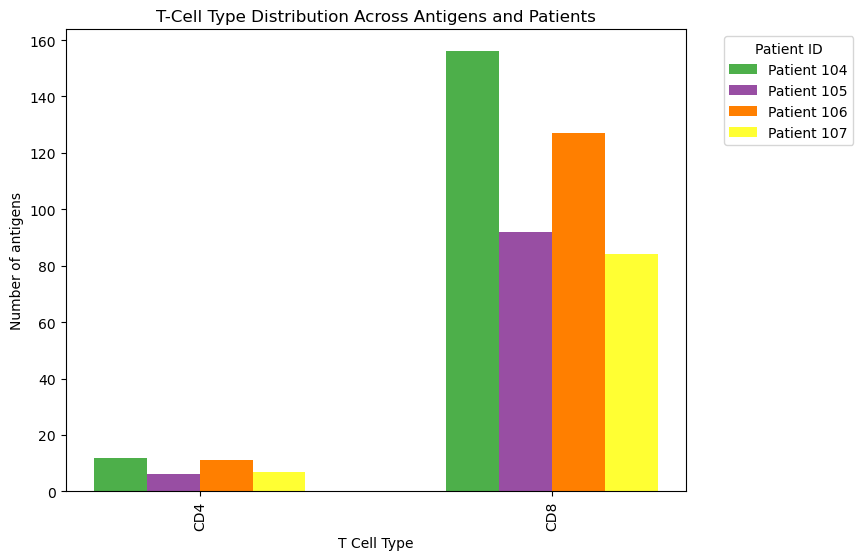

In [601]:
patient_ids = [104, 105, 106, 107]
patient_pathology_bar = {}
patient_Tcell_bar = {}
for patient_id in patient_ids:
    mcpas_output = pd.read_csv(f'./McPasOutput/patient_{patient_id}_McPAS-TCR_search.csv', usecols = ['Query', 'T.Cell.Type', 'CDR3.beta.aa', 'Pathology','TRBV', 'TRBJ'])
    # print(mcpas_output[['Query', 'CDR3.beta.aa', 'Category', 'Pathology','TRBV', 'TRBJ']])
    print(patient_id, mcpas_output.shape)
    # mcpas_output = mcpas_output[mcpas_output.Pathology== 'Neoantigen']
    print(mcpas_output['T.Cell.Type'].value_counts().to_dict())
    
    patient_pathology_bar[patient_id] = mcpas_output['Pathology'].value_counts().to_dict()
    patient_Tcell_bar[patient_id] = mcpas_output['T.Cell.Type'].value_counts().to_dict()

patients = list(patient_Tcell_bar.keys())
all_pathologies = sorted({path for p in patient_Tcell_bar.values() for path in p})
print(all_pathologies)

colors = {
    101: "#e41a1c",  # red
    103: "#377eb8",  # blue
    104: "#4daf4a",  # green
    105: "#984ea3",  # purple
    106: "#ff7f00",  # orange
    107: "#ffff33",  # yellow
}


n_patients = len(patients)
n_pathologies = len(all_pathologies)

bar_width = 0.15
x = np.arange(n_pathologies)  # x-axis for pathologies

fig, ax = plt.subplots(figsize=(8,6))

# Plot bars for each patient at the position shifted by patient index * bar width
for i, patient in enumerate(patients):
    counts = [patient_Tcell_bar[patient].get(path, 0) for path in all_pathologies]
    ax.bar(x + i*bar_width, counts, width=bar_width, label=f'Patient {patient}', color = colors[patient])

ax.set_xlabel('T Cell Type')
ax.set_ylabel('Number of antigens')
ax.set_title('T-Cell Type Distribution Across Antigens and Patients')

# Set ticks to be centered between grouped bars
ax.set_xticks(x + bar_width * (n_patients - 1) / 2)
ax.set_xticklabels(all_pathologies)
ax.tick_params(axis='x', rotation=90)
ax.legend(title='Patient ID', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.savefig('Figures/T_cell_type_across_patient_and_antigens.png', bbox_inches = 'tight')
plt.show()

## Type of T cell and Their count for Neo Antigens

104 (285, 6)
{'CD8': 20}
105 (133, 6)
{'CD8': 10}
106 (196, 6)
{'CD8': 10}
107 (130, 6)
{'CD8': 10}
['CD8']


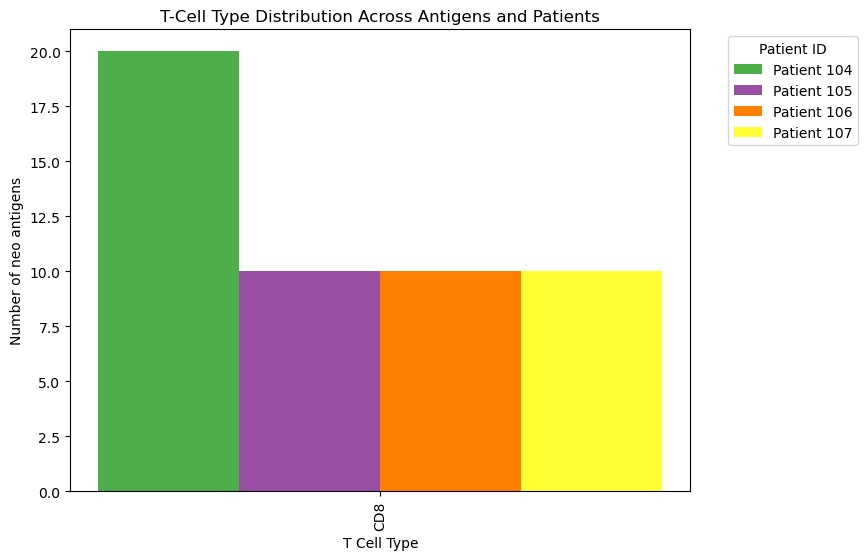

In [602]:
patient_ids = [104, 105, 106, 107]
patient_pathology_bar = {}
patient_Tcell_bar = {}
for patient_id in patient_ids:
    mcpas_output = pd.read_csv(f'./McPasOutput/patient_{patient_id}_McPAS-TCR_search.csv', usecols = ['Query', 'T.Cell.Type', 'CDR3.beta.aa', 'Pathology','TRBV', 'TRBJ'])
    # print(mcpas_output[['Query', 'CDR3.beta.aa', 'Category', 'Pathology','TRBV', 'TRBJ']])
    print(patient_id, mcpas_output.shape)
    mcpas_output = mcpas_output[mcpas_output.Pathology== 'Neoantigen']
    print(mcpas_output['T.Cell.Type'].value_counts().to_dict())
    
    patient_pathology_bar[patient_id] = mcpas_output['Pathology'].value_counts().to_dict()
    patient_Tcell_bar[patient_id] = mcpas_output['T.Cell.Type'].value_counts().to_dict()

patients = list(patient_Tcell_bar.keys())
all_pathologies = sorted({path for p in patient_Tcell_bar.values() for path in p})
print(all_pathologies)

colors = {
    101: "#e41a1c",  # red
    103: "#377eb8",  # blue
    104: "#4daf4a",  # green
    105: "#984ea3",  # purple
    106: "#ff7f00",  # orange
    107: "#ffff33",  # yellow
}


n_patients = len(patients)
n_pathologies = len(all_pathologies)

bar_width = 0.15
x = np.arange(n_pathologies)  # x-axis for pathologies

fig, ax = plt.subplots(figsize=(8,6))

# Plot bars for each patient at the position shifted by patient index * bar width
for i, patient in enumerate(patients):
    counts = [patient_Tcell_bar[patient].get(path, 0) for path in all_pathologies]
    ax.bar(x + i*bar_width, counts, width=bar_width, label=f'Patient {patient}', color = colors[patient])

ax.set_xlabel('T Cell Type')
ax.set_ylabel('Number of neo antigens')
ax.set_title('T-Cell Type Distribution Across Antigens and Patients')

# Set ticks to be centered between grouped bars
ax.set_xticks(x + bar_width * (n_patients - 1) / 2)
ax.set_xticklabels(all_pathologies)
ax.tick_params(axis='x', rotation=90)
ax.legend(title='Patient ID', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.savefig('Figures/T_cell_type_across_patient_and_neoantigens.png', bbox_inches = 'tight')
plt.show()

## Plot number of antigens occuring in each patient at each time points

In [574]:
all_patient_files = {101: ['Thr_101_25516-1', 'Thr_101_25519-1', 'Thr_101_25516_9'],
 103: ['Thr_103_26277_1', 'Thr_103_26276-1', 'Thr_103_26277_3'],
 104: ['24673-6', '26473-1', '24563-5',  'O_weeks', '5_weeks', '5_weeks_2', '8_weeks', '17_weeks', '022015-058-7', '7_months', '30_months'],
 # 104: [ '022015-058-7'],
 105: ['Thr_105_28473_3', 'Thr_105_28473_2H', 'Thr_105_28474-4', '105_0_week', '105_2_week', '105_3_month', '105_6_month'],
 106: ['Thr_106_30817-2', 'Thr_106_30818_1', 'Thr_106_30817_1', '106_0_week', '106_3_month', '106_6_month-1', '106_9_month'],
 107: ['Thr_107_31626-3', 'Thr_107_31627-1', 'Thr_107_31626_1', '107_0_week', '107_3_month']}

patient_unique_clones_dict = {}
patient_unique_pathology_dict = {}
pathology = ['Neoantigen']
patient_ids = [101, 103, 104, 105, 106, 107]
# patient_ids = [104]
for patient_id in patient_ids:
    unique_clones = {}
    unique_pathology = {}
    for file in all_patient_files[patient_id]:
        cdr3s = read_cdr3_dict(f'{dirpath}{file}.igblast.airr.tsv')
        clones = cdr3s.keys()
        mcpas_matched_clones = mcpas_tcr[mcpas_tcr['CDR3.beta.aa'].isin(clones)]
        mcpas_matched_clones = mcpas_matched_clones[mcpas_matched_clones.Category.isin(['Cancer'])]
        matched_clones = mcpas_matched_clones['CDR3.beta.aa'].unique().tolist()
        matched_pathology = mcpas_matched_clones['Pathology'].unique().tolist()
        unique_clones[file] = matched_clones
        unique_pathology[file] = matched_pathology
    patient_unique_clones_dict[patient_id] = unique_clones
    patient_unique_pathology_dict[patient_id] = unique_pathology
patient_unique_pathology_dict   
# patient_unique_clones_dict

{101: {'Thr_101_25516-1': ['Neoantigen', 'Melanoma'],
  'Thr_101_25519-1': [],
  'Thr_101_25516_9': []},
 103: {'Thr_103_26277_1': ['Neoantigen'],
  'Thr_103_26276-1': [],
  'Thr_103_26277_3': []},
 104: {'24673-6': ['Breast Cancer', 'Colorectal cancer'],
  '26473-1': [],
  '24563-5': ['Colorectal cancer', 'Breast Cancer'],
  'O_weeks': ['Neoantigen',
   'Melanoma',
   'Tumor',
   'Colorectal cancer',
   'Clear cell renal carcinoma',
   'Acute myeloid leukemia',
   'Breast Cancer',
   'Tumor associated antigen (TAA)',
   'HTLV-1'],
  '5_weeks': ['Melanoma',
   'Tumor',
   'Clear cell renal carcinoma',
   'Neoantigen',
   'Breast Cancer',
   'Colorectal cancer'],
  '5_weeks_2': ['Neoantigen',
   'Melanoma',
   'Tumor',
   'Colorectal cancer',
   'Clear cell renal carcinoma',
   'Lung cancer',
   'Carcinoma',
   'Breast Cancer',
   'HTLV-1'],
  '8_weeks': ['Neoantigen',
   'Clear cell renal carcinoma',
   'Colorectal cancer',
   'Breast Cancer'],
  '17_weeks': ['Neoantigen',
   'Colorect

## Plot Number of Unique Cancer Associated Unique Clones Each Timeponts

   Patient        Timepoint  Num_Antigens
0      101  Thr_101_25516-1             2
1      101  Thr_101_25519-1             0
2      101  Thr_101_25516_9             0
3      103  Thr_103_26277_1             2
4      103  Thr_103_26276-1             0


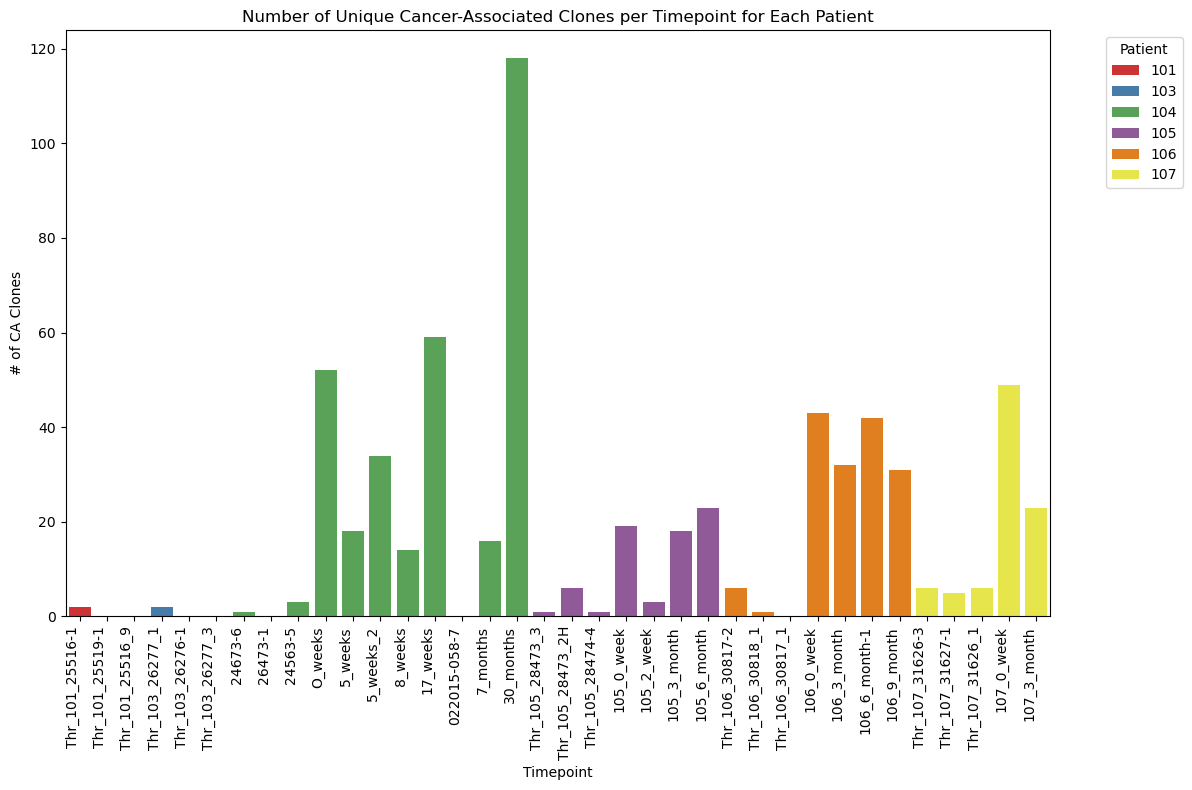

In [593]:
records = []
for patient, tps in patient_unique_clones_dict.items():
    for timepoint, antigens in tps.items():
        records.append({
            'Patient': patient,
            'Timepoint': timepoint,
            'Num_Antigens': len(antigens)
        })

df = pd.DataFrame(records)
print(df.head())
plt.figure(figsize=(12,8))
sns.barplot(
    data=df,
    x="Timepoint",
    y="Num_Antigens",
    hue="Patient",
    palette='Set1'
)

plt.xticks(rotation=90, ha='right')
plt.ylabel("# of CA Clones")
plt.title("Number of Unique Cancer-Associated Clones per Timepoint for Each Patient")
plt.legend(title="Patient", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.savefig('Figures/number_of_uniquecancer_associated_clones_each_time_point.png', bbox_inches = 'tight')
plt.show()

In [ ]:
## Plot # Unique Pathology for Each Timepoints

   Patient        Timepoint  Num_pathologies
0      101  Thr_101_25516-1                2
1      101  Thr_101_25519-1                0
2      101  Thr_101_25516_9                0
3      103  Thr_103_26277_1                1
4      103  Thr_103_26276-1                0


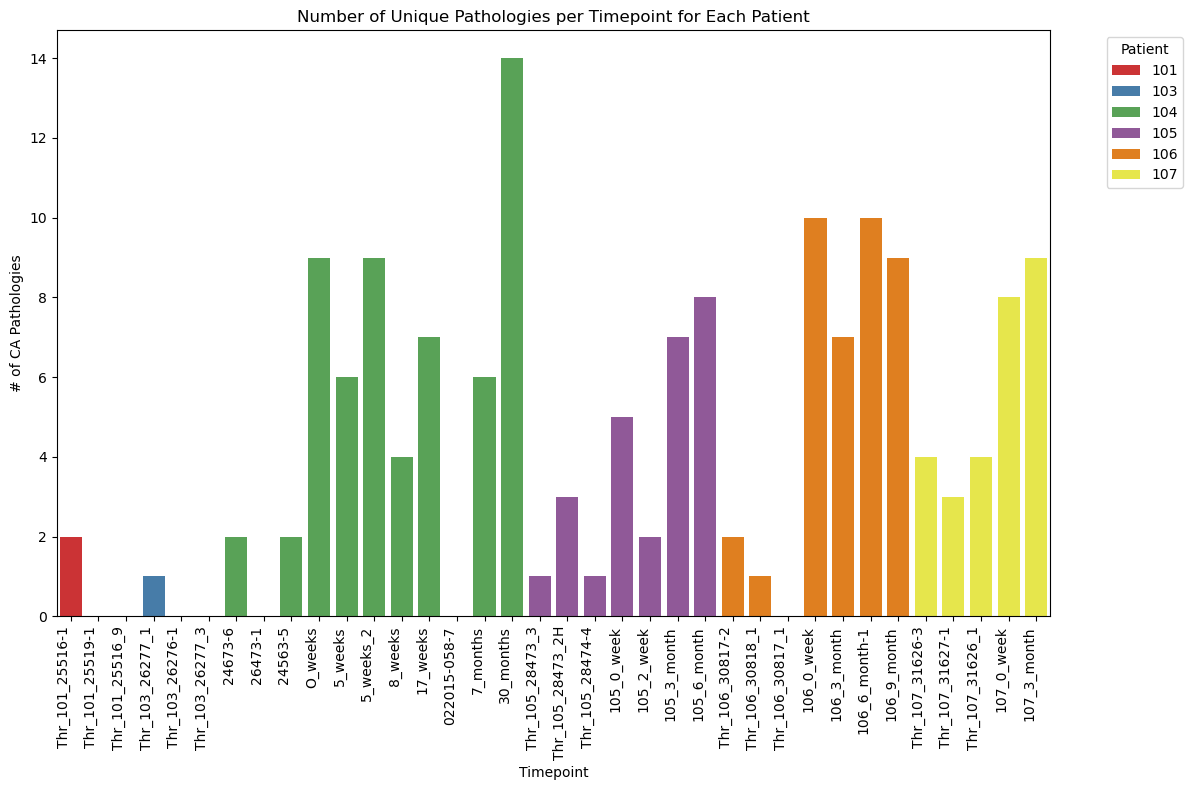

In [594]:
records = []
for patient, tps in patient_unique_pathology_dict.items():
    for timepoint, antigens in tps.items():
        records.append({
            'Patient': patient,
            'Timepoint': timepoint,
            'Num_pathologies': len(antigens)
        })

df = pd.DataFrame(records)
print(df.head())
plt.figure(figsize=(12,8))
sns.barplot(
    data=df,
    x="Timepoint",
    y="Num_pathologies",
    hue="Patient",
    palette='Set1'
)

plt.xticks(rotation=90, ha='right')
plt.ylabel("# of CA Pathologies")
plt.title("Number of Unique Pathologies per Timepoint for Each Patient")
plt.legend(title="Patient", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.savefig('Figures/number_of_unique_cancer_associated_pathologies_each_time_point.png', bbox_inches = 'tight')
plt.show()

In [563]:
mcpas_tcr['T.Cell.Type'].value_counts()

T.Cell.Type
CD4         19439
CD8         16947
CD4,CD8       602
FOXP3          40
CD4, CD8       11
Name: count, dtype: int64

## Get only Cancer Category associated CDR3 for McPAS search

In [555]:
# # Species
# # vdjdb_tcr.head()
for key, value in patient_unique_clones_dict.items():
    print(key, len(value))
    print('\n'.join(v for v in value))
# patient_unique_clones_dict

101 2
CASSLGTSSTDTQYF
CASSYSYEQYF
103 2
CASSYSSGTEAFF
CASSLGGTEAFF
104 172
CASSENTGELFF
CASSPGTGYEQYF
CASSLTGSEQYF
CASSQAGEQYF
CASSIGLNTEAFF
CASSQVPGSYEQYF
CASSRDSSYEQYF
CASSLGRSSYEQYF
CATSDSTGSYGYTF
CASSFRGNTGELFF
CASSIGGYGYTF
CASSPGPYEQYF
CASSPRAYNEQFF
CASSFDRNQPQHF
CASTGTDSYEQYF
CASNGGSYEQYF
CASSGRSTDTQYF
CASSYVGNTGELFF
CASSPDSYEQYF
CASSQVSGGSYEQYF
CASSLTDTQYF
CASSLGGLTDTQYF
CASSYGGSSYEQYF
CASSLDGSTDTQYF
CASSISGGSYEQYF
CASSLGDQPQHF
CASSLGLASYEQYF
CASSLGPDRYEQYF
CASSLLAGDTQYF
CASSNSYEQYF
CASKGETQYF
CASSPRGVGTEAFF
CASSPRTGYEQYF
CASSVQSTDTQYF
CASSLTGNYGYTF
CASSFTASNQPQHF
CASSNQETQYF
CSARAGNQPQHF
CASSLGGTEAFF
CASSPGQGYEQYF
CASSQAGGYEQYF
CASSLSYEQYF
CASSPGTAYEQYF
CASSPTSGGYEQYF
CASSLSPTDTQYF
CASIPDRNTEAFF
CASSLGQGQPQHF
CASSELAGGQETQYF
CASSPPSQETQYF
CASSYSSGTEAFF
CASSQDTGYEQYF
CASSLATEQFF
CASSLASGNEQFF
CASSFQETQYF
CASSGPRGYTF
CASSSQETQYF
CASSSNRGPEQFF
CSASTSGYEQYF
CASSPGGTNEKLFF
CASSRTGGSYEQYF
CASSPGGTEAFF
CASSFGPYGYTF
CASSLGPNSPLHF
CASSLSTDTQYF
CASSQGYEQYF
CASSVAGGYEQYF
CASSLAAGGGETQYF
C

## Get common CDR3 with VDJDB database

In [497]:
patient_unique_clones_dict_vdjdb = {}
patient_unique_pathology_dict_vdjdb = {}
pathology = ['Lung cancer']
pathology = ['Clear cell renal carcinoma']
# pathology = ['Colorectal cancer']
# pathology = ['Neoantigen']
# pathology = ['Hepatitis C virus (HCV)']

patient_ids = [101, 103, 104, 105, 106, 107]
for patient_id in patient_ids:
    unique_clones = set()
    unique_pathology = set()
    for file in all_patient_files[patient_id]:
        cdr3s = read_cdr3_dict(f'{dirpath}{file}.igblast.airr.tsv')
        clones = cdr3s.keys()
        vdjdb_matched_clones = vdjdb_tcr[vdjdb_tcr['CDR3'].isin(clones)]
        matched_clones = vdjdb_matched_clones['CDR3'].unique()
        matched_pathology = vdjdb_matched_clones['Epitope species'].unique()
        unique_clones.update(matched_clones)
        unique_pathology.update(matched_pathology)
    patient_unique_clones_dict_vdjdb[patient_id] = unique_clones
    patient_unique_pathology_dict_vdjdb[patient_id] = unique_pathology
patient_unique_pathology_dict_vdjdb   
patient_unique_clones_dict_vdjdb

{101: {'CAISESSSGANVLTF',
  'CASRLQGTEAFF',
  'CASSASGGTDTQYF',
  'CASSDSAGGTDTQYF',
  'CASSDTNTGELFF',
  'CASSFGGVNEQFF',
  'CASSGGSGNIQYF',
  'CASSGTATNEKLFF',
  'CASSHSYEQYF',
  'CASSLAGGSYEQYF',
  'CASSLGHQETQYF',
  'CASSLGQGNQPQHF',
  'CASSLGQGTGELFF',
  'CASSLGRGREAFF',
  'CASSLGTSSTDTQYF',
  'CASSLNEQFF',
  'CASSLSPNTGELFF',
  'CASSLTGNTGELFF',
  'CASSLWGTEAFF',
  'CASSLWSNEQFF',
  'CASSPGRGNYGYTF',
  'CASSPGTPYEQYF',
  'CASSPQGLGTEAFF',
  'CASSPRGTGELFF',
  'CASSQDPGGTEAFF',
  'CASSQGTGRNTEAFF',
  'CASSRTGSTEAFF',
  'CASSSGLAADTQYF',
  'CASSYAGRGGELFF',
  'CASSYSYEQYF'},
 103: {'CASSETGSSYEQYF',
  'CASSIGLAGGDTQYF',
  'CASSLAQMNTEAFF',
  'CASSLDGSSYNEQFF',
  'CASSLFPNYGYTF',
  'CASSLGENTEAFF',
  'CASSLGGTEAFF',
  'CASSLGTGGDTQYF',
  'CASSLRGGQPQHF',
  'CASSLSTDSYEQYF',
  'CASSLTGTDTQYF',
  'CASSPDSNYGYTF',
  'CASSQDPDTQYF',
  'CASSRTGELFF',
  'CASSSSDTQYF',
  'CASSSSLEAFF',
  'CASSTGSYGYTF'},
 104: {'CASSLTSGAYNEQFF',
  'CASSLASYEQYF',
  'CASSFGGGTDTQYF',
  'CASSQGETQYF',
  'CA

In [499]:
patient_unique_pathology_dict_vdjdb
vdjdb_tcr['Epitope species'].unique()

array(['InfluenzaA', 'EBV', 'CMV', 'HIV-1', 'MusMusculus', 'InfluenzaB',
       'RSV', 'HomoSapiens', 'SIV', 'HCV', 'SARS-CoV-2', 'HCoV-HKU1',
       'TriticumAestivum', 'Wheat', 'HTLV-1', 'Trypanosoma cruzi', 'MCMV',
       'SARS-CoV', 'M.tuberculosis', 'DENV', 'YFV', 'LCMV',
       'PlasmodiumBerghei', 'AdV', 'CryptomeriaJaponica', 'GallusGallus',
       'Synthetic', 'VSV', 'SaccharomycesCerevisiae', 'ManducaSexta',
       'synthetic', 'E.Coli', 'HHV', ' synthetic',
       'PseudomonasFluorescens', 'PseudomonasAeruginosa', 'VZV', 'HPV',
       'StreptomycesKanamyceticus', 'HPV-16', 'PlasmodiumFalciparum',
       'RotavirusA', 'CoxsackievirusB', 'MCPyV', 'HSV-2', 'HIV',
       'AspergillusOryzae', 'AspergillusOryzae ', 'FusariumOxysporum',
       'CryptococcusNeoforman', 'KlebsiellaOxytoca'], dtype=object)

In [502]:
# mcpas_tcr.Pathology.unique()
# all_clones = set()
# for patient_id in patient_ids:
#     all_clones.update(patient_unique_clones_dict[patient_id])
# all_clones = sorted(list(all_clones))
# print('\n'.join(clone for clone in all_clones))
mcpas_matched_clones


CDR3.beta.aa Species Category   Pathology  Antigen.protein  \
6796     CASSENTGELFF   Human   Cancer  Neoantigen      TEAD1-(SVL)   
13078  CASSLGGLTDTQYF   Human   Cancer  Neoantigen           FNDC3B   
13199    CASSLGGTEAFF   Human   Cancer  Neoantigen        OR5M3-KMV   
15893    CASSLTGSEQYF   Human   Cancer  Neoantigen         MRM1-T6P   
17650    CASSPGPYEQYF   Human   Cancer  Neoantigen          AGL-GLI   
17946   CASSPGTGYEQYF   Human   Cancer  Neoantigen  ATP6AP1-KLG-G3W   
21662    CASSQGWDEQYF   Human   Cancer  Neoantigen        ALADH-VLM   
27414   CASSYGGGYEQYF   Human   Cancer  Neoantigen        GNL3L-R4C   
27453   CASSYGNTGELFF   Human   Cancer  Neoantigen       PABPC1-R5Q   

      Protein.ID Epitope.peptide Epitope.ID T.Cell.Type         TRBV TRBJ  
6796         NaN      SVLENFTILL        NaN         NaN        TRBV2  NaN  
13078     Q53EP0       VVLSWAPPV        NaN         NaN       TRBV13  NaN  
13199        NaN       KMVAVFYTT        NaN         NaN      TRBV7-9  NaN  
15893        NaN       LLFGMPPCL        NaN         NaN       TRBV14  NaN  
17650        NaN       QLIPCMDVV      51375         NaN      TRBV5-4  NaN  
17946     Q15904       KLWASPLHV     606794         NaN      TRBV4-1  NaN  
21662        NaN      VLMGGVPGVE        NaN         NaN       TRBV14  NaN  
27414     Q9NVN8       NLNCCSVPV        NaN         NaN      TRBV6-5  NaN  
27453        NaN       MLGEQLFPL        NaN         NaN  TRBV6-2,6-3  NaN

## Look at V and J gene for Matched Clones
- No v gene available in mcpas database
- All the J genes match

In [426]:
# # patient_ids = [104, 105, 106, 107]
# patient_ids = [104]


# patient_unique_clones_dict = {}
# patient_unique_pathology_dict = {}
# pathology = ['Lung cancer']
# pathology = ['Clear cell renal carcinoma']
# # pathology = ['Colorectal cancer']
# # pathology = ['Neoantigen']
# # pathology = ['Hepatitis C virus (HCV)']
# for i, patient_id in enumerate(patient_ids):
#     all_cdr3s = []
#     for file in all_patient_files[patient_id]:
#         df = pd.read_csv(f'{dirpath}{file}.igblast.airr.tsv', usecols = ['junction_aa', 'duplicate_count', 'v_call', 'j_call'], sep = '\t')
#         # clones = df.junction_aa.unique() 
#         clones = ['CASSPGTGPYEQYF']
#         mcpas_matched_clones = mcpas_tcr[mcpas_tcr['CDR3.beta.aa'].isin(clones)]
#         # mcpas_matched_clones = mcpas_matched_clones[mcpas_matched_clones.Pathology.isin(pathology)]
#         matched_clones = mcpas_matched_clones['CDR3.beta.aa'].unique()
#         matched_clones = ['CASSPGTGPYEQYF']
#         if not mcpas_matched_clones.empty:
#             print('\n', file,'\n', mcpas_matched_clones[['CDR3.beta.aa', 'Category', 'T.Cell.Type', 'TRBV', 'TRBJ']])
#         print('\n', df[df.junction_aa.isin(matched_clones)][['junction_aa', 'v_call', 'j_call']])

## Plots in the same Figure

101

103

104
CASKGETQYF CASSLTSGGTDTQYF CASSLGLASYEQYF CASSFQETQYF CASSLTGSGANVLTF CASSFDRNQPQHF CASSLDGSTDTQYF CASSLTGNYGYTF
105
CASSFQETQYF
106
CASKGETQYF CASSFQETQYF CASSLTGSGANVLTF CASSLGRDGYTF CASSLTGNYGYTF CASSLGLASYEQYF
107
CASSQERGYNSPLHF CASSLTGNYGYTF CASSFQETQYF
104 CASKGETQYF [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8]
104 CASSFDRNQPQHF [0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0]
104 CASSFQETQYF [0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 30]
104 CASSLDGSTDTQYF [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 3]
104 CASSLGLASYEQYF [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4]
104 CASSLTGNYGYTF [0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 14]
104 CASSLTGSGANVLTF [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 12]
104 CASSLTSGGTDTQYF [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]
105 CASSFQETQYF [0, 0, 0, 1, 0, 4, 2]
106 CASKGETQYF [0, 0, 0, 0, 2, 0, 0]
106 CASSFQETQYF [0, 0, 0, 0, 1, 1, 0]
106 CASSLGLASYEQYF [0, 0, 0, 0, 2, 0, 1]
106 CASSLGRDGYTF [0, 0, 0, 0, 0, 0, 1]
106 CASSLTGNYGYTF [0, 0, 0, 5, 4, 1, 2]
106 CASSLTGSGANVLTF [0, 0, 0, 0, 1, 0, 0]
107 CASSFQETQYF [1, 1, 0, 2, 1]

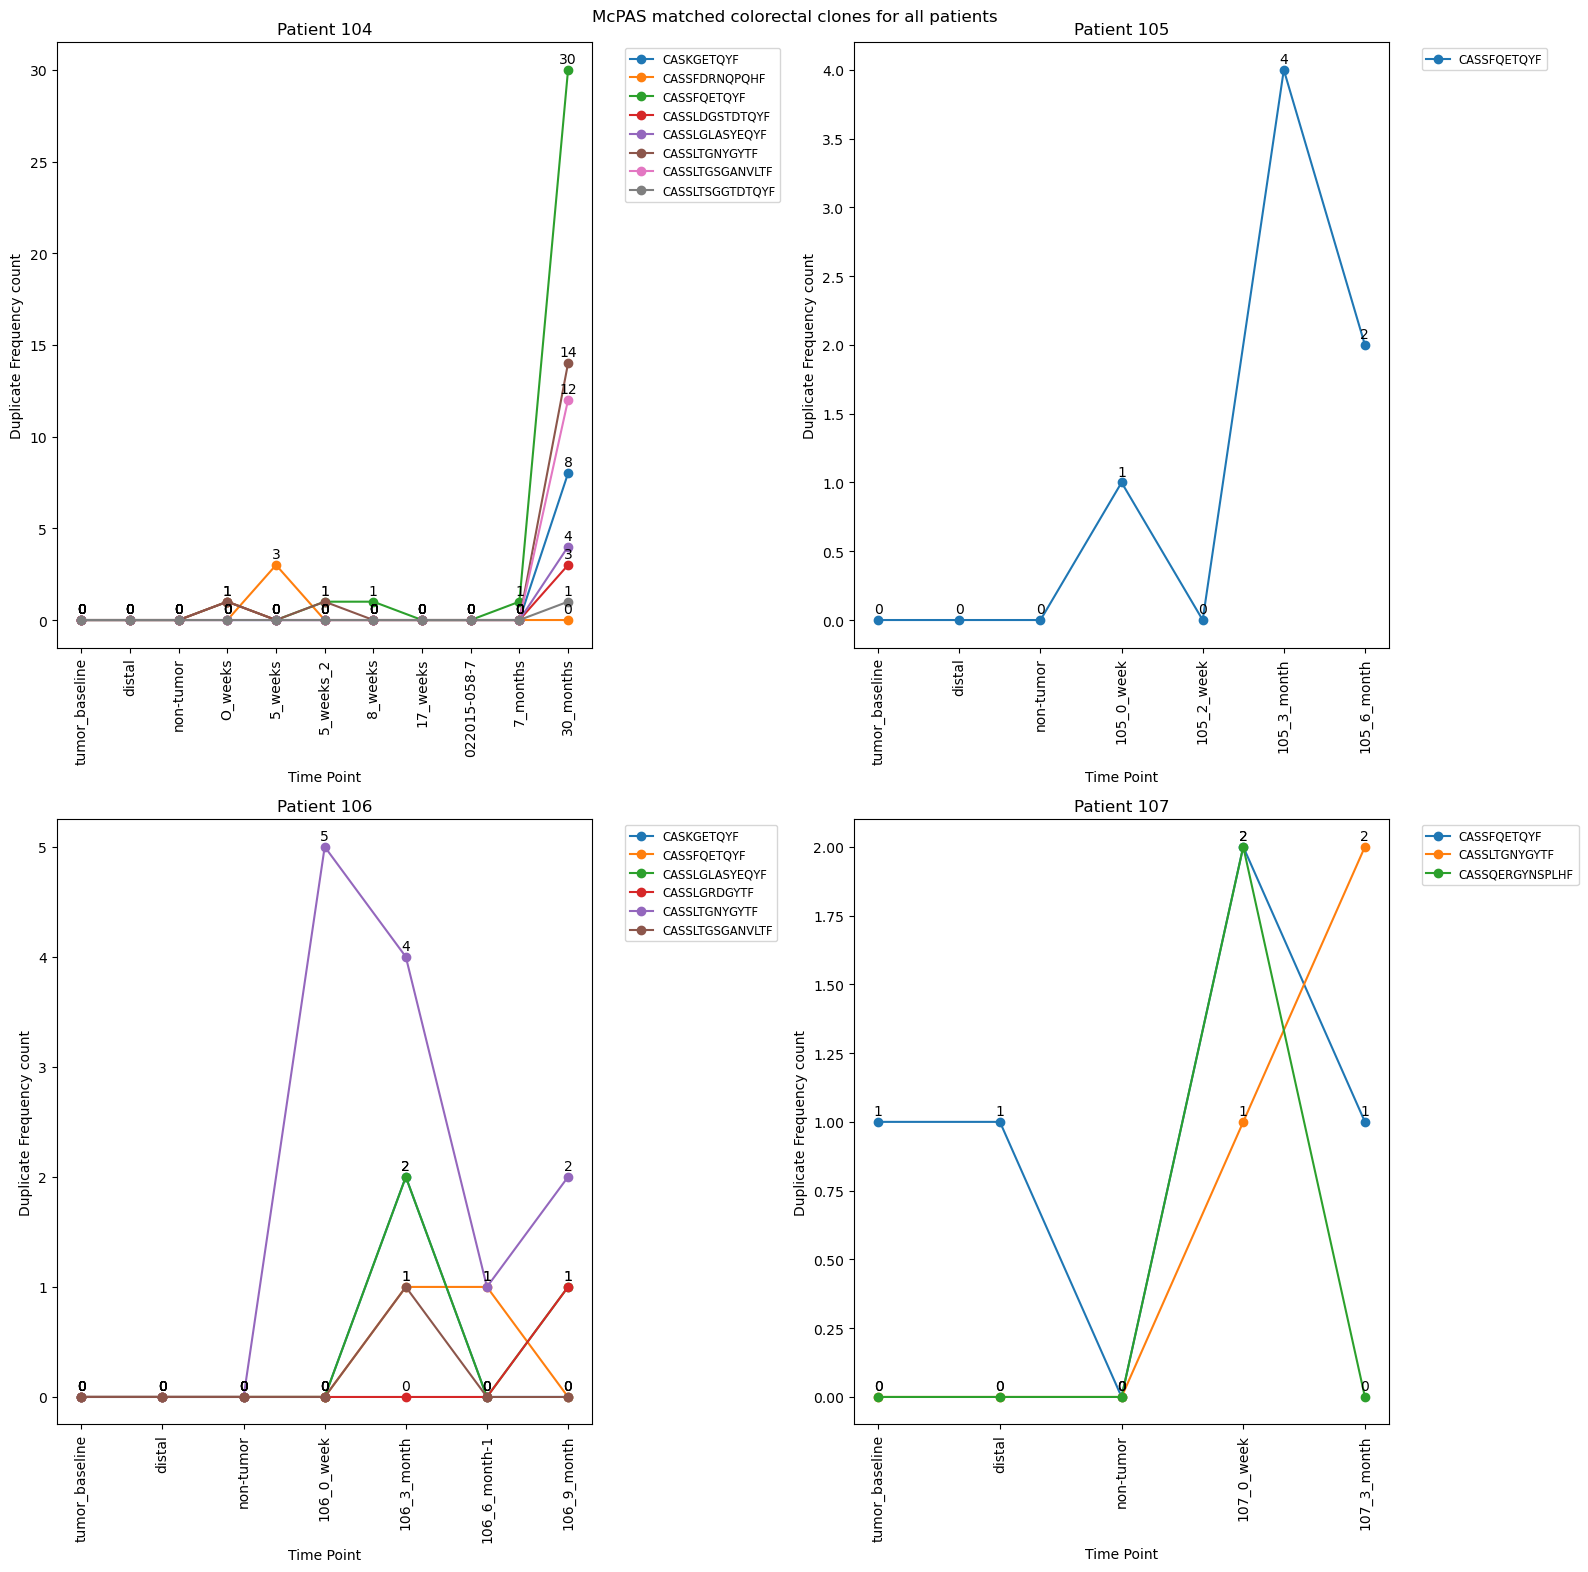

In [464]:
patient_ids = [104, 105, 106, 107]

# Collect all clones (still used for consistent color assignment)
all_clones = set()
for patient_id in patient_ids:
    all_clones.update(patient_unique_clones_dict[patient_id])
all_clones = sorted(list(all_clones))

for key, value in patient_unique_clones_dict.items():
    print(key)
    print(' '.join(f'{clone}' for clone in value))


# Define a color map (consistent across patients)
cmap = plt.get_cmap('tab20')
color_dict = {clone: cmap(i % 20) for i, clone in enumerate(all_clones)}


fig, axs = plt.subplots(2, 2, figsize=(16, 16))  # 2 rows, 2 columns
axs = axs.flatten()  # flatten for easy indexing

for i, patient_id in enumerate(patient_ids):
    all_cdr3s = []
    for file in all_patient_files[patient_id]:
        cdr3s = read_cdr3_dict(f'{dirpath}{file}.igblast.airr.tsv')
        all_cdr3s.append(cdr3s)
    
    na_clones = patient_unique_clones_dict[patient_id]
    na_clones = sorted(list(na_clones))
    time_labels = ['tumor_baseline', 'distal', 'non-tumor'] + [t_name for t_name in all_patient_files[patient_id][3:]]
    ax = axs[i]
    for clone in na_clones:
        freqs = [cdr3_dict.get(clone, 0) for cdr3_dict in all_cdr3s]
        print(patient_id, clone, freqs)
        ax.plot(time_labels, freqs, marker='o', label=clone)
        for xi, yi in zip(time_labels, freqs):
            ax.annotate(f'{yi}', (xi, yi), textcoords="offset points", xytext=(0,5), ha='center')
    
    ax.set_xlabel('Time Point')
    ax.set_ylabel('Duplicate Frequency count')
    ax.set_title(f'Patient {patient_id}')
    ax.tick_params(axis='x', rotation=90)
    ax.legend(fontsize='small', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.suptitle('McPAS matched colorectal clones for all patients')
plt.tight_layout()
# plt.savefig(f'Figures/lung_and_colorectal_clones_assosciated_tcrs_in_different_time_points.png', bbox_inches = 'tight', dpi = 300)
plt.show()


## Plots in Separate Figures

101
CASSLGTSSTDTQYF
103
CASSYSSGTEAFF CASSLGGTEAFF
104
CASSENTGELFF CASSPGTGYEQYF CASSLTGSEQYF CASSQAGEQYF CASSIGLNTEAFF CASSQVPGSYEQYF CASSLGRSSYEQYF CATSDSTGSYGYTF CASSFRGNTGELFF CASSIGGYGYTF CASSPGPYEQYF CASSPRAYNEQFF CASTGTDSYEQYF CASSGRSTDTQYF CASSYVGNTGELFF CASSQVSGGSYEQYF CASSLGGLTDTQYF CASSYGGSSYEQYF CASSISGGSYEQYF CASSPRGVGTEAFF CASSVQSTDTQYF CASSNQETQYF CASSLGGTEAFF CASSPGQGYEQYF CASSQAGGYEQYF CASSLSYEQYF CASSPGTAYEQYF CASSPTSGGYEQYF CASSLSPTDTQYF CASSYSSGTEAFF CASSQDTGYEQYF CASSLATEQFF CASSLASGNEQFF CASSGPRGYTF CASSPGGTNEKLFF CASSFGPYGYTF CASSLGPNSPLHF CASSQGYEQYF CASSVAGGYEQYF CASSLAAGGGETQYF CASSVGSQETQYF CASSPPGTYNEQFF CASSSLGGYEQYF CASSLEGEKLFF CASSLGQGLSYEQYF CASSLTGVDGYTF CASSQGLSYEQYF CASSAGGTEAFF CASSLDYNEQFF CASSAGQGYEQYF CASSFLSSYNEQFF CASSLVESEQFF CASSLGTSSTDTQYF CASSSGYNEQFF CASGSYEQYF CASSLLGNTEAFF CASSLGISYEQYF CASSPDPYEQYF CASSTGNYGYTF CASSFRGEAFF CASSRGGHEQYF CASSVSGSGTGELFF CASSGGGAEAFF CASSLRSSYEQYF CASSWTGDSNQPQHF CASSFGQGYEQYF CASSLAYEQYF CASSFNTEAFF CASS

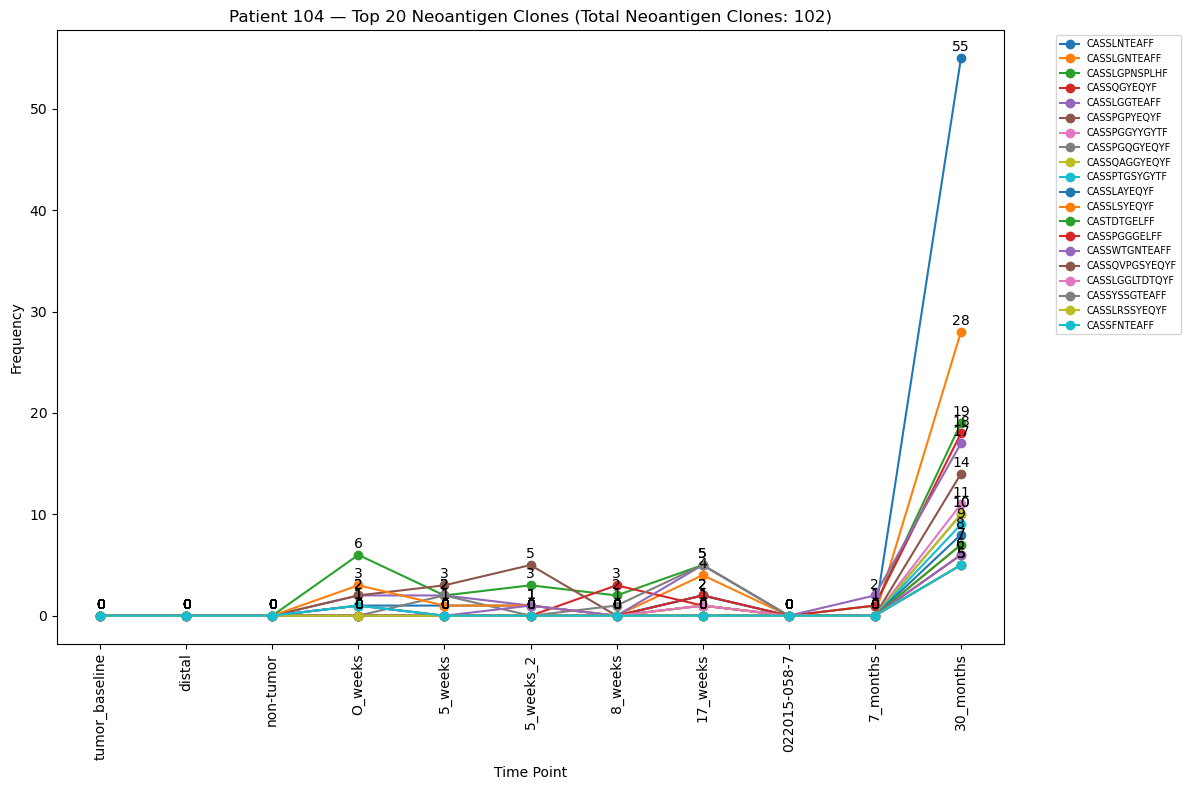

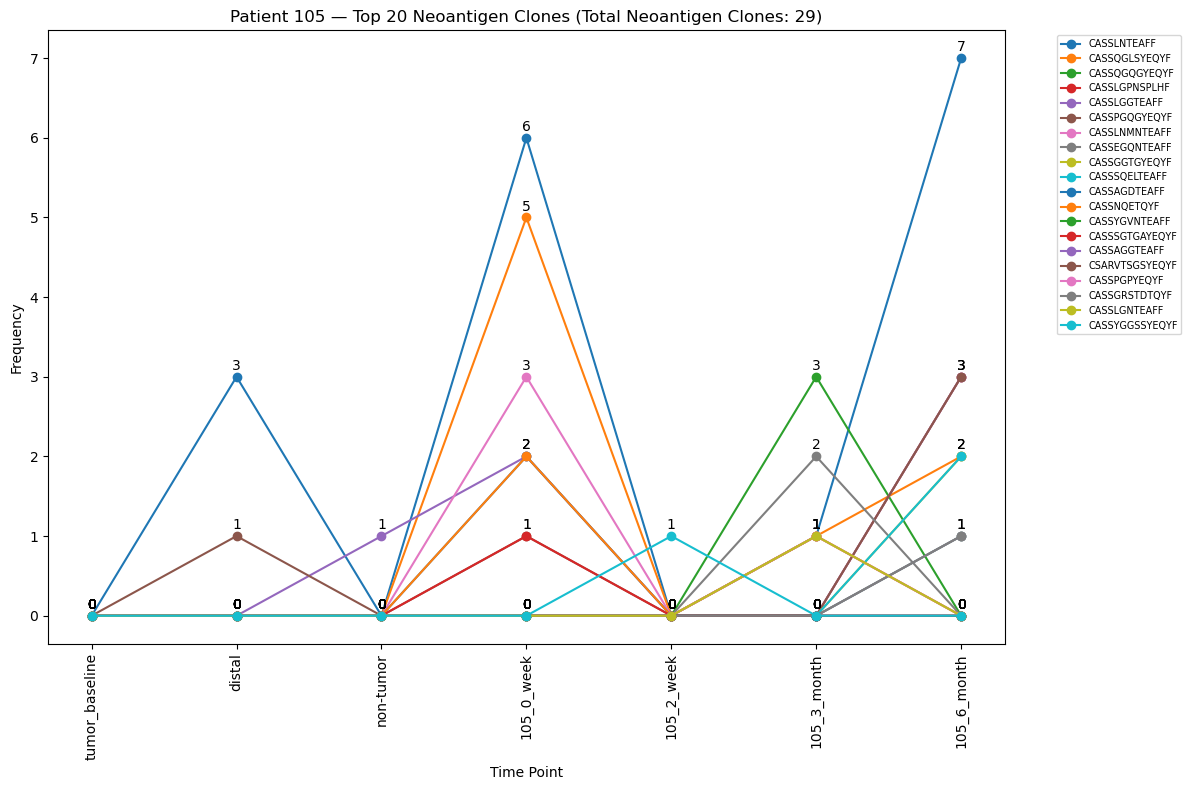

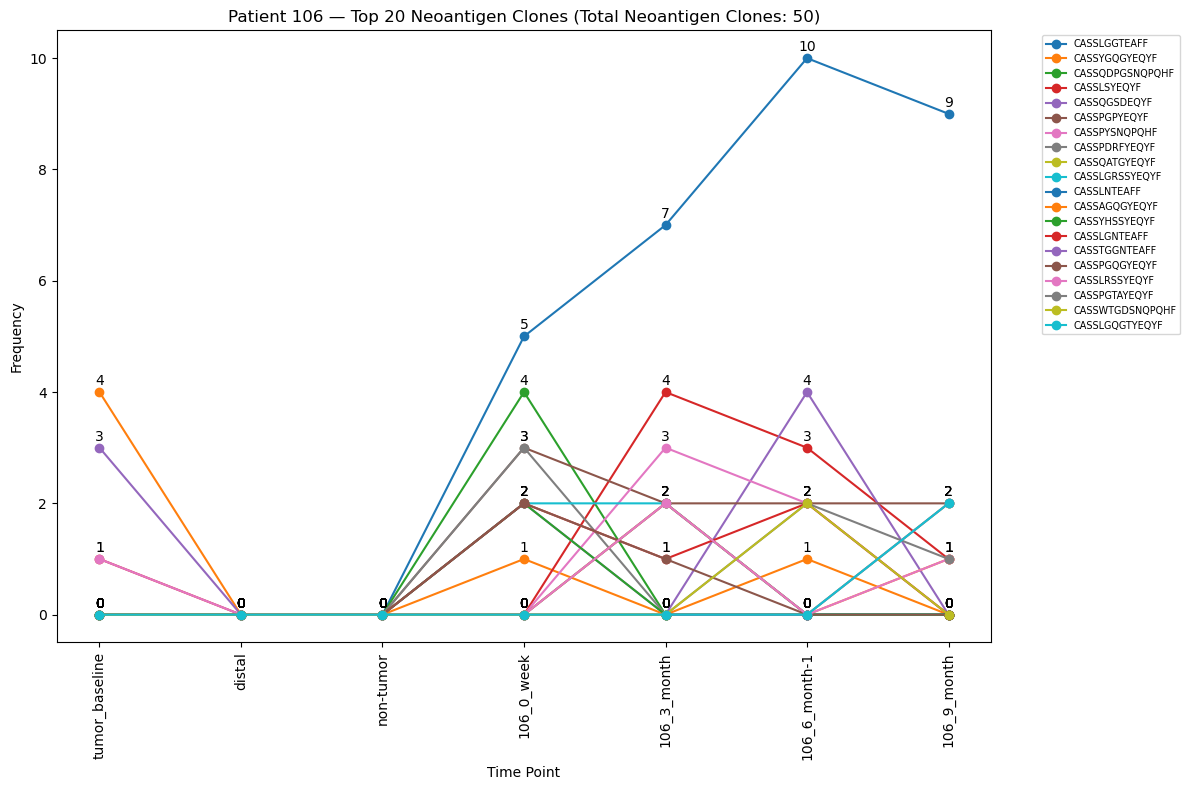

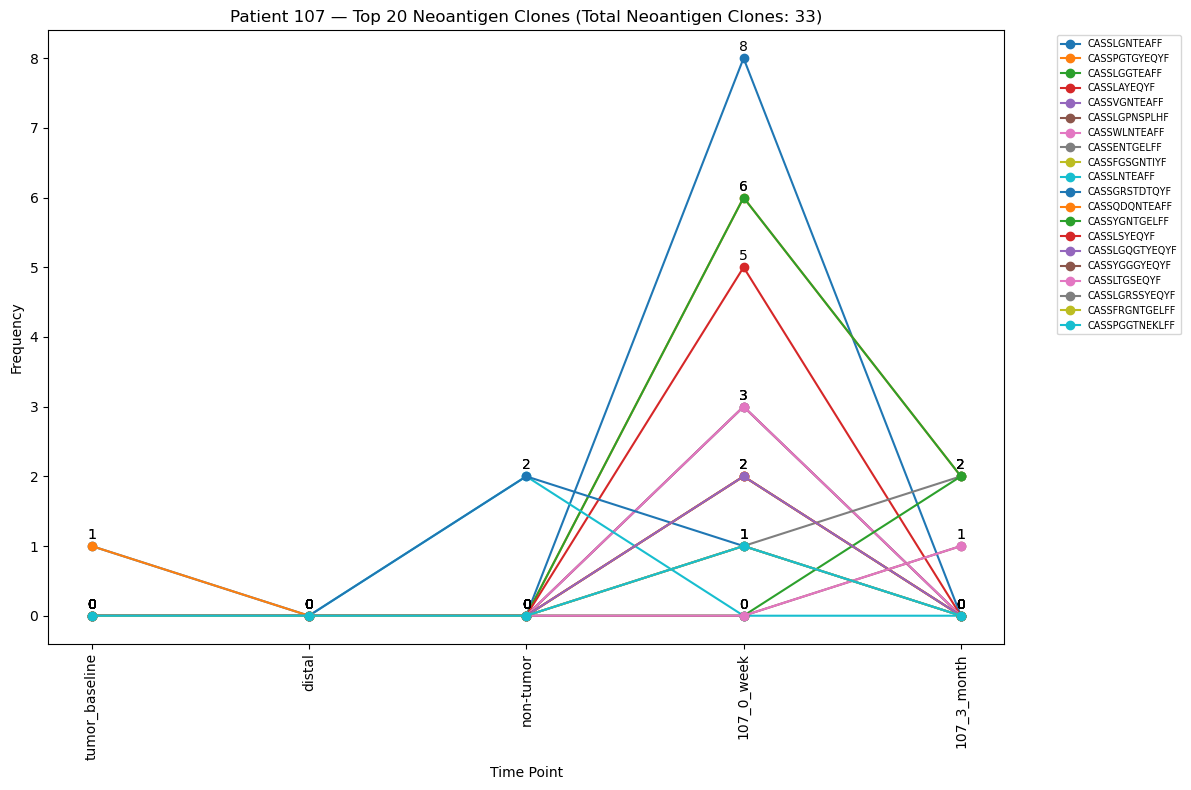

In [448]:
patient_ids = [104, 105, 106, 107]

# Collect all clones (still used for consistent color assignment)
all_clones = set()
for patient_id in patient_ids:
    all_clones.update(patient_unique_clones_dict[patient_id])
all_clones = sorted(list(all_clones))

for key, value in patient_unique_clones_dict.items():
    print(key)
    print(' '.join(f'{clone}' for clone in value))


# Define a color map (consistent across patients)
cmap = plt.get_cmap('tab20')
color_dict = {clone: cmap(i % 20) for i, clone in enumerate(all_clones)}

# Loop through patients and plot top 20 clones
for patient_id in patient_ids:
    fig, ax = plt.subplots(figsize=(12, 8))  # One figure per patient

    # Read all time point files
    all_cdr3s = []
    for file in all_patient_files[patient_id]:
        cdr3s = read_cdr3_dict(f'{dirpath}{file}.igblast.airr.tsv')
        all_cdr3s.append(cdr3s)

    # Timepoint labels
    time_labels = ['tumor_baseline', 'distal', 'non-tumor'] + all_patient_files[patient_id][3:]

    # Calculate maximum frequency of each clone
    clone_max_freqs = {}
    for clone in patient_unique_clones_dict[patient_id]:
        freqs = [cdr3_dict.get(clone, 0) for cdr3_dict in all_cdr3s]
        clone_max_freqs[clone] = max(freqs)

    # Get top 20 clones by max frequency
    top_clones = sorted(clone_max_freqs.items(), key=lambda x: x[1], reverse=True)[:20]
    top_clones = [clone for clone, _ in top_clones]
    # cmap = plt.get_cmap('tab20')
    # color_dict = {clone: cmap(i % 20) for i, clone in enumerate(top_clones)}

    # Plot each clone
    for clone in top_clones:
        freqs = [cdr3_dict.get(clone, 0) for cdr3_dict in all_cdr3s]
        # ax.plot(time_labels, freqs, marker='o', label=clone, color=color_dict.get(clone, 'gray'))
        ax.plot(time_labels, freqs, marker='o', label=clone)
        for xi, yi in zip(time_labels, freqs):
            ax.annotate(f'{yi}', (xi, yi), textcoords="offset points", xytext=(0, 5), ha='center')
    # Count of neoantigen-associated clones
    neoantigen_clone_count = len(patient_unique_clones_dict[patient_id])
    ax.set_title(f'Patient {patient_id} — Top 20 Neoantigen Clones (Total Neoantigen Clones: {neoantigen_clone_count})')
    ax.set_xlabel('Time Point')
    ax.set_ylabel('Frequency')
    ax.tick_params(axis='x', rotation=90)
    ax.legend(fontsize='x-small', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()

    # Save and show
    fig.savefig(f'Figures/Patient_{patient_id}_top20_clonal_dynamics.png', bbox_inches='tight', dpi=300)
    plt.show()


## Plot all NA sequence and their frequency for each patient

104
CASSLGSQETQYF CASSPGTGPYEQYF CASSPGQGAETQYF
105
CASSQGGGGQFF CASSFGTSSTDTQYF CASSPGPLNTEAFF CASSSGGADTQYF CASSSSGGLNEKLFF CASSLAGLAGKTQYF CSARVTSGSYEQYF CASSSQETQYF CASSDYSNQPQHF CASSLGGAQPQHF CASSYGQGSYEQYF CASSQGQMNTEAFF CASSPGRTQYF CASSLGGGTEAFF CASGGQLNTEAFF CASSEGPSGYTF CASSLGAGGAYEQYF CASSQGYEQYF CASSLGSGSTDTQYF CASSLDRETQYF CASSIGYEQYF
106
CASSLGMNTEAFF CASSEGNTEAFF CASSPGREQFF CASSLASQTETQYF CASSPGPLNTEAFF CASSSSSGANVLTF CASSQGTGAYEQYF CASSSQGGYGYTF CASSQVSNYGYTF CASSLQGTYEQYF CASSLGYEQYF CASSAGEGTEAFF CASSQAGGTGELFF CASSADYEQYF CATSAGDTEAFF CASSQGSDEQYF CASSMGYEQYF CASSYLGDEQFF CASSYSNTEAFF CASSPLGDTQYF CASSPTGNTEAFF CASSQGVYEQYF CASSLGGGYEQYF CASSFSGDEQFF CASSWMNTEAFF CASSISGGETQYF CASSYGQGYEQYF CASSSGGYNEQFF CASSQGSLNTGELFF CASSLSNQPQHF
107
CASSPSGNEQFF CASSLGMNTEAFF CASSLGYEQYF CASSSRSTDTQYF CASSLSTEAFF CASSLSGGTEAFF CASSLDWGTYEQYF CASSSSGGADTQYF CASSLGLNTEAFF CASSSSTDTQYF CASSPTLGSSYEQYF CSAGDGEQFF
CASGGQLNTEAFF CASSADYEQYF CASSAGEGTEAFF CASSDYSNQPQHF CASSEGNTEAFF CASS

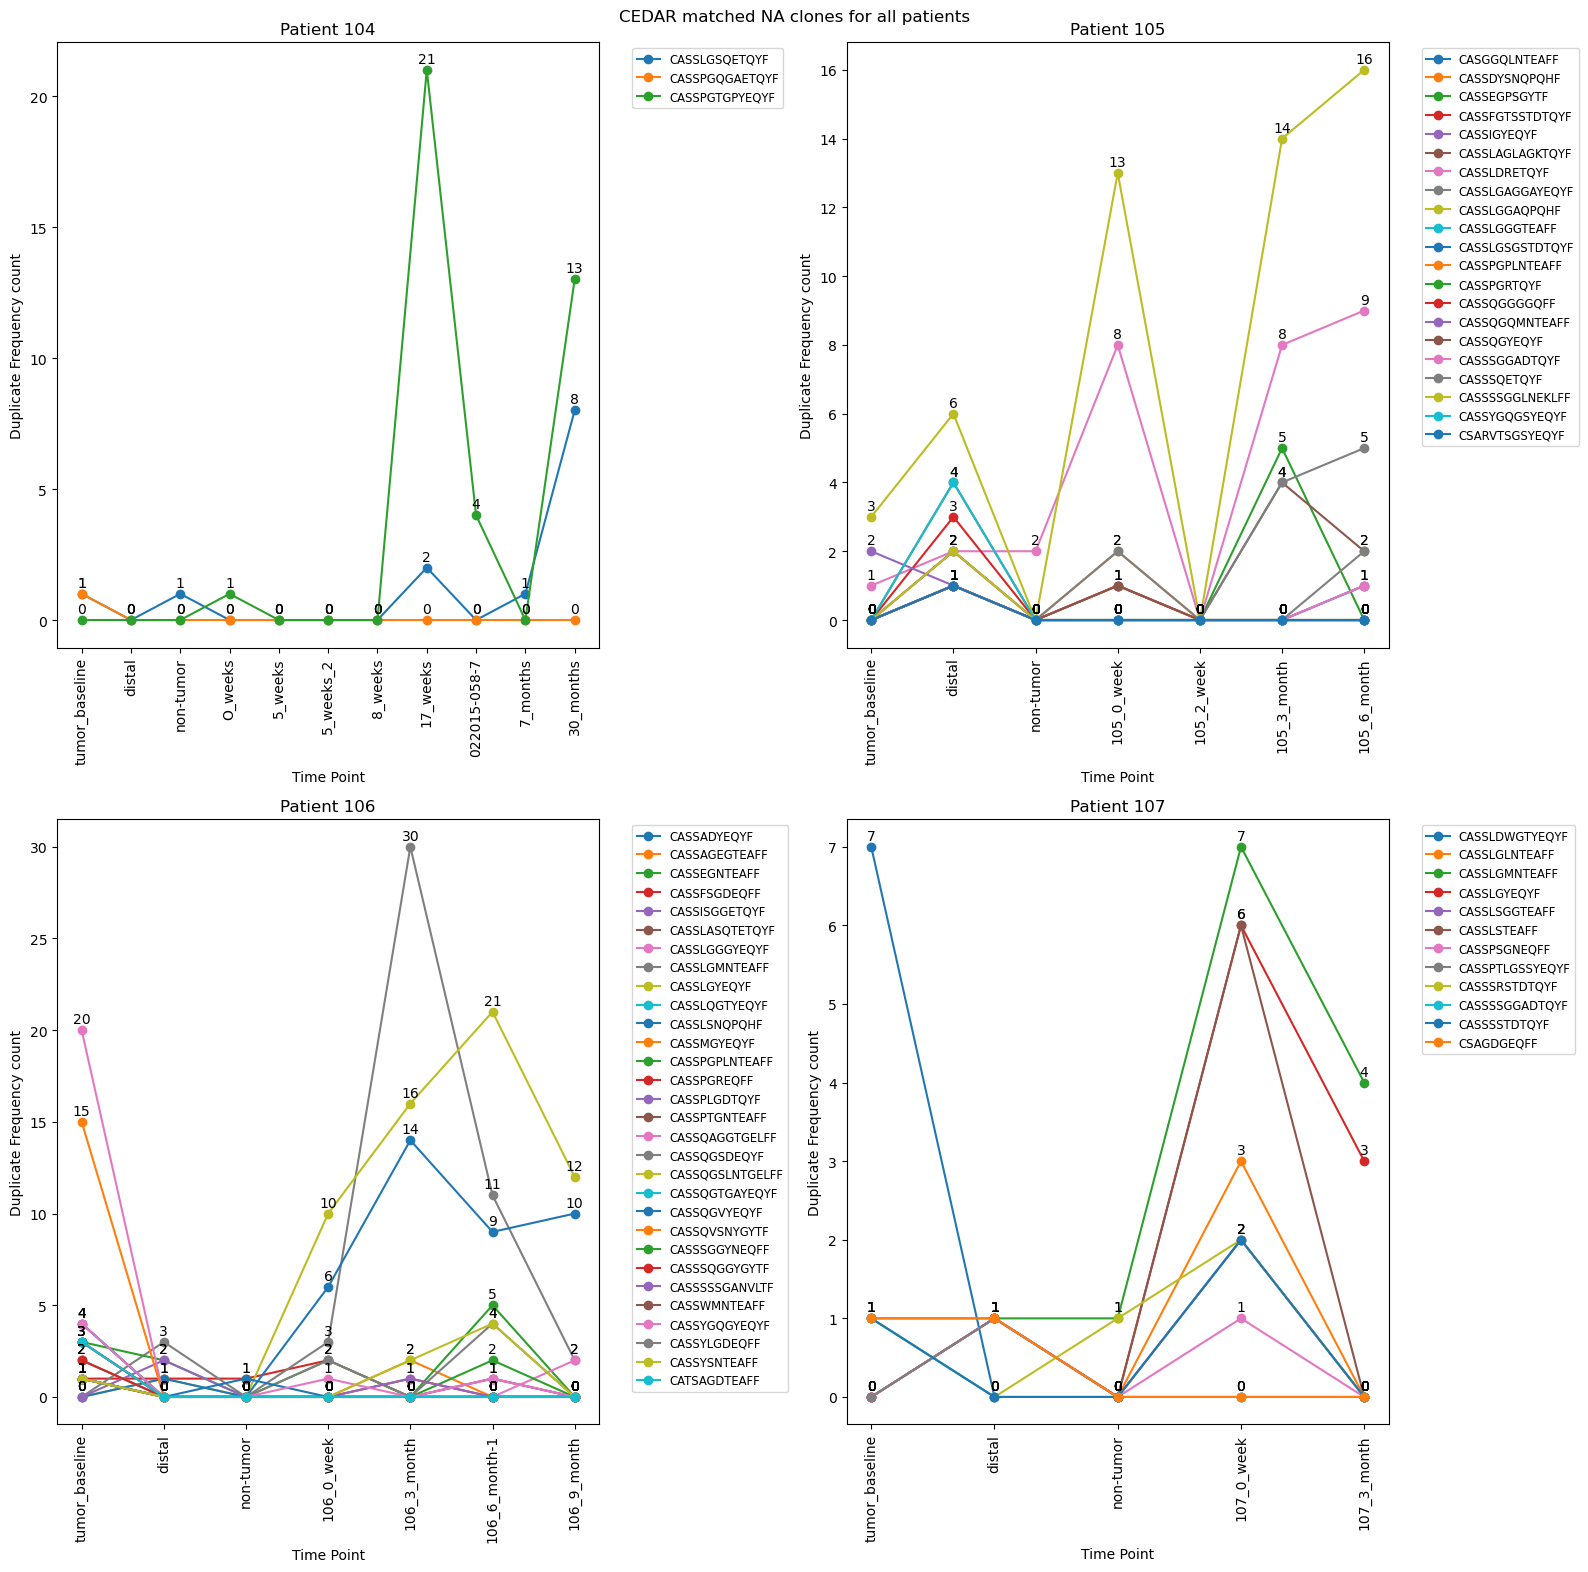

In [437]:
# all_patient_files = {101: ['Thr_101_25516-1', 'Thr_101_25519-1', 'Thr_101_25516_9'],
#  103: ['Thr_103_26277_1', 'Thr_103_26276-1', 'Thr_103_26277_3'],
#  104: ['24673-6', '26473-1', '24563-5', 'lung_biopsy', 'O_weeks', '5_weeks', '5_weeks_2', '8_weeks', '17_weeks', '7_months', '30_months'],
#  105: ['Thr_105_28473_3', 'Thr_105_28473_2H', 'Thr_105_28474-4', '105_0_week', '105_2_week', '105_3_month', '105_6_month'],
#  106: ['Thr_106_30817-2', 'Thr_106_30818_1', 'Thr_106_30817_1', '106_0_week', '106_3_month', '106_6_month-1', '106_9_month'],
#  107: ['Thr_107_31626-3', 'Thr_107_31627-1', 'Thr_107_31626_1', '107_0_week', '107_3_month']}

all_patient_files = {101: ['Thr_101_25516-1', 'Thr_101_25519-1', 'Thr_101_25516_9'],
 103: ['Thr_103_26277_1', 'Thr_103_26276-1', 'Thr_103_26277_3'],
 104: ['24673-6', '26473-1', '24563-5',  'O_weeks', '5_weeks', '5_weeks_2', '8_weeks', '17_weeks', '022015-058-7', '7_months', '30_months'],
 105: ['Thr_105_28473_3', 'Thr_105_28473_2H', 'Thr_105_28474-4', '105_0_week', '105_2_week', '105_3_month', '105_6_month'],
 106: ['Thr_106_30817-2', 'Thr_106_30818_1', 'Thr_106_30817_1', '106_0_week', '106_3_month', '106_6_month-1', '106_9_month'],
 107: ['Thr_107_31626-3', 'Thr_107_31627-1', 'Thr_107_31626_1', '107_0_week', '107_3_month']}

all_na_sequences = {104: set(), 105: set(), 106: set(), 107: set()}

for patient_id in [104, 105, 106, 107]:
    patient_info = all_patient_files[patient_id]
    for file in ['baseline'] + patient_info[3:]:
        sample = file.split('.')[0]
        df = pd.read_csv(f'./TCROutput/{patient_id}_{sample}_common_tumor_tcrmatch.tsv', sep = '\t')
        all_na_sequences[patient_id].update([seq for seq in df[df.isna().any(axis=1)]['trimmed_input_sequence'].values])

for key, value in all_na_sequences.items():
    print(key)
    print(' '.join(f'C{clone}F' for clone in value))


all_clones = set()
for patient_id in [104, 105, 106, 107]:
    all_clones.update(all_na_sequences[patient_id])
all_clones = sorted(list(all_clones))
print(' '.join(f'C{clone}F' for clone in all_clones))
cmap = plt.get_cmap('tab20')
color_dict = {f'C{clone}F':cmap(i%20) for i, clone in enumerate(all_clones)}

fig, axs = plt.subplots(2, 2, figsize=(16, 16))  # 2 rows, 2 columns
axs = axs.flatten()  # flatten for easy indexing

for i, patient_id in enumerate([104, 105, 106, 107]):
    all_cdr3s = []
    for file in all_patient_files[patient_id]:
        cdr3s = read_cdr3_dict(f'{dirpath}{file}.igblast.airr.tsv')
        all_cdr3s.append(cdr3s)
    
    na_clones = all_na_sequences[patient_id]
    na_clones = sorted(list(na_clones))
    time_labels = ['tumor_baseline'] + ['distal'] + ['non-tumor'] + [t_name for t_name in all_patient_files[patient_id][3:]]
    ax = axs[i]
    for clone in na_clones:
        clone = f'C{clone}F'
        freqs = [cdr3_dict.get(clone, 0) for cdr3_dict in all_cdr3s]
        print(patient_id, clone, freqs)
        ax.plot(time_labels, freqs, marker='o', label=clone)
        for xi, yi in zip(time_labels, freqs):
            ax.annotate(f'{yi}', (xi, yi), textcoords="offset points", xytext=(0,5), ha='center')
    
    ax.set_xlabel('Time Point')
    ax.set_ylabel('Duplicate Frequency count')
    ax.set_title(f'Patient {patient_id}')
    ax.tick_params(axis='x', rotation=90)
    ax.legend(fontsize='small', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.suptitle('CEDAR matched NA clones for all patients')
plt.tight_layout()
plt.savefig(f'Figures/cedardb_na_clones_assosciated_tcrs_in_different_time_points.png', bbox_inches = 'tight', dpi = 300)
plt.show()


## Patient 104 Detailed Analysis

tumor total: 551
non-tumor total: 1600
lung biopsy total: 104
shared: 138
tumor unique: 413
non-tumor unique: 1462
shared: 5
tumor unique: 408
lung unique: 99



*****
tumor total: 551
non-tumor total: 1600
shared: 138
tumor unique: 413
non-tumor unique: 1462
*****


*****
TMNT total: 413
lung total: 104
shared: 5
TMNT unique: 408
lung unique: 99
*****


*****
non-tumor total: 1600
lung total: 104
shared: 9
non-tumor unique: 1591
lung unique: 95
*****

Total Tumor: 551 
Total Non-Tumor: 1600 
Total Lung: 104


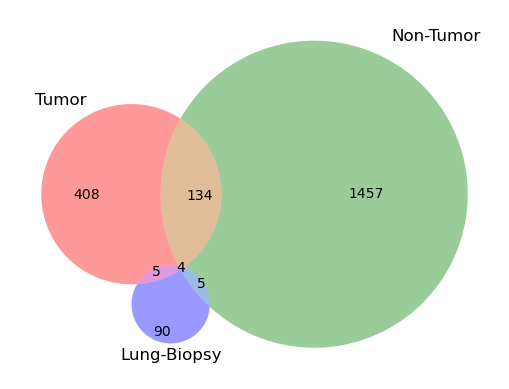


*****
TMNT total: 413
time 0 total: 34336
shared: 89
TMNT unique: 324
time 0 unique: 34247
*****


*****
TMNT total: 413
time 1 total: 10227
shared: 65
TMNT unique: 348
time 1 unique: 10162
*****


*****
TMNT total: 413
time 2 total: 19080
shared: 78
TMNT unique: 335
time 2 unique: 19002
*****


*****
TMNT total: 413
time 3 total: 6232
shared: 45
TMNT unique: 368
time 3 unique: 6187
*****


*****
TMNT total: 413
time 4 total: 48828
shared: 120
TMNT unique: 293
time 4 unique: 48708
*****


*****
TMNT total: 413
time 5 total: 8949
shared: 71
TMNT unique: 342
time 5 unique: 8878
*****


*****
TMNT total: 413
time 6 total: 99809
shared: 127
TMNT unique: 286
time 6 unique: 99682
*****


*****
TMNT total: 413
all time total: 23
shared: 23
TMNT unique: 390
all time unique: 0
*****

CASSIGTYGYTF,8,5,1,2,2,2,40,1
CASSSAGDNEKLFF,56,29,63,100,591,200,4962,1
CASSLVIPRGNEQFF,9,5,3,2,18,3,123,1
CARIGTGGANSYNEQFF,5,3,1,1,11,2,43,1
CASSDRAADPYGYTF,28,5,12,11,30,15,21,2
CASSLLGLATNEQFF,7,1,7,3,14,6,84

In [317]:
dirpath = '/home/s234499/Projects/HannanLab/abscopal/vdjserver/2403978270247808535-242ac11b-0001-007/'
dirpath = '/home/s234499/Projects/HannanLab/abscopal/vdjserver/853273733430055401-242ac11d-0001-007/'

tumor_file = "24673-6.igblast.airr.tsv"
nontumor_file = "24563-5.igblast.airr.tsv"
lung_file = "022015-058-7.igblast.airr.tsv"
distal_file = '26473-1.igblast.airr.tsv'
time_files = [
    "O_weeks.igblast.airr.tsv",
    "5_weeks.igblast.airr.tsv",
    "5_weeks_2.igblast.airr.tsv",
    "8_weeks.igblast.airr.tsv",
    "17_weeks.igblast.airr.tsv",
    "7_months.igblast.airr.tsv",
    "30_months.igblast.airr.tsv"
    ]
#
# tumor-associated CDR3s
#
tumor_cdr3 = read_cdr3_dict(dirpath + tumor_file)
nontumor_cdr3 = read_cdr3_dict(dirpath + nontumor_file)
lung_cdr3 = read_cdr3_dict(dirpath + lung_file)

time_cdr3 = []
for f in time_files:
    time_cdr3.append(read_cdr3_dict(dirpath + f))

    
A = set(tumor_cdr3.keys())
B = set(nontumor_cdr3.keys())
C = set(lung_cdr3.keys())

print("tumor total: " + str(len(A)))
print("non-tumor total: " + str(len(B)))
print("lung biopsy total: " + str(len(C)))
X = A & B
TANT = A & B
print("shared: " + str(len(X)))
TMNT = A - B
print("tumor unique: " + str(len(TMNT)))
X = B - A
print("non-tumor unique: " + str(len(X)))

X = TMNT & C
print("shared: " + str(len(X)))
X = TMNT - C
print("tumor unique: " + str(len(X)))
X = C - TMNT
print("lung unique: " + str(len(X)))
print('\n')

venn_cdr3("tumor", A, "non-tumor", B)

venn_cdr3("TMNT", TMNT, "lung", C)

venn_cdr3("non-tumor", B, "lung", C)

A = set(tumor_cdr3.keys())
B = set(nontumor_cdr3.keys())
C = set(lung_cdr3.keys())
print(f'Total Tumor: {len(A)} \nTotal Non-Tumor: {len(B)} \nTotal Lung: {len(C)}')
venn3([A, B, C], ('Tumor', 'Non-Tumor', 'Lung-Biopsy'))
plt.show()


i = 0
time_set = []
for f in time_cdr3:
    X = set(f.keys())
    venn_cdr3("TMNT", TMNT, "time " + str(i), X)
    i += 1
    time_set.append(TMNT & X)

X = time_set[0] & time_set[1] & time_set[2] & time_set[3] & time_set[4] & time_set[5] & time_set[6]
venn_cdr3("TMNT", TMNT, "all time", X)

X = TMNT & X
for f in X:
    print(f +','+ str(time_cdr3[0][f]) +','+ str(time_cdr3[1][f])
          +','+ str(time_cdr3[2][f]) +','+ str(time_cdr3[3][f]) +','+ str(time_cdr3[4][f]) +','+ str(time_cdr3[5][f])
          +','+ str(time_cdr3[6][f]) +','+ str(tumor_cdr3[f]))

venn_cdr3("TMNT, all time", X, "lung", C)
X = X & C
for f in X: print(f +','+ str(tumor_cdr3[f]) +','+ str(lung_cdr3[f]))

i = 0
time_set = []
for f in time_cdr3:
    X = set(f.keys())
    venn_cdr3("T&NT", TANT, "time " + str(i), X)
    i += 1
    time_set.append(TANT & X)

X = time_set[0] & time_set[1] & time_set[2] & time_set[3] & time_set[4] & time_set[5] & time_set[6]
venn_cdr3("T&NT", TANT, "all time", X)
venn_cdr3("T&NT", TANT, "lung", C)

X = TANT & X

for f in X:
    print(f +','+ str(time_cdr3[0][f]) +','+ str(time_cdr3[1][f])
          +','+ str(time_cdr3[2][f]) +','+ str(time_cdr3[3][f]) +','+ str(time_cdr3[4][f]) +','+ str(time_cdr3[5][f])
          +','+ str(time_cdr3[6][f])
          +','+ str(tumor_cdr3[f]) +','+ str(nontumor_cdr3[f]))

venn_cdr3("TANT, all time", X, "lung", C)
X = X & C
for f in X: print(f +','+ str(tumor_cdr3[f]) +','+ str(lung_cdr3[f]))

time_set = []
for f in time_cdr3:
    time_set.append(set(f.keys()))

T5 = time_set[1] | time_set[2]
venn_cdr3("0 weeks", time_set[0], "5 weeks", T5)

X = T5 - time_set[0]
venn_cdr3("5 weeks", X, "TMNT", TMNT)
venn_cdr3("5 weeks", X, "T&NT", TANT)

X = X & TMNT
for f in X:
    n1 = ''
    n2 = ''
    if time_cdr3[1].get(f): n1 = str(time_cdr3[1][f])
    if time_cdr3[2].get(f): n2 = str(time_cdr3[2][f])
    print(f +','+ n1 +','+ n2 +','+ str(tumor_cdr3[f]))

T1P = time_set[1] | time_set[2] | time_set[3] | time_set[4] | time_set[5] | time_set[6]
venn_cdr3("0 weeks", time_set[0], "after 0", T1P)

T0P = time_set[0] | time_set[1] | time_set[2] | time_set[3] | time_set[4] | time_set[5] | time_set[6]
venn_cdr3("any time", T0P, "TMNT", TMNT)
venn_cdr3("any time", T0P, "T&NT", TANT)

T1P = T0P - time_set[0]
venn_cdr3("only after 0", T1P, "TMNT", TMNT)
venn_cdr3("only after 0", T1P, "T&NT", TANT)

T2P = (T1P - time_set[1]) - time_set[2]
venn_cdr3("only after 5", T2P, "TMNT", TMNT)
venn_cdr3("only after 5", T2P, "T&NT", TANT)

T3P = T2P - time_set[3]
venn_cdr3("only after 8", T3P, "TMNT", TMNT)
venn_cdr3("only after 8", T3P, "T&NT", TANT)

T4P = T3P - time_set[4]
venn_cdr3("only after 17", T4P, "TMNT", TMNT)
venn_cdr3("only after 17", T4P, "T&NT", TANT)

T5P = T4P - time_set[5]
venn_cdr3("only 7 months", T5P, "TMNT", TMNT)
venn_cdr3("only 7 months", T5P, "T&NT", TANT)

X = T5P & TMNT
for f in X:
    n0 = ''
    n1 = ''
    n2 = ''
    n3 = ''
    n4 = ''
    n5 = ''
    n6 = ''
    if time_cdr3[0].get(f): n0 = str(time_cdr3[0][f])
    if time_cdr3[1].get(f): n1 = str(time_cdr3[1][f])
    if time_cdr3[2].get(f): n2 = str(time_cdr3[2][f])
    if time_cdr3[3].get(f): n3 = str(time_cdr3[3][f])
    if time_cdr3[4].get(f): n4 = str(time_cdr3[4][f])
    if time_cdr3[5].get(f): n5 = str(time_cdr3[5][f])
    if time_cdr3[6].get(f): n6 = str(time_cdr3[6][f])
    print(f +','+ n0 +','+ n1 +','+ n2 +','+ n3 +','+ n4 +','+ n5 +','+ n6 +',,'+ str(tumor_cdr3[f]))

print('')
X = (T4P - T5P) & TMNT
for f in X:
    n0 = ''
    n1 = ''
    n2 = ''
    n3 = ''
    n4 = ''
    n5 = ''
    n6 = ''
    if time_cdr3[0].get(f): n0 = str(time_cdr3[0][f])
    if time_cdr3[1].get(f): n1 = str(time_cdr3[1][f])
    if time_cdr3[2].get(f): n2 = str(time_cdr3[2][f])
    if time_cdr3[3].get(f): n3 = str(time_cdr3[3][f])
    if time_cdr3[4].get(f): n4 = str(time_cdr3[4][f])
    if time_cdr3[5].get(f): n5 = str(time_cdr3[5][f])
    if time_cdr3[6].get(f): n6 = str(time_cdr3[6][f])
    print(f +','+ n0 +','+ n1 +','+ n2 +','+ n3 +','+ n4 +','+ n5 +','+ n6 +',,'+ str(tumor_cdr3[f]))

print('')
X = (T3P - T4P - T5P) & TMNT
for f in X:
    n0 = ''
    n1 = ''
    n2 = ''
    n3 = ''
    n4 = ''
    n5 = ''
    n6 = ''
    if time_cdr3[0].get(f): n0 = str(time_cdr3[0][f])
    if time_cdr3[1].get(f): n1 = str(time_cdr3[1][f])
    if time_cdr3[2].get(f): n2 = str(time_cdr3[2][f])
    if time_cdr3[3].get(f): n3 = str(time_cdr3[3][f])
    if time_cdr3[4].get(f): n4 = str(time_cdr3[4][f])
    if time_cdr3[5].get(f): n5 = str(time_cdr3[5][f])
    if time_cdr3[6].get(f): n6 = str(time_cdr3[6][f])
    print(f +','+ n0 +','+ n1 +','+ n2 +','+ n3 +','+ n4 +','+ n5 +','+ n6 +',,'+ str(tumor_cdr3[f]))

print('')
X = (T2P - T3P - T4P - T5P) & TMNT
for f in X:
    n0 = ''
    n1 = ''
    n2 = ''
    n3 = ''
    n4 = ''
    n5 = ''
    n6 = ''
    if time_cdr3[0].get(f): n0 = str(time_cdr3[0][f])
    if time_cdr3[1].get(f): n1 = str(time_cdr3[1][f])
    if time_cdr3[2].get(f): n2 = str(time_cdr3[2][f])
    if time_cdr3[3].get(f): n3 = str(time_cdr3[3][f])
    if time_cdr3[4].get(f): n4 = str(time_cdr3[4][f])
    if time_cdr3[5].get(f): n5 = str(time_cdr3[5][f])
    if time_cdr3[6].get(f): n6 = str(time_cdr3[6][f])
    print(f +','+ n0 +','+ n1 +','+ n2 +','+ n3 +','+ n4 +','+ n5 +','+ n6 +',,'+ str(tumor_cdr3[f]))

print('')
X = (T1P - T2P - T3P - T4P - T5P) & TMNT
for f in X:
    n0 = ''
    n1 = ''
    n2 = ''
    n3 = ''
    n4 = ''
    n5 = ''
    n6 = ''
    if time_cdr3[0].get(f): n0 = str(time_cdr3[0][f])
    if time_cdr3[1].get(f): n1 = str(time_cdr3[1][f])
    if time_cdr3[2].get(f): n2 = str(time_cdr3[2][f])
    if time_cdr3[3].get(f): n3 = str(time_cdr3[3][f])
    if time_cdr3[4].get(f): n4 = str(time_cdr3[4][f])
    if time_cdr3[5].get(f): n5 = str(time_cdr3[5][f])
    if time_cdr3[6].get(f): n6 = str(time_cdr3[6][f])
    print(f +','+ n0 +','+ n1 +','+ n2 +','+ n3 +','+ n4 +','+ n5 +','+ n6 +',,'+ str(tumor_cdr3[f]))

print('')
Y = time_set[0] & time_set[1] & time_set[2] & time_set[3] & time_set[4] & time_set[5] & time_set[6]
Y = Y & TMNT
X = (T0P - T1P - T2P - T3P - T4P - T5P - Y) & TMNT
for f in X:
    n0 = ''
    n1 = ''
    n2 = ''
    n3 = ''
    n4 = ''
    n5 = ''
    n6 = ''
    if time_cdr3[0].get(f): n0 = str(time_cdr3[0][f])
    if time_cdr3[1].get(f): n1 = str(time_cdr3[1][f])
    if time_cdr3[2].get(f): n2 = str(time_cdr3[2][f])
    if time_cdr3[3].get(f): n3 = str(time_cdr3[3][f])
    if time_cdr3[4].get(f): n4 = str(time_cdr3[4][f])
    if time_cdr3[5].get(f): n5 = str(time_cdr3[5][f])
    if time_cdr3[6].get(f): n6 = str(time_cdr3[6][f])
    print(f +','+ n0 +','+ n1 +','+ n2 +','+ n3 +','+ n4 +','+ n5 +','+ n6 +',,'+ str(tumor_cdr3[f]))

print('****')

X = T5P & TANT
for f in X:
    n0 = ''
    n1 = ''
    n2 = ''
    n3 = ''
    n4 = ''
    n5 = ''
    n6 = ''
    if time_cdr3[0].get(f): n0 = str(time_cdr3[0][f])
    if time_cdr3[1].get(f): n1 = str(time_cdr3[1][f])
    if time_cdr3[2].get(f): n2 = str(time_cdr3[2][f])
    if time_cdr3[3].get(f): n3 = str(time_cdr3[3][f])
    if time_cdr3[4].get(f): n4 = str(time_cdr3[4][f])
    if time_cdr3[5].get(f): n5 = str(time_cdr3[5][f])
    if time_cdr3[6].get(f): n6 = str(time_cdr3[6][f])
    print(f +','+ n0 +','+ n1 +','+ n2 +','+ n3 +','+ n4 +','+ n5 +','+ n6 +',,'+ str(tumor_cdr3[f]) +','+ str(nontumor_cdr3[f]))

print('')
X = (T4P - T5P) & TANT
for f in X:
    n0 = ''
    n1 = ''
    n2 = ''
    n3 = ''
    n4 = ''
    n5 = ''
    n6 = ''
    if time_cdr3[0].get(f): n0 = str(time_cdr3[0][f])
    if time_cdr3[1].get(f): n1 = str(time_cdr3[1][f])
    if time_cdr3[2].get(f): n2 = str(time_cdr3[2][f])
    if time_cdr3[3].get(f): n3 = str(time_cdr3[3][f])
    if time_cdr3[4].get(f): n4 = str(time_cdr3[4][f])
    if time_cdr3[5].get(f): n5 = str(time_cdr3[5][f])
    if time_cdr3[6].get(f): n6 = str(time_cdr3[6][f])
    print(f +','+ n0 +','+ n1 +','+ n2 +','+ n3 +','+ n4 +','+ n5 +','+ n6 +',,'+ str(tumor_cdr3[f]) +','+ str(nontumor_cdr3[f]))

print('')
X = (T3P - T4P - T5P) & TANT
for f in X:
    n0 = ''
    n1 = ''
    n2 = ''
    n3 = ''
    n4 = ''
    n5 = ''
    n6 = ''
    if time_cdr3[0].get(f): n0 = str(time_cdr3[0][f])
    if time_cdr3[1].get(f): n1 = str(time_cdr3[1][f])
    if time_cdr3[2].get(f): n2 = str(time_cdr3[2][f])
    if time_cdr3[3].get(f): n3 = str(time_cdr3[3][f])
    if time_cdr3[4].get(f): n4 = str(time_cdr3[4][f])
    if time_cdr3[5].get(f): n5 = str(time_cdr3[5][f])
    if time_cdr3[6].get(f): n6 = str(time_cdr3[6][f])
    print(f +','+ n0 +','+ n1 +','+ n2 +','+ n3 +','+ n4 +','+ n5 +','+ n6 +',,'+ str(tumor_cdr3[f]) +','+ str(nontumor_cdr3[f]))

print('')
X = (T2P - T3P - T4P - T5P) & TANT
for f in X:
    n0 = ''
    n1 = ''
    n2 = ''
    n3 = ''
    n4 = ''
    n5 = ''
    n6 = ''
    if time_cdr3[0].get(f): n0 = str(time_cdr3[0][f])
    if time_cdr3[1].get(f): n1 = str(time_cdr3[1][f])
    if time_cdr3[2].get(f): n2 = str(time_cdr3[2][f])
    if time_cdr3[3].get(f): n3 = str(time_cdr3[3][f])
    if time_cdr3[4].get(f): n4 = str(time_cdr3[4][f])
    if time_cdr3[5].get(f): n5 = str(time_cdr3[5][f])
    if time_cdr3[6].get(f): n6 = str(time_cdr3[6][f])
    print(f +','+ n0 +','+ n1 +','+ n2 +','+ n3 +','+ n4 +','+ n5 +','+ n6 +',,'+ str(tumor_cdr3[f]) +','+ str(nontumor_cdr3[f]))

print('')
X = (T1P - T2P - T3P - T4P - T5P) & TANT
for f in X:
    n0 = ''
    n1 = ''
    n2 = ''
    n3 = ''
    n4 = ''
    n5 = ''
    n6 = ''
    if time_cdr3[0].get(f): n0 = str(time_cdr3[0][f])
    if time_cdr3[1].get(f): n1 = str(time_cdr3[1][f])
    if time_cdr3[2].get(f): n2 = str(time_cdr3[2][f])
    if time_cdr3[3].get(f): n3 = str(time_cdr3[3][f])
    if time_cdr3[4].get(f): n4 = str(time_cdr3[4][f])
    if time_cdr3[5].get(f): n5 = str(time_cdr3[5][f])
    if time_cdr3[6].get(f): n6 = str(time_cdr3[6][f])
    print(f +','+ n0 +','+ n1 +','+ n2 +','+ n3 +','+ n4 +','+ n5 +','+ n6 +',,'+ str(tumor_cdr3[f]) +','+ str(nontumor_cdr3[f]))

print('')
Y = time_set[0] & time_set[1] & time_set[2] & time_set[3] & time_set[4] & time_set[5] & time_set[6]
Y = Y & TANT
X = (T0P - T1P - T2P - T3P - T4P - T5P - Y) & TANT
for f in X:
    n0 = ''
    n1 = ''
    n2 = ''
    n3 = ''
    n4 = ''
    n5 = ''
    n6 = ''
    if time_cdr3[0].get(f): n0 = str(time_cdr3[0][f])
    if time_cdr3[1].get(f): n1 = str(time_cdr3[1][f])
    if time_cdr3[2].get(f): n2 = str(time_cdr3[2][f])
    if time_cdr3[3].get(f): n3 = str(time_cdr3[3][f])
    if time_cdr3[4].get(f): n4 = str(time_cdr3[4][f])
    if time_cdr3[5].get(f): n5 = str(time_cdr3[5][f])
    if time_cdr3[6].get(f): n6 = str(time_cdr3[6][f])
    print(f +','+ n0 +','+ n1 +','+ n2 +','+ n3 +','+ n4 +','+ n5 +','+ n6 +',,'+ str(tumor_cdr3[f]) +','+ str(nontumor_cdr3[f]))

#
# radiation-associated CDR3s
#

# 46556 * 0.01% ~ 5
# 46556 * 0.05% ~ 23
baseline_threshold = 5
baseline_above = {}
baseline_below = {}
for cdr3 in time_cdr3[0]:
    if time_cdr3[0][cdr3] < baseline_threshold:
        baseline_below[cdr3] = time_cdr3[0][cdr3]
    else:
        baseline_above[cdr3] = time_cdr3[0][cdr3]

# 14713 * 0.05% ~ 7
# 14713 * 0.01% ~ 2
s1_threshold = 7
#s1_threshold = 2
s1_above = {}
s1_below = {}
for cdr3 in time_cdr3[1]:
    if time_cdr3[1][cdr3] < s1_threshold:
        s1_below[cdr3] = time_cdr3[1][cdr3]
    else:
        s1_above[cdr3] = time_cdr3[1][cdr3]
# 25978 * 0.05% ~ 13
# 25978 * 0.01% ~ 3
s2_threshold = 13
s2_above = {}
s2_below = {}
for cdr3 in time_cdr3[2]:
    if time_cdr3[2][cdr3] < s2_threshold:
        s2_below[cdr3] = time_cdr3[2][cdr3]
    else:
        s2_above[cdr3] = time_cdr3[2][cdr3]

A = set(s1_above.keys()) | set(s2_above.keys())
B = set(baseline_above.keys())
C = A - B
D1 = {}
D2 = {}
for cdr3 in C:
    if s1_above.get(cdr3):
        D1[cdr3] = s1_above[cdr3]
for cdr3 in C:
    if s2_above.get(cdr3):
        D2[cdr3] = s2_above[cdr3]

print('****')
print('radiation-associated CDR3s')
print('****')

for f in C:
    n0 = ''
    n1 = ''
    n2 = ''
    n3 = ''
    n4 = ''
    n5 = ''
    n6 = ''
    n7 = ''
    n8 = ''
    n9 = ''
    if time_cdr3[0].get(f): n0 = str(time_cdr3[0][f])
    if time_cdr3[1].get(f): n1 = str(time_cdr3[1][f])
    if time_cdr3[2].get(f): n2 = str(time_cdr3[2][f])
    if time_cdr3[3].get(f): n3 = str(time_cdr3[3][f])
    if time_cdr3[4].get(f): n4 = str(time_cdr3[4][f])
    if time_cdr3[5].get(f): n5 = str(time_cdr3[5][f])
    if time_cdr3[6].get(f): n6 = str(time_cdr3[6][f])
    if tumor_cdr3.get(f): n7 = str(tumor_cdr3[f])
    if nontumor_cdr3.get(f): n8 = str(nontumor_cdr3[f])
    if lung_cdr3.get(f): n9 = str(lung_cdr3[f])
    print(f +','+ n0 +','+ n1 +','+ n2 +','+ n3 +','+ n4 +','+ n5 +','+ n6 +',,'+ n7 +','+ n8 +','+ n9)
